## 1) Loading Data and Packages + Util

In [1]:
import os
from google.colab import files
import shutil

import math
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TunedThresholdClassifierCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import get_scorer_names, balanced_accuracy_score
import matplotlib.pyplot as plt
from typing_extensions import final
import seaborn as sns
import random

from collections import OrderedDict

Load data from local folder

In [2]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving full_fb_data.csv to full_fb_data.csv


Setup fitbit_data

In [5]:
#fitbit_data = pd.read_csv('/content/data/data_daily_w_visits.csv')
#all_fitbit_data = pd.read_csv('/content/data/all_fitbit_data_daily_w_visit.csv')
full_fb_data = pd.read_csv('/content/data/full_fb_data.csv')
#adh_data = pd.read_csv('/content/data/adh.csv')

In [3]:
# Organizing columns
measure_features = ['calories', 'heart', 'steps']
survey_features = ['diet', 'medication', 'symptoms']
target_col = 'visit_day'
all_features = ['avgWeight_per_day',
       'calories', 'heart', 'steps', 'minutes_asleep', 'minutes_awake', 'temp/skin_nightlyRelative',
       'spo2_avg', 'spo2_min', 'spo2_max', 'hrv_dailyRmssd', 'hrv_deepRmssd',
       'br_breathingRate', 'out_of_range_zone_cal', 'out_of_range_zone_max_hr',
       'out_of_range_zone_min_hr', 'fat_burn_zone_cal', 'fat_burn_zone_max_hr',
       'fat_burn_zone_min_hr', 'cardio_zone_cal', 'cardio_zone_max_hr',
       'cardio_zone_min_hr', 'peak_zone_cal', 'peak_zone_max_hr',
       'peak_zone_min_hr', 'diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
one_h_feaatures = ['diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
adh_info = ['synced_fitbit', 'checked_weight',	'did_survey',	'fb_streak',
            'bt_streak',	'surv_streak', 'above_min_thresh',
            'percent_of_day_worn',	'above_thresh']

In [6]:
# Ensure date is datetime and sort
#fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
#fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
#all_fitbit_data['date'] = pd.to_datetime(all_fitbit_data['date'])
#all_fitbit_data = all_fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
full_fb_data['date'] = pd.to_datetime(full_fb_data['date'])
full_fb_data = full_fb_data.sort_values(by=['fitbit_user_id', 'date'])

# Shift survey columns
for col in survey_features:
  #fitbit_data[col] = fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  #all_fitbit_data[col] = all_fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  full_fb_data[col] = full_fb_data.groupby('fitbit_user_id')[col].shift(-1)

# Set remaining nan visit columns to 0
#fitbit_data[target_col] = fitbit_data[target_col].fillna(0)
#all_fitbit_data[target_col] = all_fitbit_data[target_col].fillna(0)
full_fb_data[target_col] = full_fb_data[target_col].fillna(0)

In [6]:
full_fb_data['has_visit'] = 0

for user_id, group in full_fb_data.groupby('fitbit_user_id'):
    if group[target_col].sum() != 0:
        full_fb_data.loc[group.index, 'has_visit'] = 1

In [7]:
def zscore_userwise(df, features):
    df_z = df.copy()
    for col in features:
        means = df.groupby('fitbit_user_id')[col].transform('mean')
        stds  = df.groupby('fitbit_user_id')[col].transform('std')
        df_z[col + '_z'] = (df[col] - means) / stds
    return df_z

In [8]:
def zscore_rolling(df, features, bootstrap_n=3):
    df_z = df.copy()

    for col in features:
        df_z[col + '_z'] = np.nan

        for user_id, group in df.groupby('fitbit_user_id'):
            series = group[col]
            z = []
            past_vals = []

            # First phase: collect the first 3 non-NaN values
            idxs = series.index.tolist()
            collected = 0

            for idx in idxs:
                val = series.loc[idx]

                if pd.isna(val):
                    z.append(np.nan)
                else:
                    past_vals.append(val)
                    collected += 1
                    z.append(None)  # placeholder to be replaced later

                if collected == bootstrap_n:
                    break

            # If we got enough to bootstrap, calculate mean/std and assign z-scores
            if len(past_vals) == bootstrap_n:
                mean = np.mean(past_vals)
                std = np.std(past_vals, ddof=1)
                z_vals = [(v - mean) / std if std > 0 else 0 for v in past_vals]

                # Replace placeholders
                for i in range(len(z)):
                    if z[i] is None:
                        z[i] = z_vals.pop(0)

            # Continue with the rest
            for idx in idxs[len(z):]:
                val = series.loc[idx]

                if pd.isna(val):
                    z.append(np.nan)
                    continue

                past_vals.append(val)
                mean = np.mean(past_vals)
                std = np.std(past_vals, ddof=1)
                z_val = (val - mean) / std if std > 0 else 0
                z.append(z_val)

            df_z.loc[series.index, col + '_z'] = z

    return df_z

In [49]:
z_features = ['avgWeight_per_day', 'calories', 'heart', 'steps', 'hrv_dailyRmssd', 'hrv_deepRmssd', 'spo2_avg', 'temp/skin_nightlyRelative']

z_fb_data = zscore_rolling(full_fb_data, z_features)

/tmp/ipython-input-8-4060948298.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[None, None, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [10]:
def extract_days_before_visit(df, days_before=14):
    output_rows = []

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)
        visit_indices = group.index[group['visit_day'] == 1].tolist()

        if not visit_indices:
            continue  # Skip users with no visits

        first_visit_idx = visit_indices[0]
        visit_day = group.loc[first_visit_idx, 'days']

        # Slice window before visit
        visit_window = group[(group['days'] >= visit_day - days_before) & (group['days'] <= visit_day)].copy()

        # Add relative day to visit
        visit_window['days_to_visit'] = visit_window['days'] - visit_day
        visit_window['fitbit_user_id'] = user_id

        output_rows.append(visit_window)

    result_df = pd.concat(output_rows, axis=0).reset_index(drop=True)

    return result_df

In [11]:
def extract_days_no_visits(df, window_days=15, max_windows=3, seed=42):
    np.random.seed(seed)
    output_rows = []

    for user_id, group in df[df['has_visit'] == 0].groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)

        min_day = group['days'].min()
        max_day = group['days'].max()

        possible_starts = list(range(min_day, max_day - window_days + 1))
        np.random.shuffle(possible_starts)

        windows_added = 0

        for start in possible_starts:
            end = start + window_days
            window = group[(group['days'] >= start) & (group['days'] < end)].copy()

            if len(window) == window_days:  # Complete window
                window['days_to_window'] = window['days'] - end + 1
                window['fitbit_user_id'] = user_id
                output_rows.append(window)
                windows_added += 1

            if windows_added >= max_windows:
                break

    return pd.concat(output_rows, axis=0).reset_index(drop=True)

In [50]:
two_week_visit = extract_days_before_visit(z_fb_data)
three_week_visit = extract_days_before_visit(z_fb_data, days_before=21)
two_week = extract_days_no_visits(z_fb_data)
three_week = extract_days_no_visits(z_fb_data, window_days=22)

In [ ]:
three_week_visit

In [73]:
def extract_random_days_before_visit(df, days_before=15, max_windows=3, seed=123, exclude_window_before_visit=False):
    np.random.seed(seed)
    output_rows = []

    for user_id, group in df[df['has_visit'] == 1].groupby('fitbit_user_id'):
        group = group.reset_index(drop=True)
        visit_indices = group.index[group['visit_day'] == 1].tolist()

        if not visit_indices:
            continue

        first_visit_day = group.loc[visit_indices[0], 'days']

        # Define max allowable end day based on flag
        if exclude_window_before_visit:
            max_end_day = first_visit_day - days_before  # force entire window before visit window
        else:
            max_end_day = first_visit_day  # allow any window before visit

        min_day = group['days'].min()
        max_start_day = max_end_day - days_before

        if max_start_day < min_day:
            continue  # not enough room for even one window

        possible_starts = list(range(min_day, max_start_day + 1))
        np.random.shuffle(possible_starts)

        windows_added = 0

        for start_day in possible_starts:
            end_day = start_day + days_before
            window = group[(group['days'] >= start_day) & (group['days'] < end_day)].copy()

            if len(window) == days_before:
                # Align to end of window like other no-visit functions
                window['days_to_window'] = window['days'] - (end_day - 1)
                window['fitbit_user_id'] = user_id
                output_rows.append(window)
                windows_added += 1

            if windows_added >= max_windows:
                break

    return pd.concat(output_rows, axis=0).reset_index(drop=True)


In [51]:
two_week_visit_random = extract_random_days_before_visit(z_fb_data)
three_week_visit_random = extract_random_days_before_visit(z_fb_data, days_before=22)
two_week_visit_random_window = extract_random_days_before_visit(z_fb_data, exclude_window_before_visit=True)
three_week_visit_random_window = extract_random_days_before_visit(z_fb_data, days_before=22, exclude_window_before_visit=True)

In [ ]:
three_week_visit_random_window

## 2) Graphing

In [17]:
def plot_feature_comparison(df1, df2, feature, time_col1='days_to_visit', time_col2='days_to_window', label1='Visit Users', label2='No-Visit Users', bin_continuous=False, n_bins=10):
    # ------------------- Line Plot -------------------
    fig, ax = plt.subplots(figsize=(12, 6))

    # Group by time and compute mean + std
    grouped1 = df1.groupby(time_col1)[feature]
    avg1 = grouped1.mean()
    std1 = grouped1.std()

    grouped2 = df2.groupby(time_col2)[feature]
    avg2 = grouped2.mean()
    std2 = grouped2.std()

    x1 = avg1.index.values
    y1 = avg1.values.astype(float)
    std1_vals = std1.reindex(avg1.index).fillna(0).values.astype(float)

    x2 = avg2.index.values
    y2 = avg2.values.astype(float)
    std2_vals = std2.reindex(avg2.index).fillna(0).values.astype(float)

    # Plot
    ax.plot(x1, y1, marker='o', label=label1)
    ax.fill_between(x1, y1 - std1_vals, y1 + std1_vals, alpha=0.2)

    ax.plot(x2, y2, marker='o', label=label2)
    ax.fill_between(x2, y2 - std2_vals, y2 + std2_vals, alpha=0.2)

    ax.set_title(f"Average {feature} Over Time")
    ax.set_xlabel("Days")
    ax.set_ylabel(f"Average {feature}")
    ax.axvline(0, color='red', linestyle='--', label='Event Day')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

     # ------------------- Helper to prepare bar plot data -------------------
    def prepare_for_stacked(df, tcol):
        df = df.copy()
        if bin_continuous:
            df[feature] = df[feature].apply(lambda x: 'Missing' if pd.isna(x) else 'Non-missing')
        else:
            df[feature] = df[feature].fillna('Missing').astype(str)
        return df.groupby([tcol, feature]).size().unstack(fill_value=0)

    ct1 = prepare_for_stacked(df1, time_col1)
    ct2 = prepare_for_stacked(df2, time_col2)

    # ------------------- Stacked Bar Plot (Counts) -------------------
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    ct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Counts")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Count")

    ct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Counts")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # ------------------- Stacked Bar Plot (Percentages) -------------------
    pct1 = ct1.div(ct1.sum(axis=1), axis=0).fillna(0)
    pct2 = ct2.div(ct2.sum(axis=1), axis=0).fillna(0)

    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    pct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Percentages")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Proportion")

    pct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Percentages")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Proportion")

    plt.tight_layout()
    plt.show()

In [18]:
def plot_feature_comparison_3(df1, df2, df3, feature, time_col1='days_to_visit', time_col2='days_to_window', time_col3='days_to_window', label1='Visit Users', label2='No-Visit Users', label3='Random Visit Users', bin_continuous=False, n_bins=10):
    # ------------------- Line Plot -------------------
    fig, ax = plt.subplots(figsize=(18, 6))

    # Group by time and compute mean# Group by time and compute mean + std
    grouped1 = df1.groupby(time_col1)[feature]
    avg1 = grouped1.mean()
    std1 = grouped1.std()

    grouped2 = df2.groupby(time_col2)[feature]
    avg2 = grouped2.mean()
    std2 = grouped2.std()

    grouped3 = df3.groupby(time_col3)[feature]
    avg3 = grouped3.mean()
    std3 = grouped3.std()

    x1 = avg1.index.values
    y1 = avg1.values.astype(float)
    std1_vals = std1.reindex(avg1.index).fillna(0).values.astype(float)

    x2 = avg2.index.values
    y2 = avg2.values.astype(float)
    std2_vals = std2.reindex(avg2.index).fillna(0).values.astype(float)

    x3 = avg3.index.values
    y3 = avg3.values.astype(float)
    std3_vals = std3.reindex(avg3.index).fillna(0).values.astype(float)

    # Plot
    ax.plot(x1, y1, marker='o', label=label1)
    ax.fill_between(x1, y1 - std1_vals, y1 + std1_vals, alpha=0.2)

    ax.plot(x2, y2, marker='o', label=label2)
    ax.fill_between(x2, y2 - std2_vals, y2 + std2_vals, alpha=0.2)

    ax.plot(x3, y3, marker='o', label=label3)
    ax.fill_between(x3, y3 - std3_vals, y3 + std3_vals, alpha=0.2)

    ax.set_title(f"Average {feature} Over Time")
    ax.set_xlabel("Days")
    ax.set_ylabel(f"Average {feature}")
    ax.axvline(0, color='red', linestyle='--', label='Event Day')
    ax.grid(True)
    ax.legend()

    plt.tight_layout()
    plt.show()

     # ------------------- Helper to prepare bar plot data -------------------
    def prepare_for_stacked(df, tcol):
        df = df.copy()
        if bin_continuous:
            df[feature] = df[feature].apply(lambda x: 'Missing' if pd.isna(x) else 'Non-missing')
        else:
            df[feature] = df[feature].fillna('Missing').astype(str)
        return df.groupby([tcol, feature]).size().unstack(fill_value=0)

    ct1 = prepare_for_stacked(df1, time_col1)
    ct2 = prepare_for_stacked(df2, time_col2)
    ct3 = prepare_for_stacked(df3, time_col3)

    # ------------------- Stacked Bar Plot (Counts) -------------------
    fig, axs = plt.subplots(1, 3, figsize=(18, 3))
    ct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Counts")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Count")

    ct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Counts")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Count")

    ct3.plot(kind='bar', stacked=True, ax=axs[2])
    axs[2].set_title(f"{feature} by {time_col3} ({label3}) - Counts")
    axs[2].set_xlabel(time_col3)
    axs[2].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    # ------------------- Stacked Bar Plot (Percentages) -------------------
    pct1 = ct1.div(ct1.sum(axis=1), axis=0).fillna(0)
    pct2 = ct2.div(ct2.sum(axis=1), axis=0).fillna(0)
    pct3 = ct3.div(ct3.sum(axis=1), axis=0).fillna(0)

    fig, axs = plt.subplots(1, 3, figsize=(18, 3))
    pct1.plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_title(f"{feature} by {time_col1} ({label1}) - Percentages")
    axs[0].set_xlabel(time_col1)
    axs[0].set_ylabel("Proportion")

    pct2.plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_title(f"{feature} by {time_col2} ({label2}) - Percentages")
    axs[1].set_xlabel(time_col2)
    axs[1].set_ylabel("Proportion")

    pct3.plot(kind='bar', stacked=True, ax=axs[2])
    axs[2].set_title(f"{feature} by {time_col3} ({label3}) - Percentages")
    axs[2].set_xlabel(time_col3)
    axs[2].set_ylabel("Proportion")

    plt.tight_layout()
    plt.show()

In [19]:
def plot_individual_trajectories(df, feature, time_col='days_to_visit'):
    plt.figure(figsize=(12, 6))

    for user_id, group in df.groupby('fitbit_user_id'):
        group = group.sort_values(time_col)
        x = group[time_col]
        y = group[feature]

        plt.plot(x, y, alpha=0.5)

        # Label at the last day (day 0 or closest)
        if not x.empty and not y.empty:
            label_x = x.max()
            label_y = y[x.idxmax()]
            plt.text(label_x + 0.3, label_y, str(user_id), fontsize=8, alpha=0.7)

    plt.axvline(0, color='red', linestyle='--', label='Visit Day')
    plt.title(f'Individual Values of {feature} (Visit Users)')
    plt.xlabel('Days to Visit')
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
def drop_nan_user(df, feature):
    valid_users = df.groupby('fitbit_user_id')[feature].apply(lambda x: not x.isna().all())
    valid_user_ids = valid_users[valid_users].index

    return df[df['fitbit_user_id'].isin(valid_user_ids)].reset_index(drop=True)

### 2a) Three Week

In [21]:
three_week_visit_weight = drop_nan_user(three_week_visit, 'avgWeight_per_day_z')
three_week_weight = drop_nan_user(three_week, 'avgWeight_per_day_z')

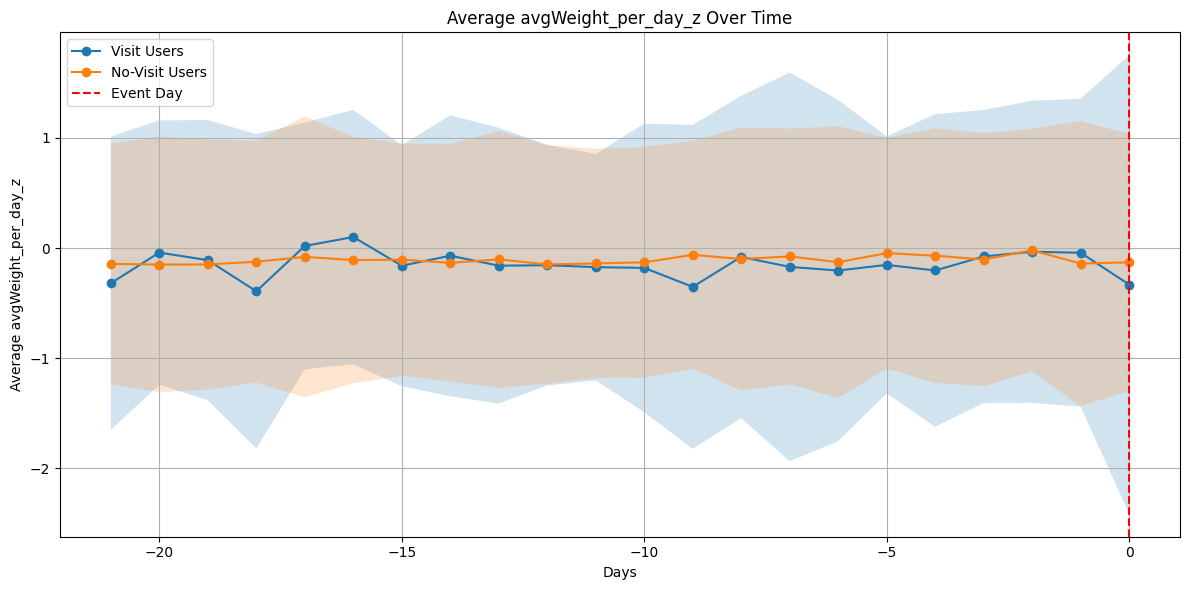

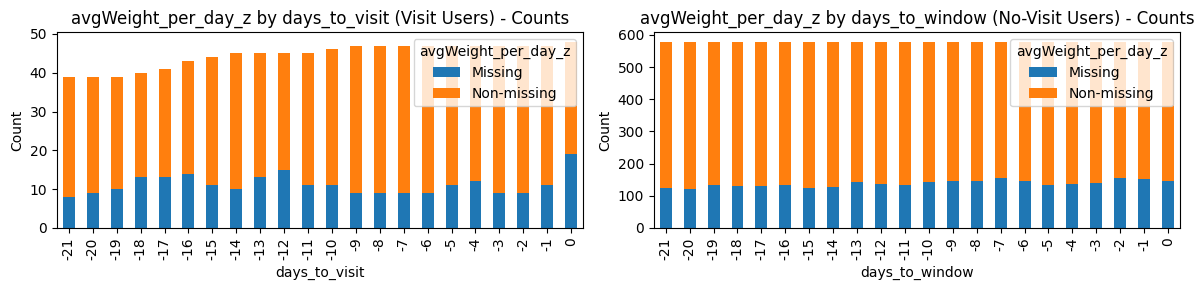

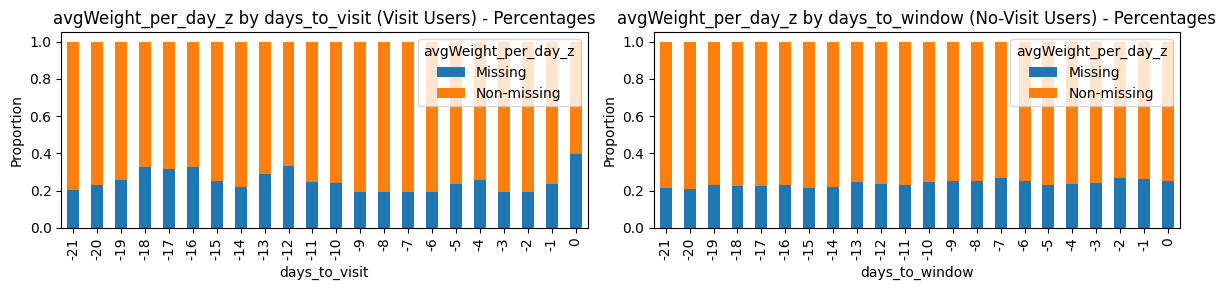

In [22]:
plot_feature_comparison(three_week_visit_weight, three_week_weight, 'avgWeight_per_day_z', bin_continuous=True, n_bins=10)

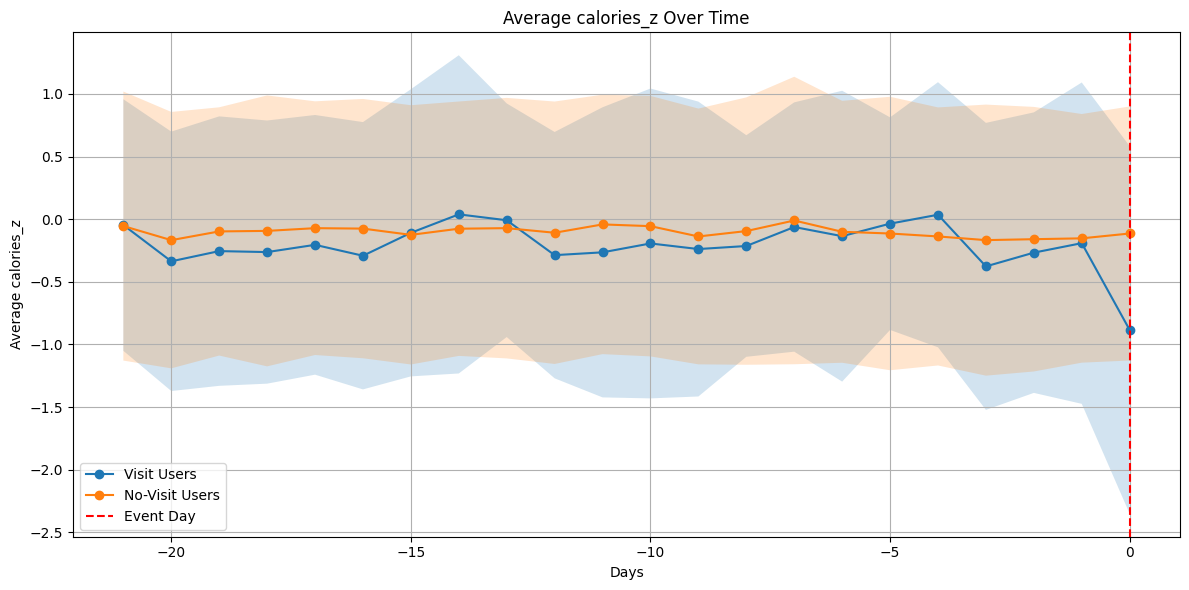

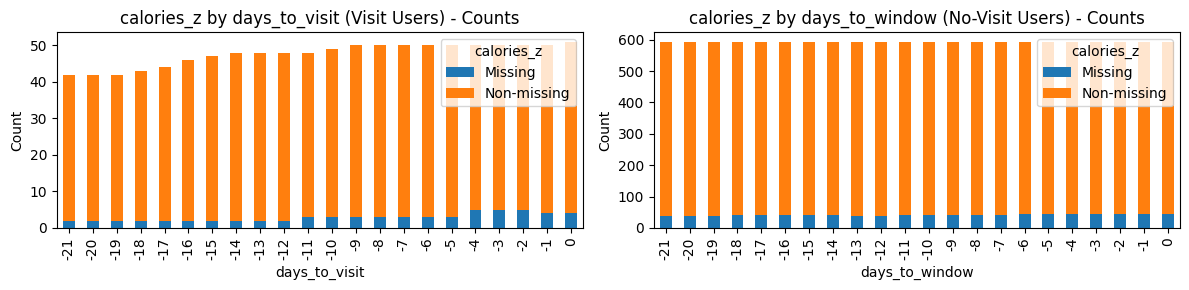

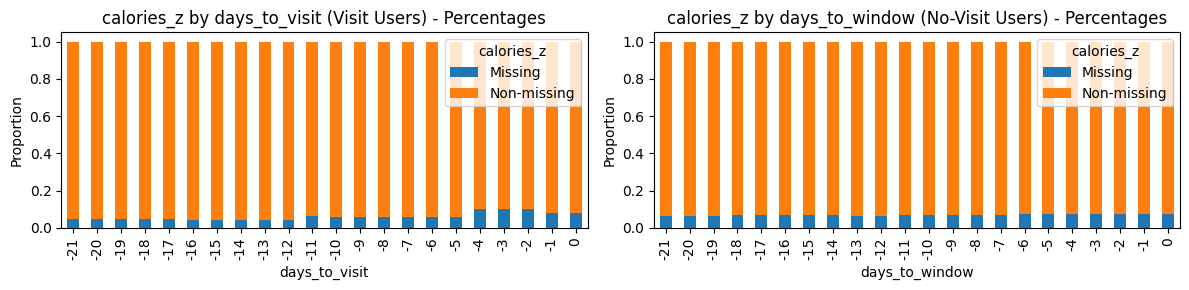

In [23]:
plot_feature_comparison(three_week_visit, three_week, 'calories_z', bin_continuous=True, n_bins=10)

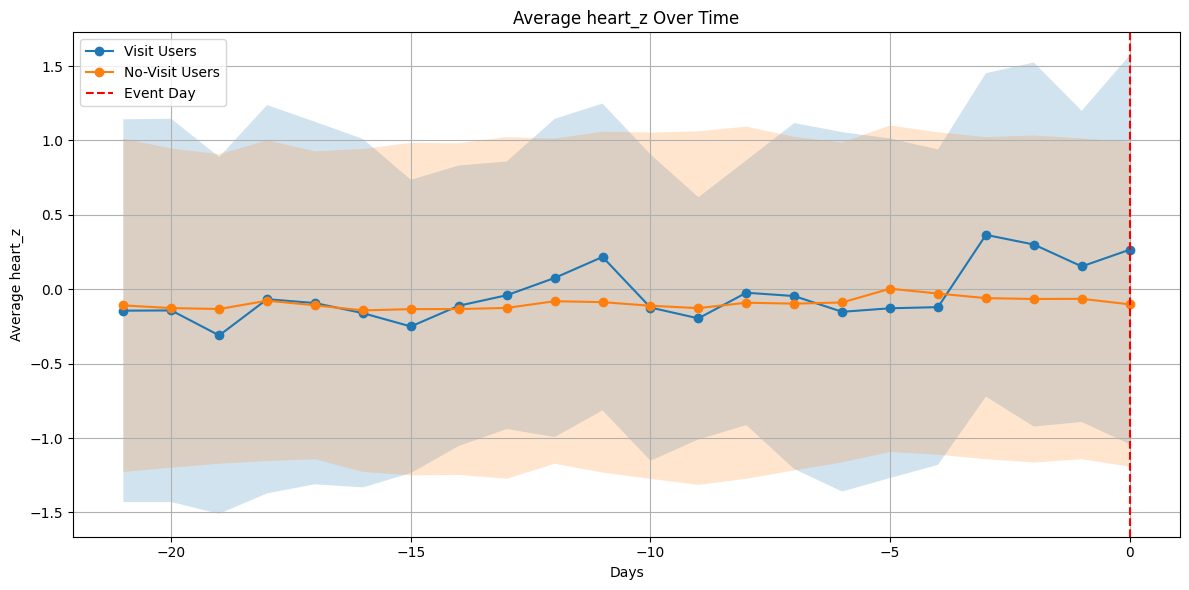

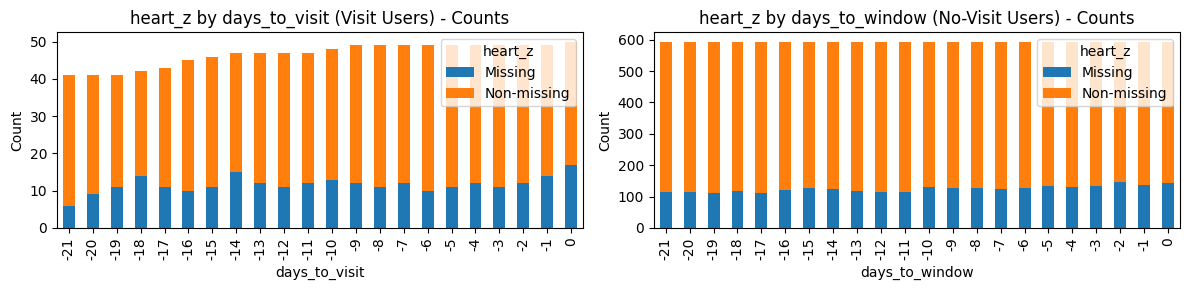

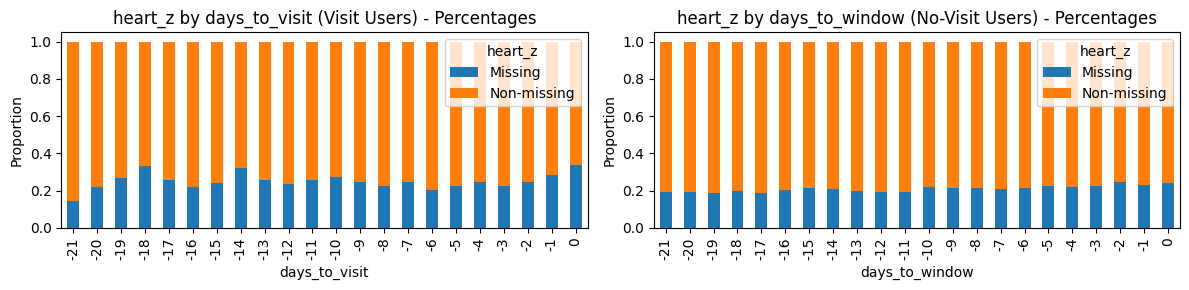

In [24]:
plot_feature_comparison(three_week_visit[three_week_visit['fitbit_user_id'] != 82], three_week, 'heart_z', bin_continuous=True, n_bins=10)

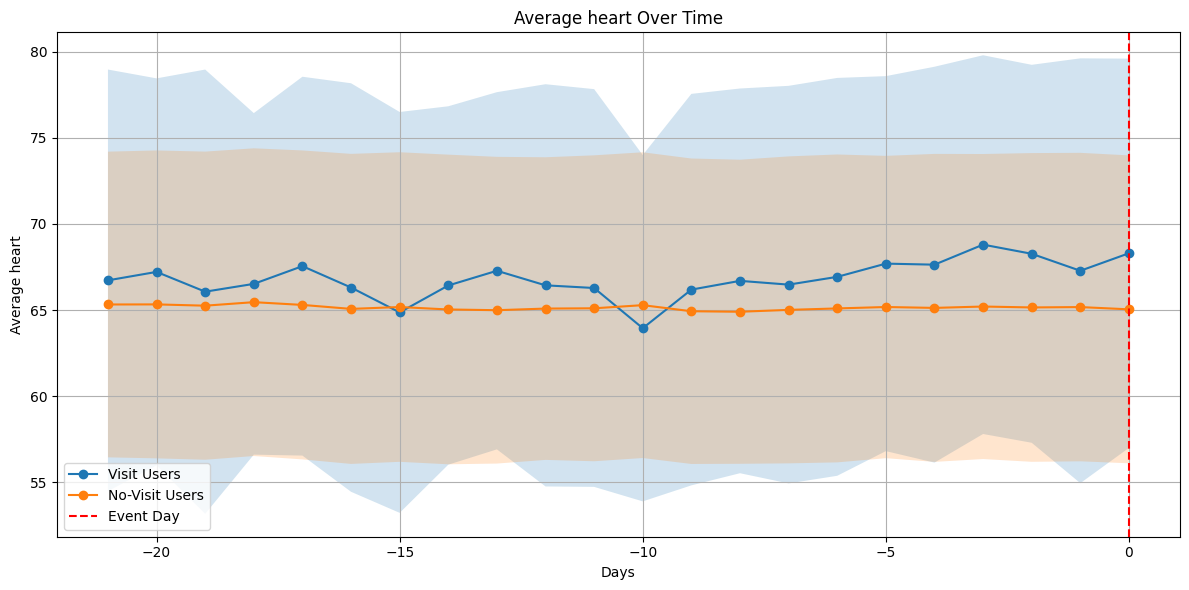

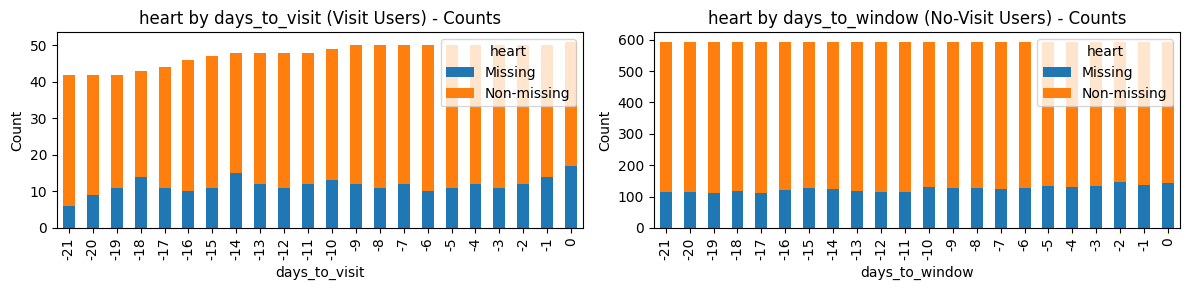

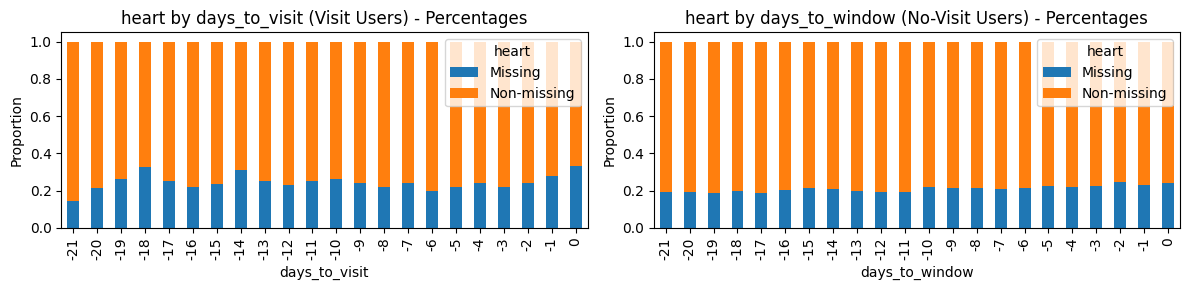

In [25]:
plot_feature_comparison(three_week_visit, three_week, 'heart', bin_continuous=True, n_bins=10)

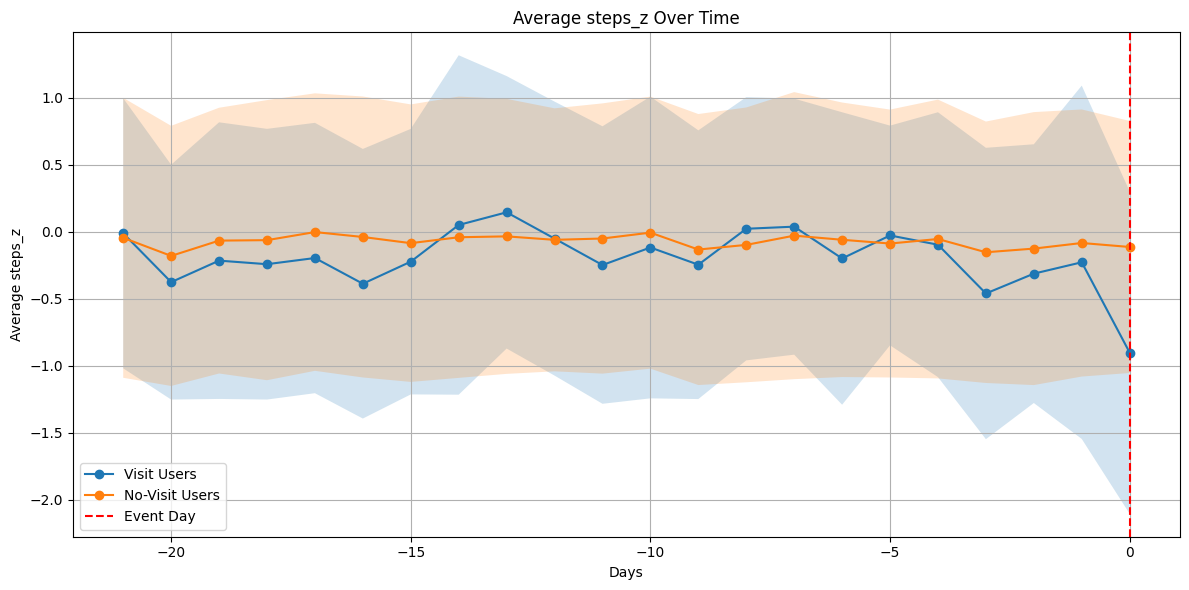

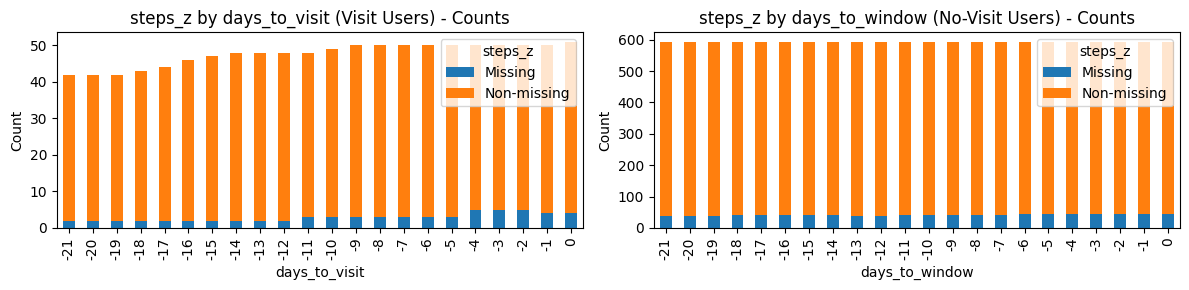

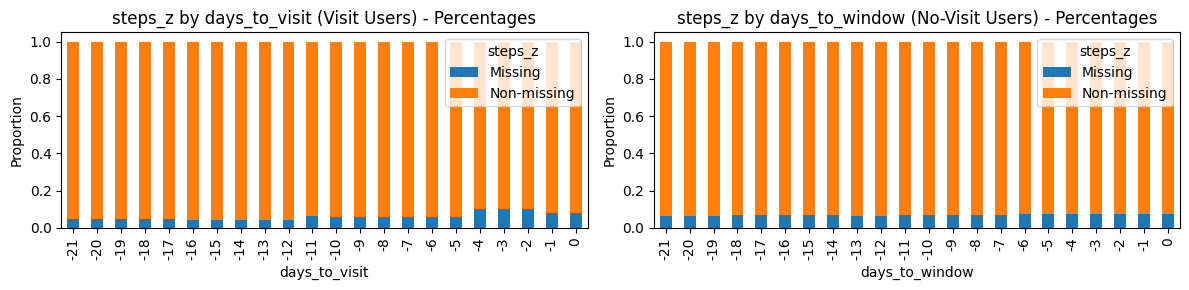

In [26]:
plot_feature_comparison(three_week_visit, three_week, 'steps_z', bin_continuous=True, n_bins=10)

In [27]:
three_week_visit_symptoms = drop_nan_user(three_week_visit, 'symptoms')
three_week_symptoms = drop_nan_user(three_week, 'symptoms')

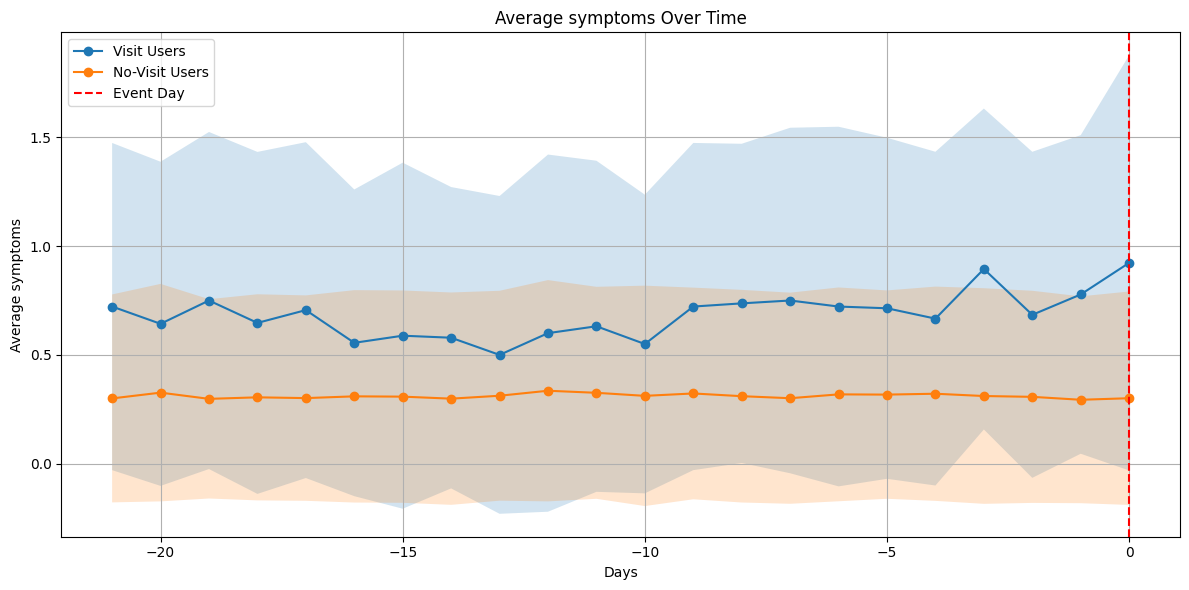

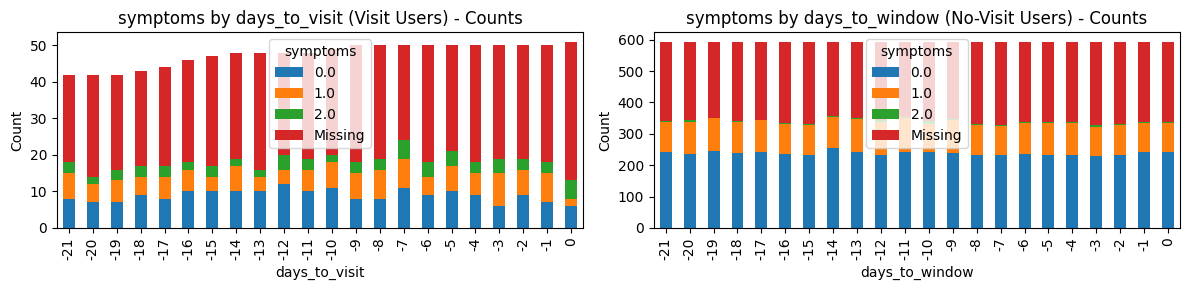

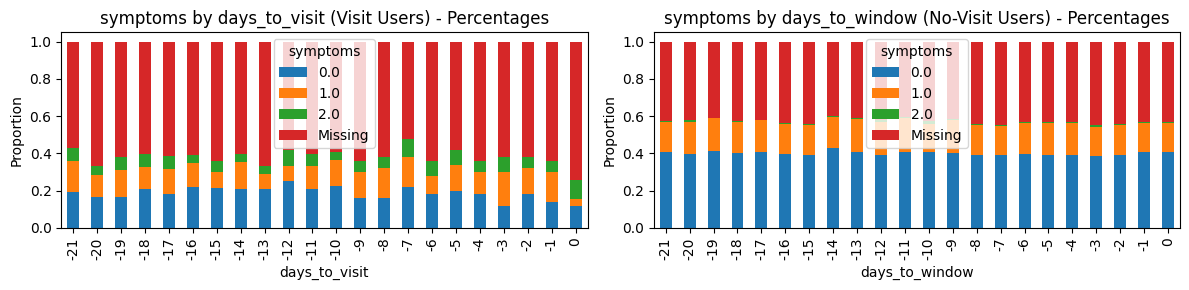

In [28]:
plot_feature_comparison(three_week_visit, three_week, 'symptoms', bin_continuous=False)

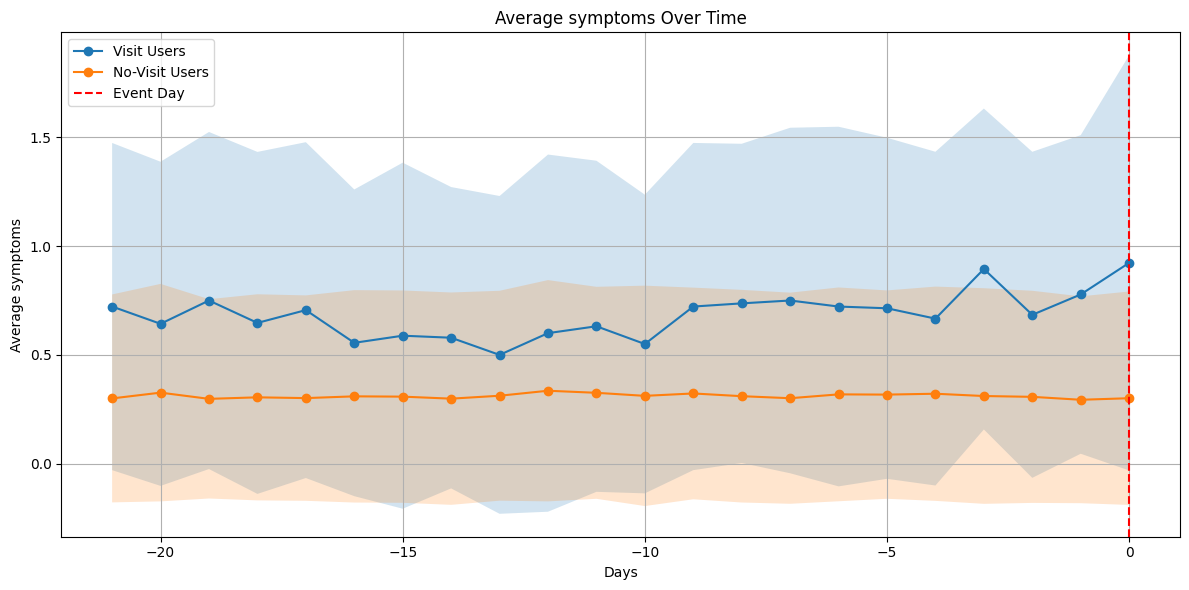

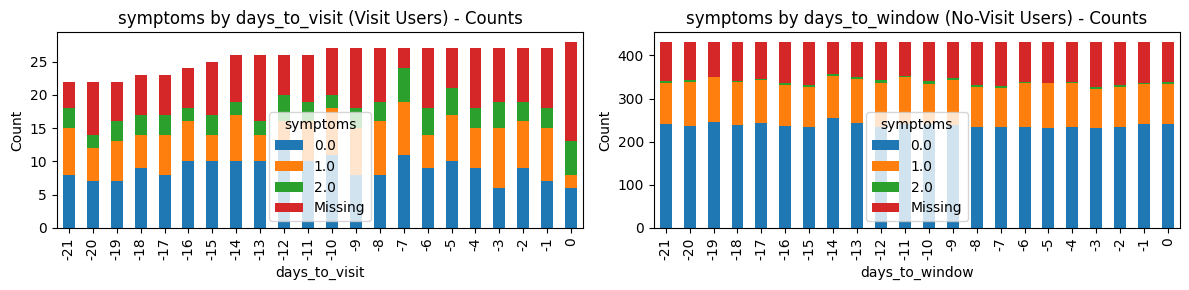

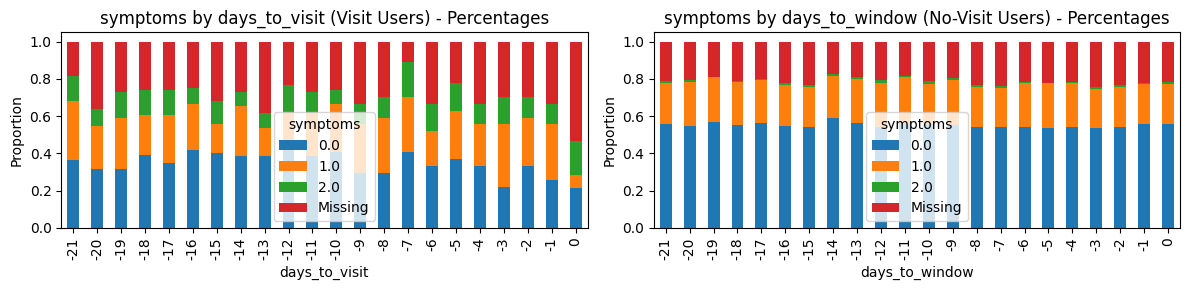

In [29]:
plot_feature_comparison(three_week_visit_symptoms, three_week_symptoms, 'symptoms', bin_continuous=False)

In [30]:
three_week_visit_hrv_deep = drop_nan_user(three_week_visit, 'hrv_deepRmssd_z')
three_week_hrv_deep = drop_nan_user(three_week, 'hrv_deepRmssd_z')

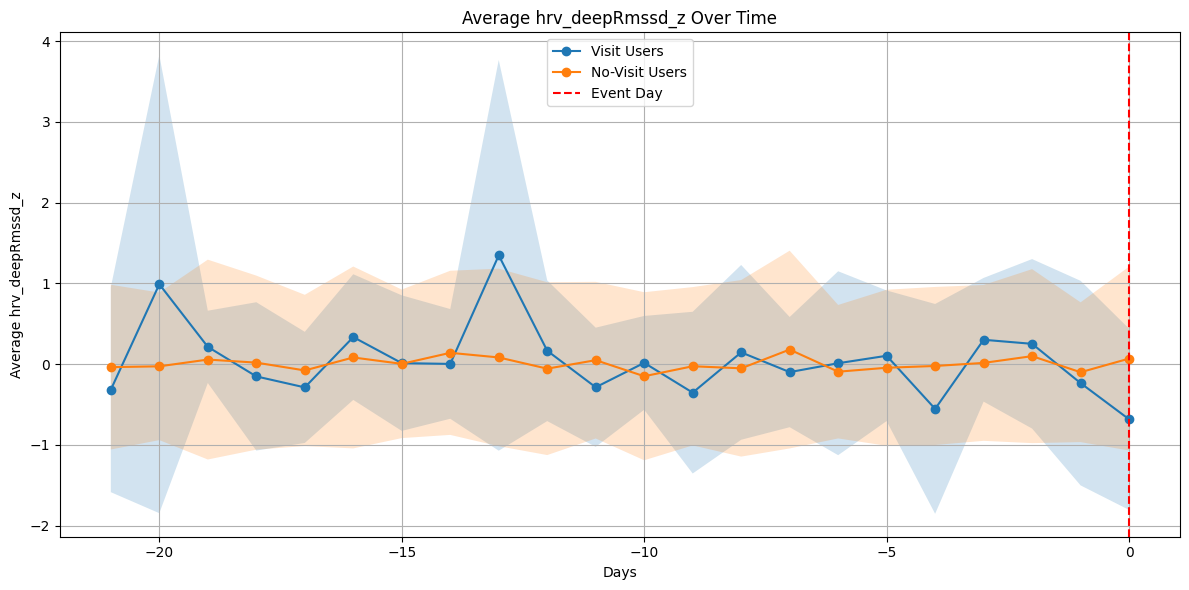

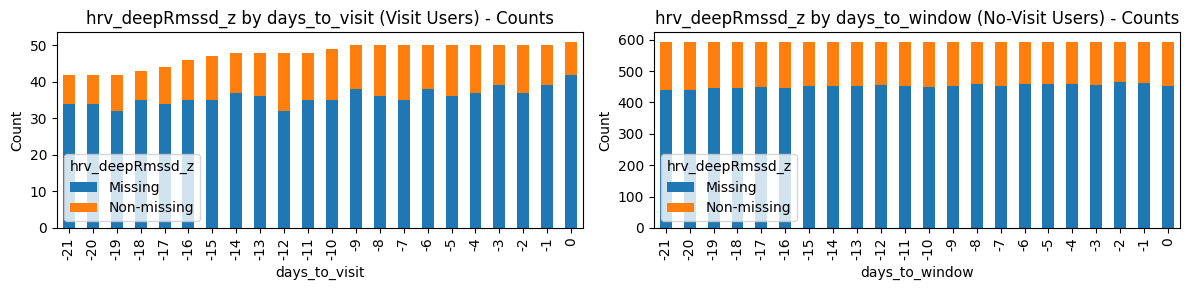

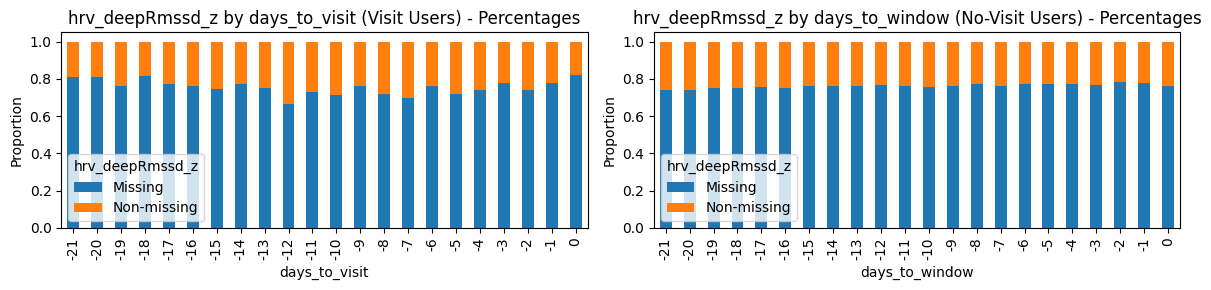

In [31]:
plot_feature_comparison(three_week_visit, three_week, 'hrv_deepRmssd_z', bin_continuous=True)

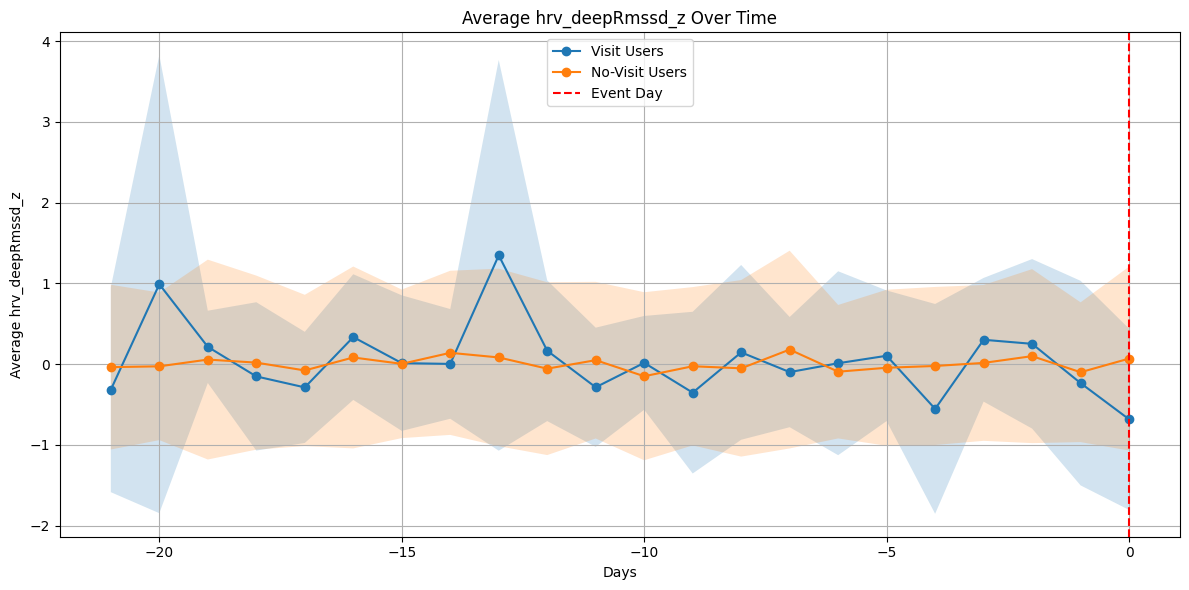

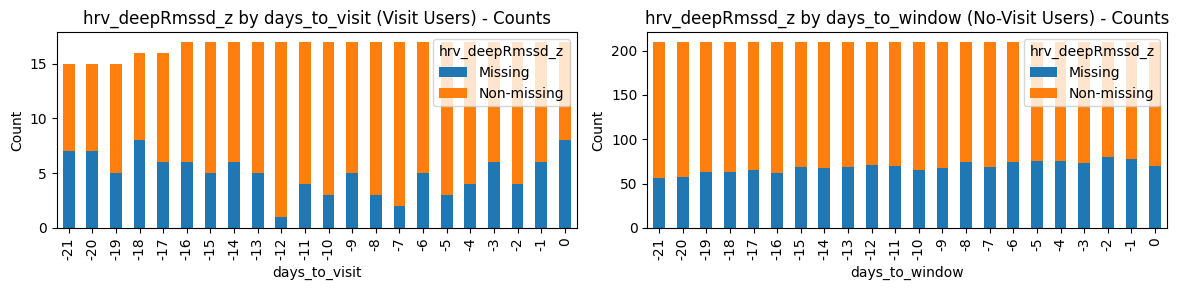

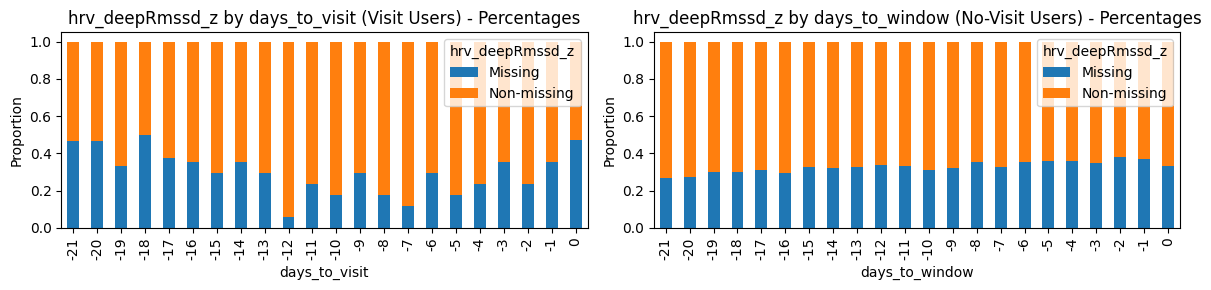

In [32]:
plot_feature_comparison(three_week_visit_hrv_deep, three_week_hrv_deep, 'hrv_deepRmssd_z', bin_continuous=True)

In [33]:
three_week_visit_hrv_daily = drop_nan_user(three_week_visit, 'hrv_dailyRmssd_z')
three_week_hrv_daily = drop_nan_user(three_week, 'hrv_dailyRmssd_z')

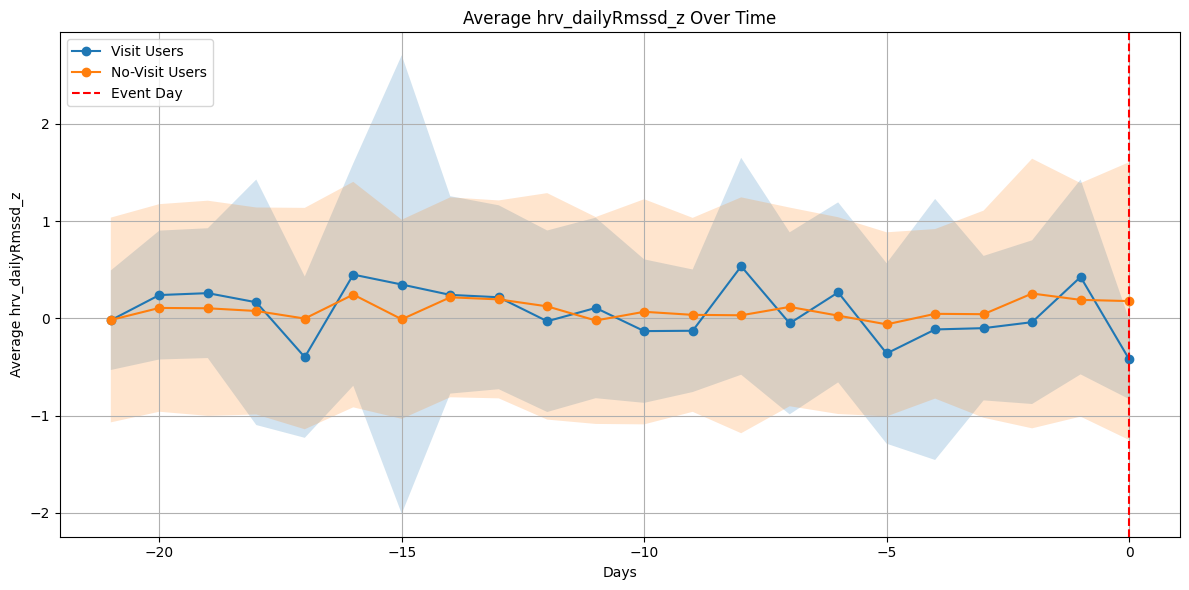

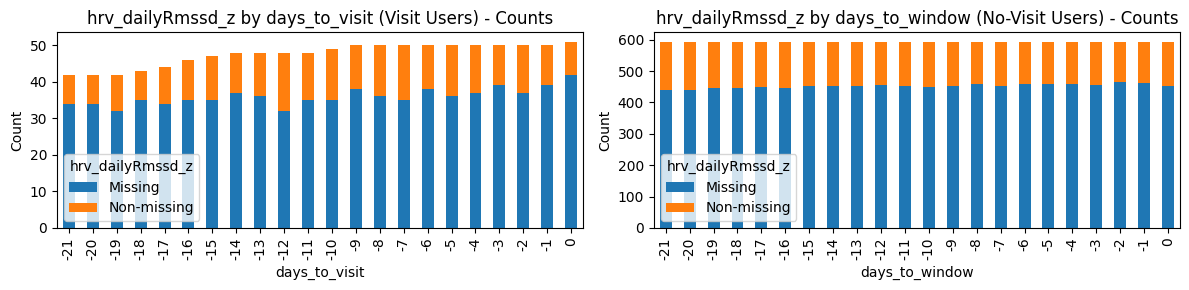

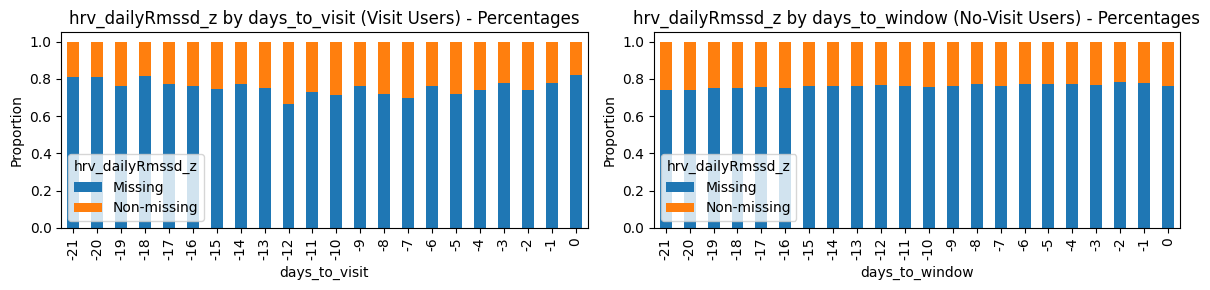

In [34]:
plot_feature_comparison(three_week_visit, three_week, 'hrv_dailyRmssd_z', bin_continuous=True)

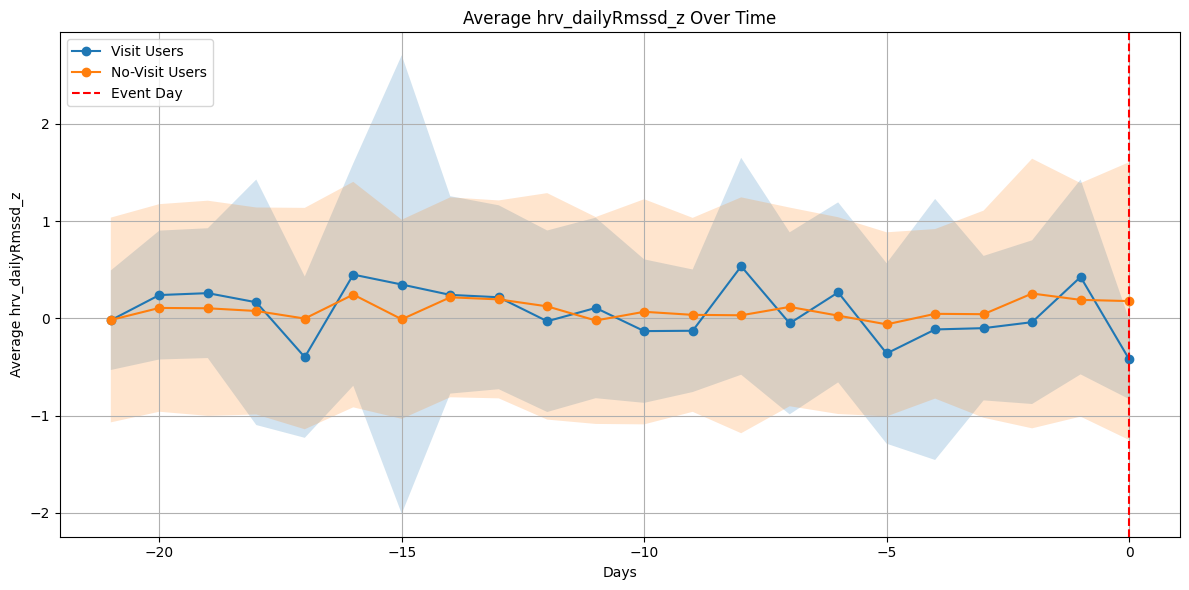

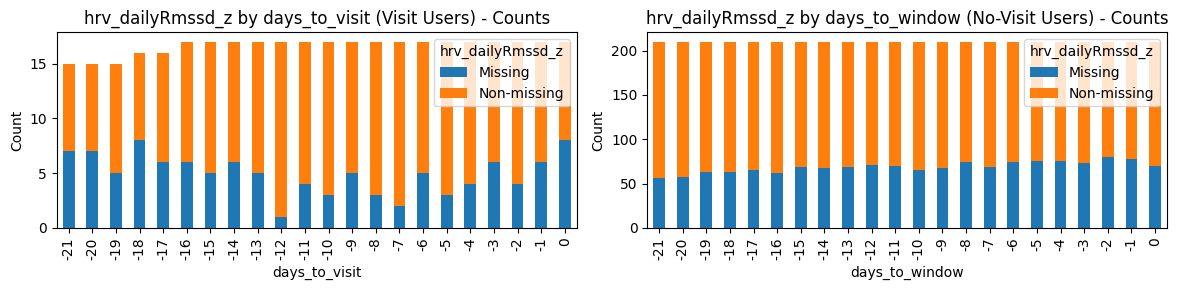

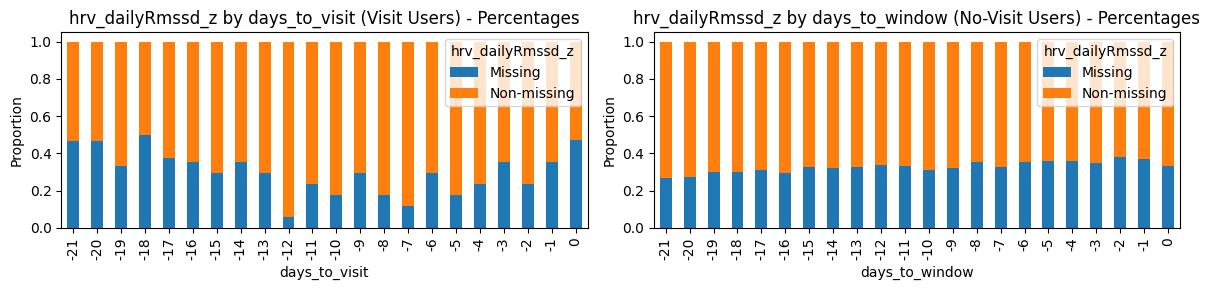

In [35]:
plot_feature_comparison(three_week_visit_hrv_daily, three_week_hrv_daily, 'hrv_dailyRmssd_z', bin_continuous=True)

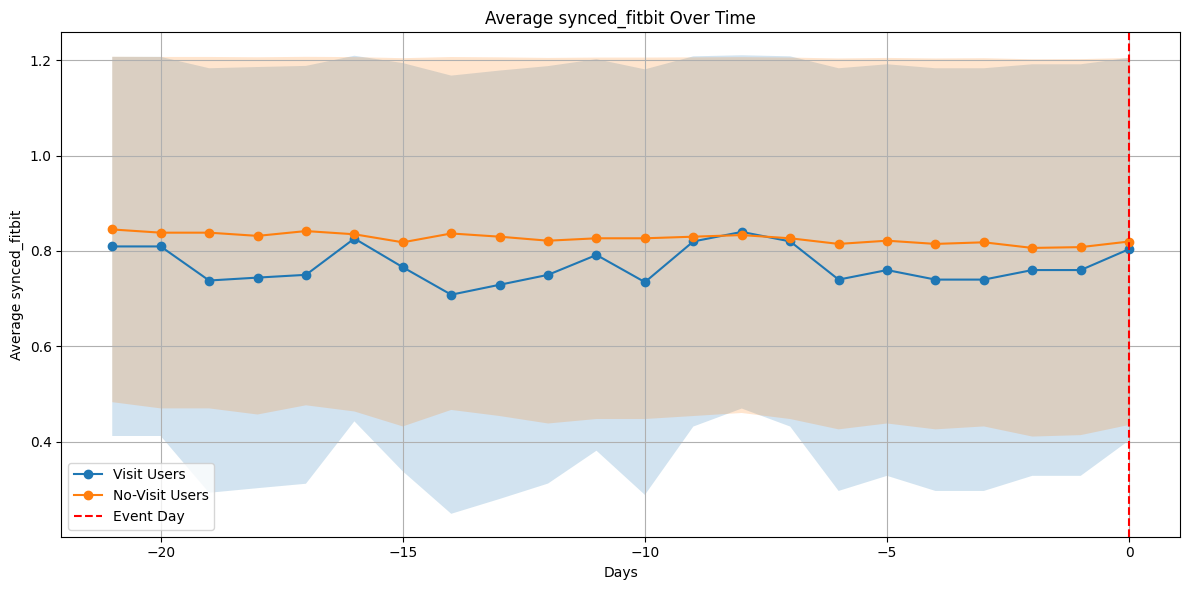

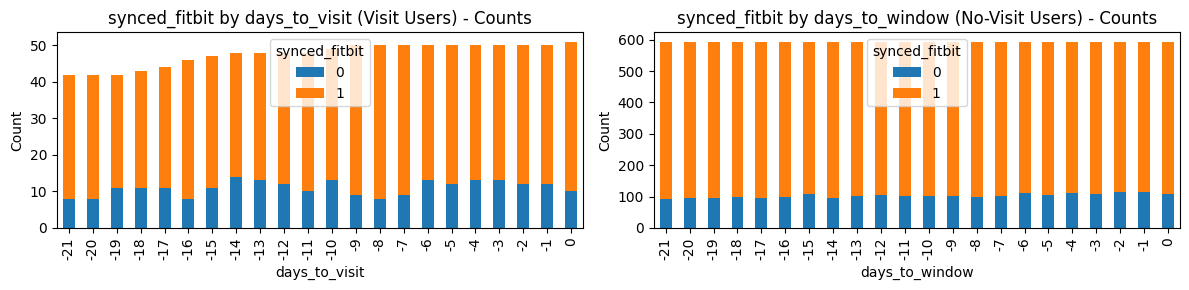

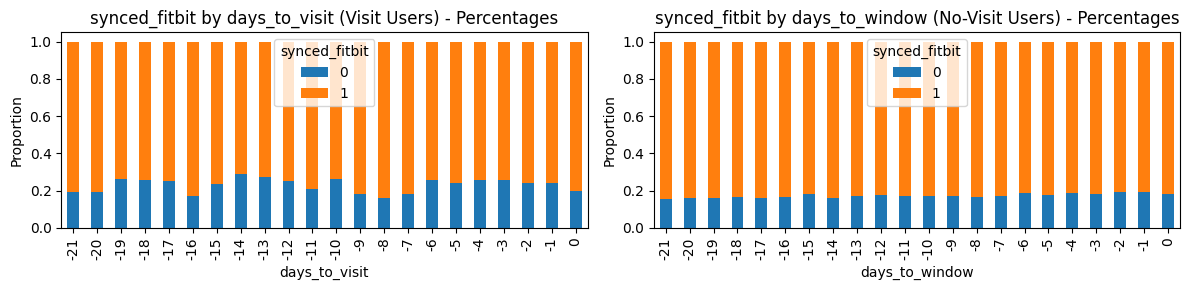

In [36]:
plot_feature_comparison(three_week_visit, three_week, 'synced_fitbit', bin_continuous=False)

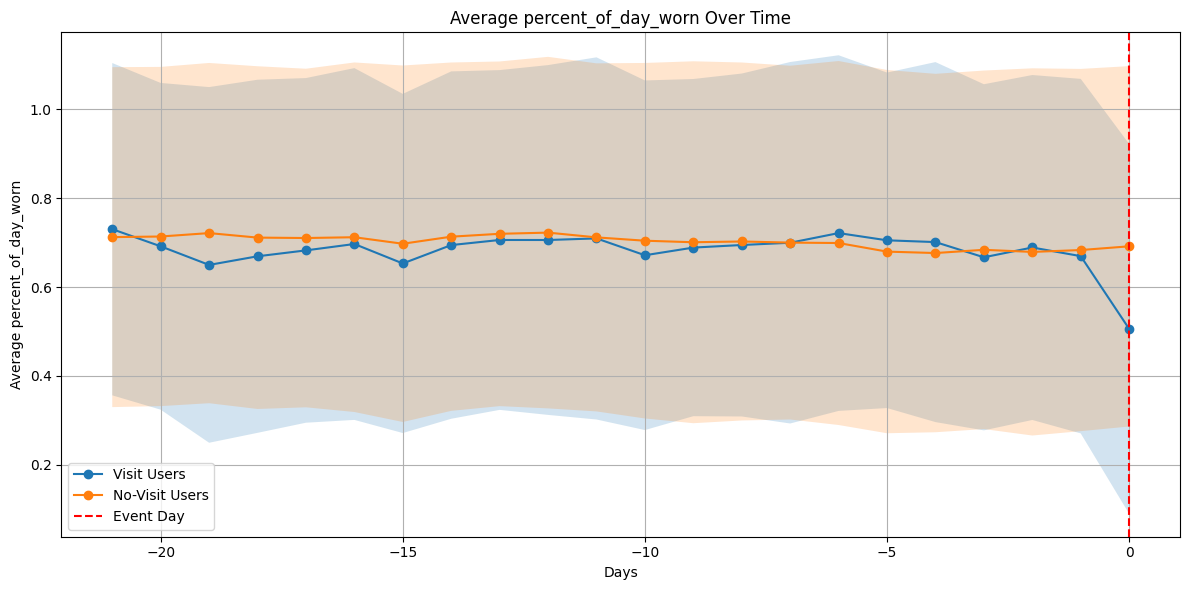

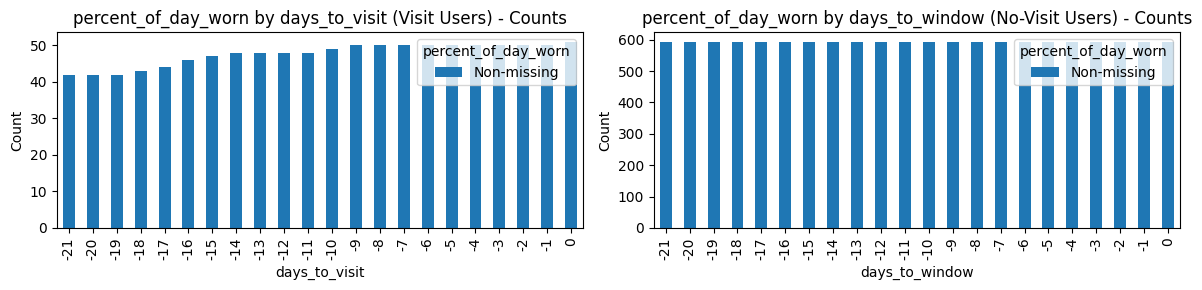

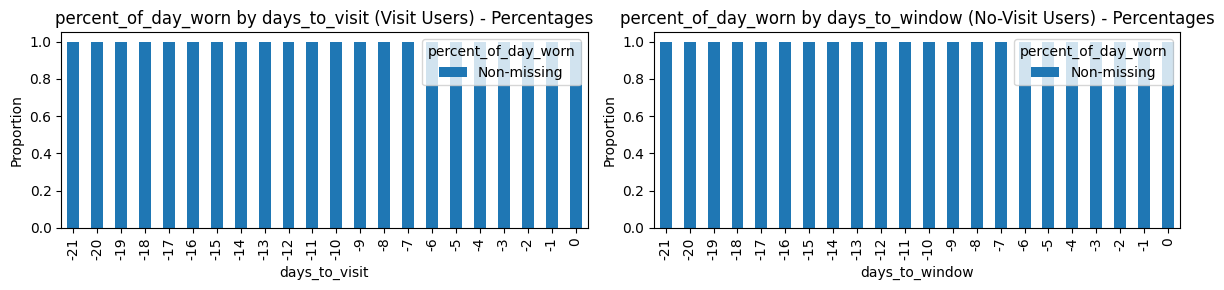

In [37]:
plot_feature_comparison(three_week_visit, three_week, 'percent_of_day_worn', bin_continuous=True)

In [38]:
three_week_visit_app = three_week_visit[three_week_visit['study_group'] != 'No App']
three_week_app = three_week[three_week['study_group'] != 'No App']

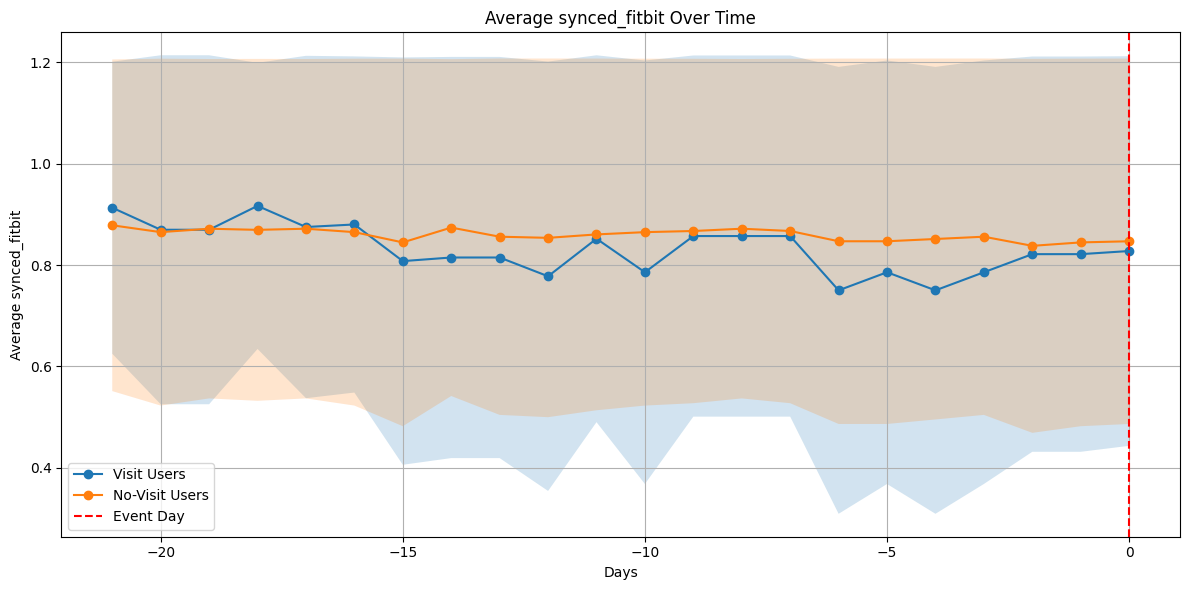

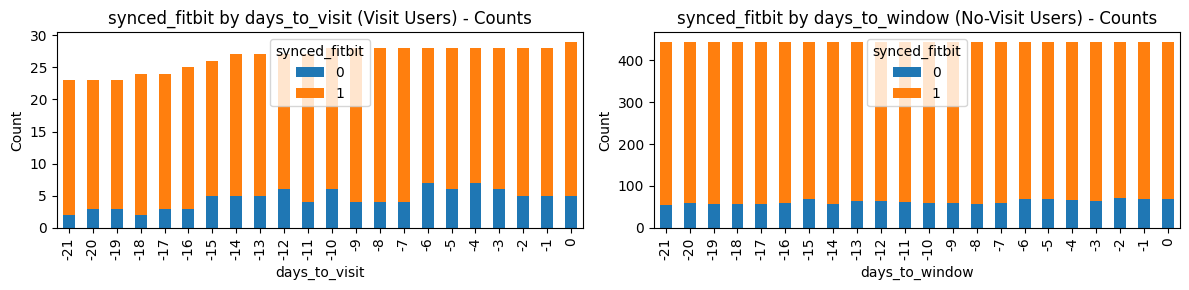

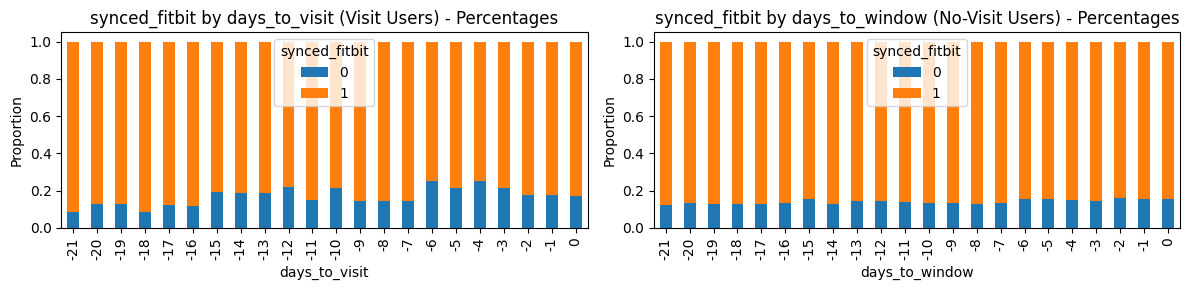

In [39]:
plot_feature_comparison(three_week_visit_app, three_week_app, 'synced_fitbit', bin_continuous=False)

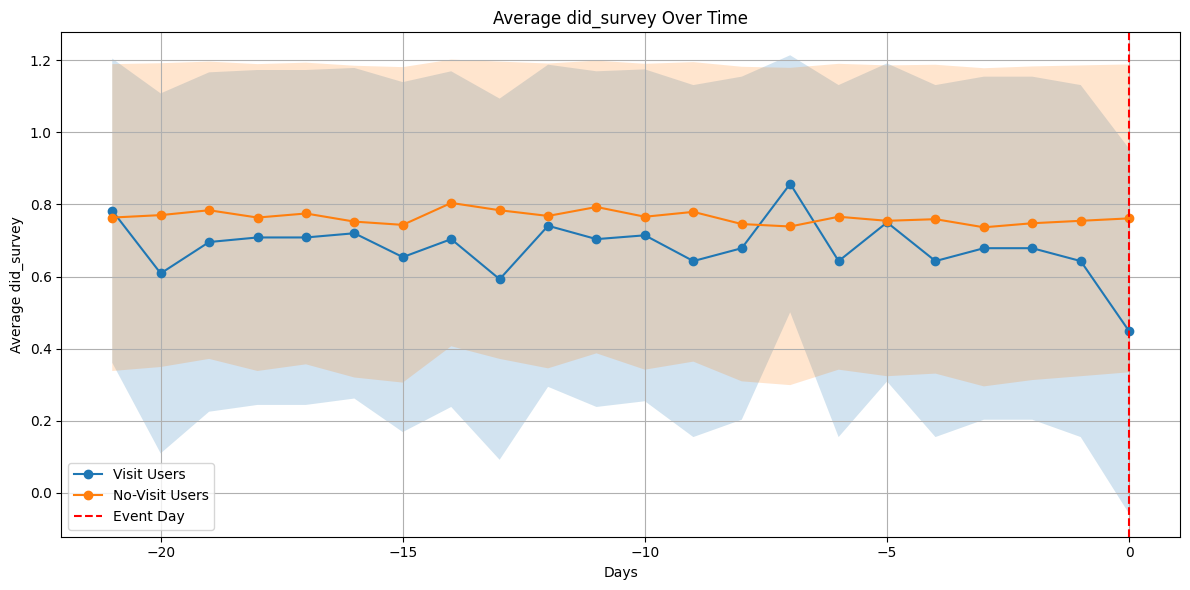

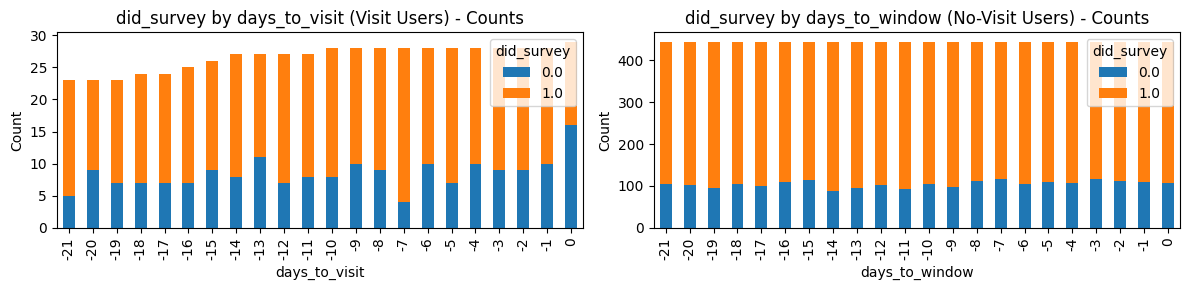

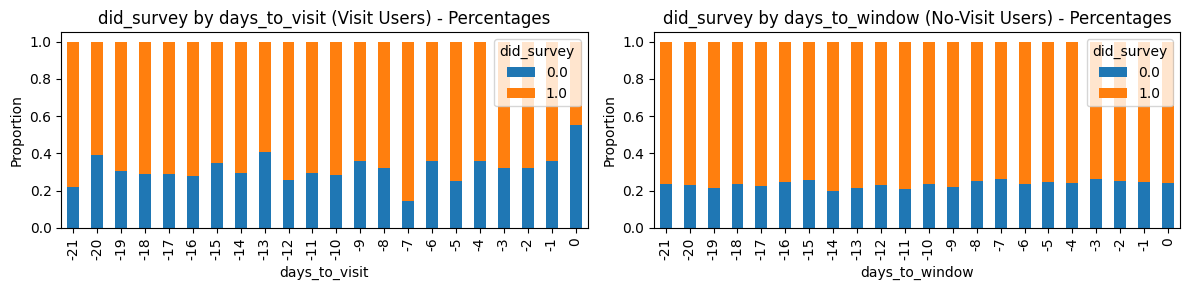

In [40]:
plot_feature_comparison(three_week_visit_app, three_week_app, 'did_survey', bin_continuous=False)

### 2b) Two Week

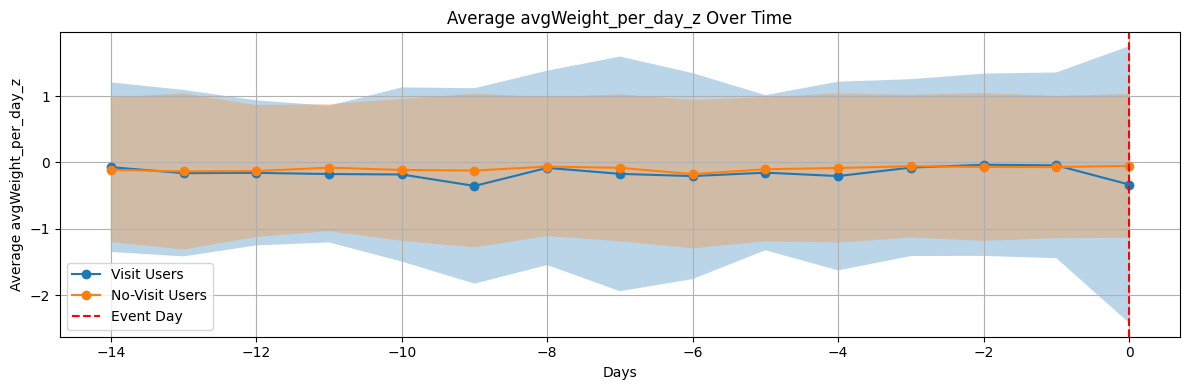

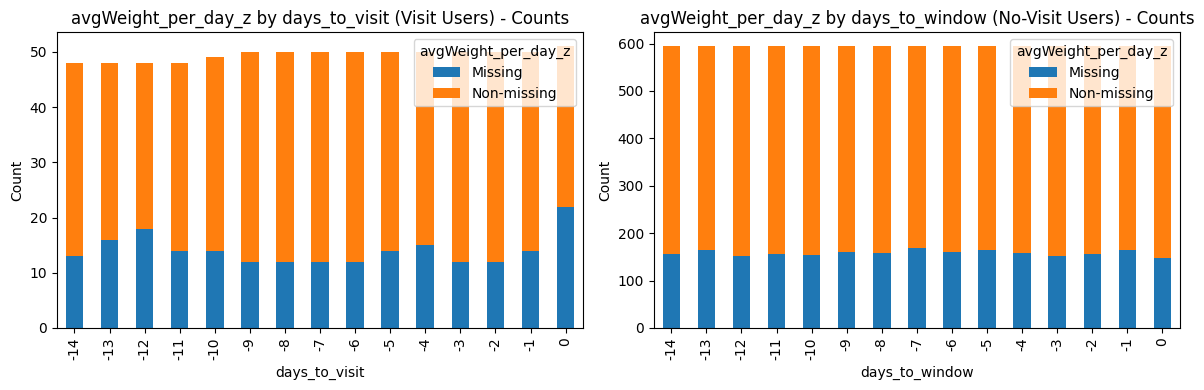

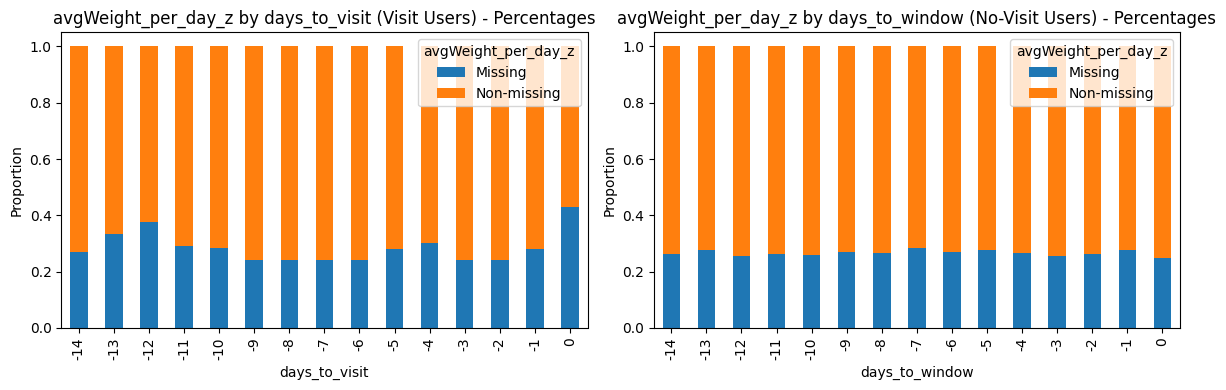

In [165]:
plot_feature_comparison(two_week_visit, two_week, 'avgWeight_per_day_z', bin_continuous=True, n_bins=10)

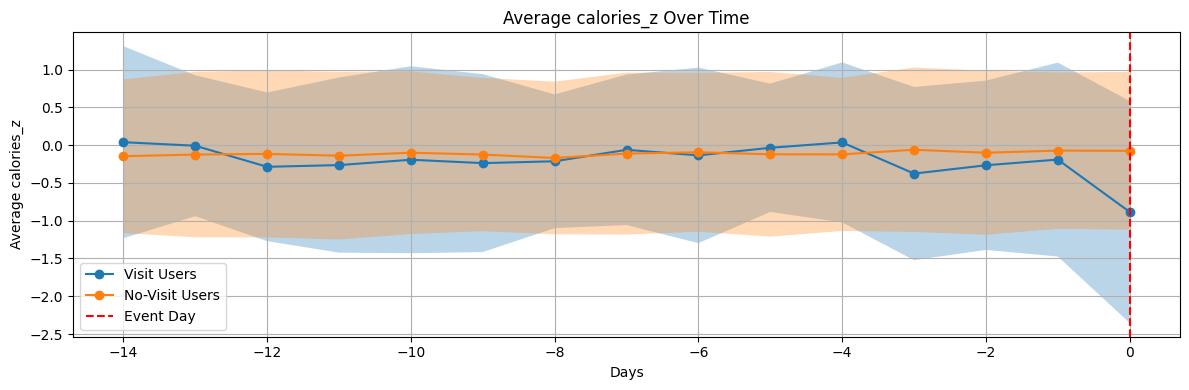

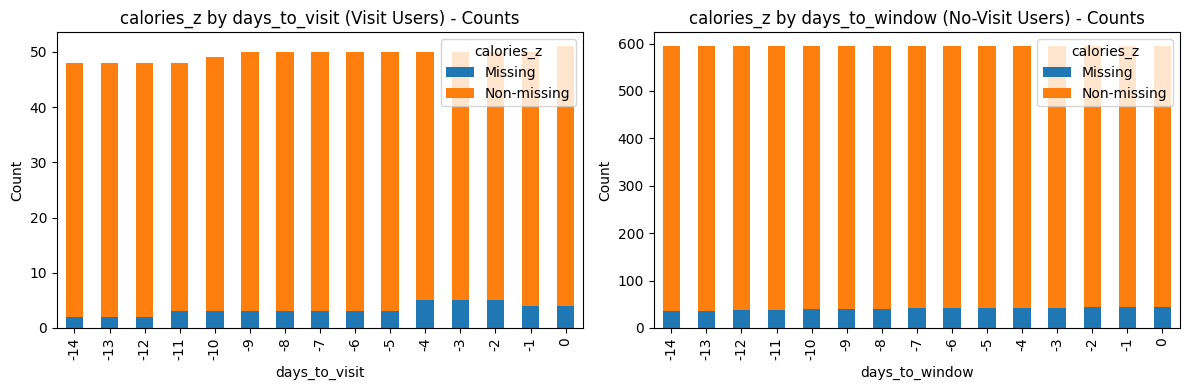

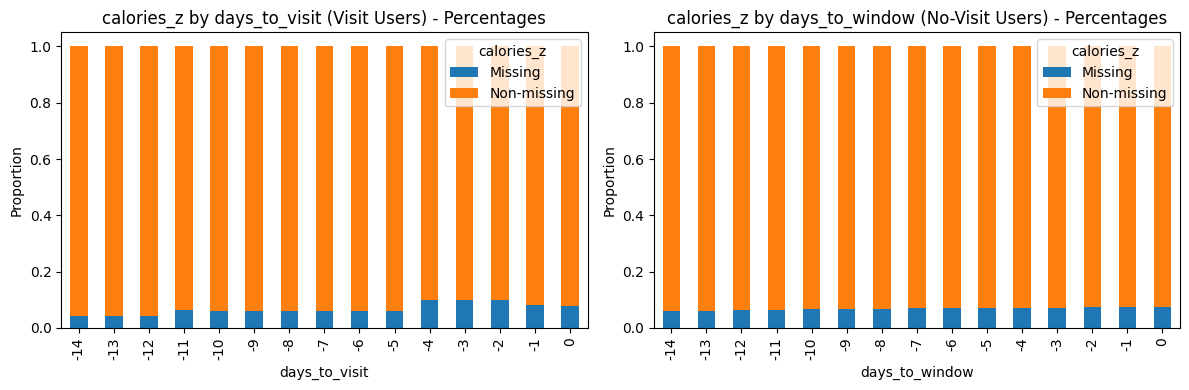

In [166]:
plot_feature_comparison(two_week_visit, two_week, 'calories_z', bin_continuous=True, n_bins=10)

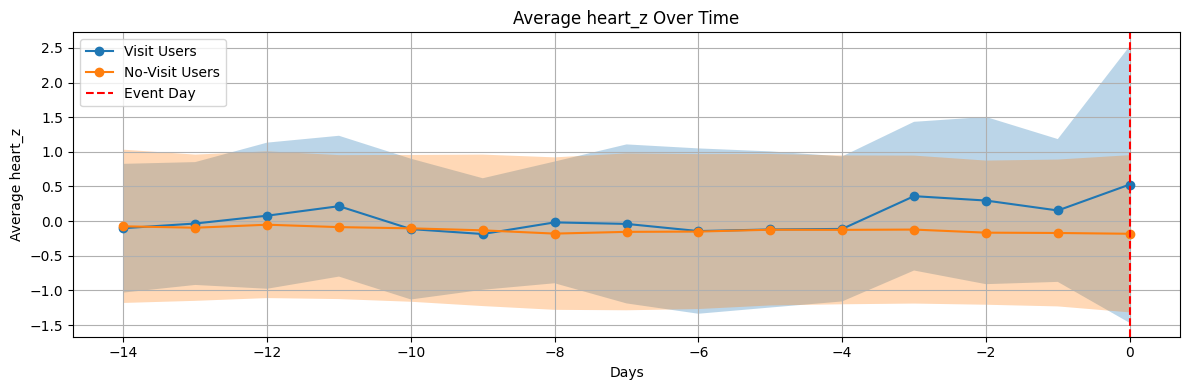

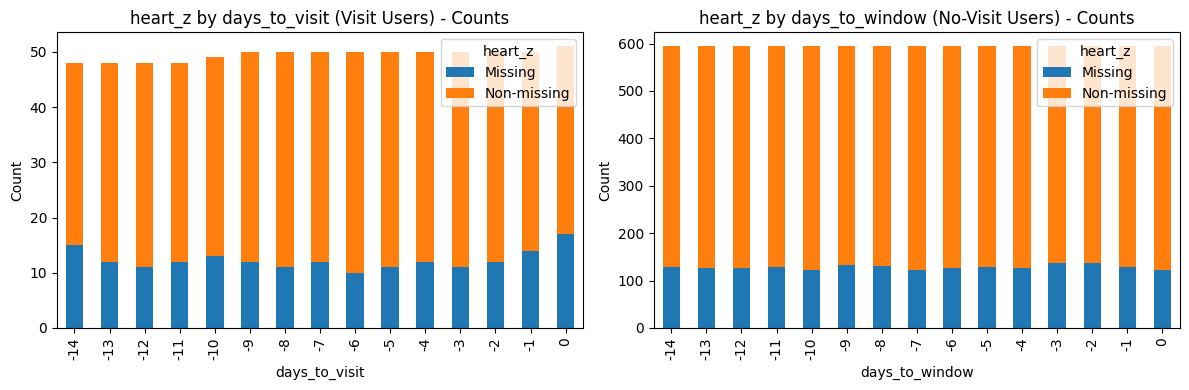

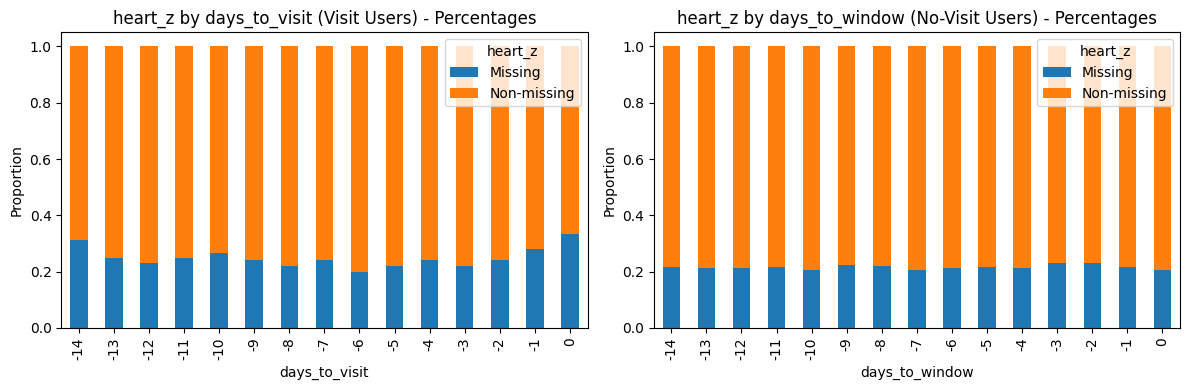

In [167]:
plot_feature_comparison(two_week_visit, two_week, 'heart_z', bin_continuous=True, n_bins=10)

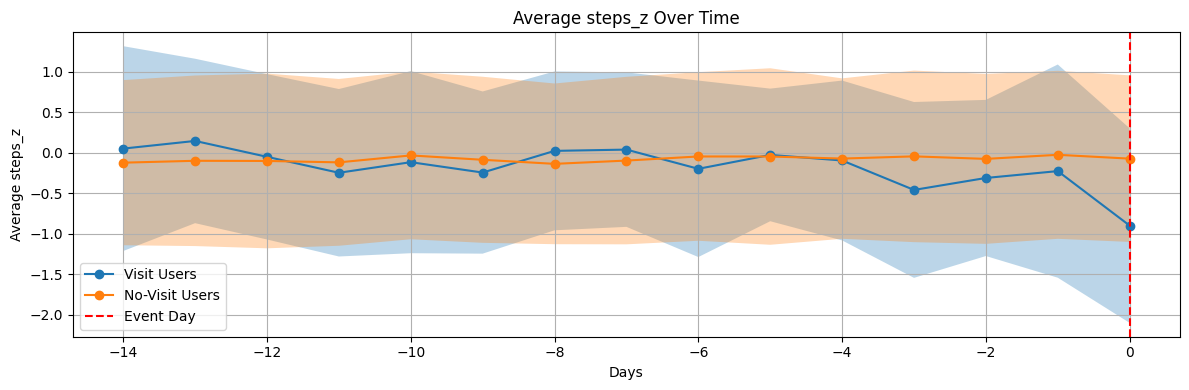

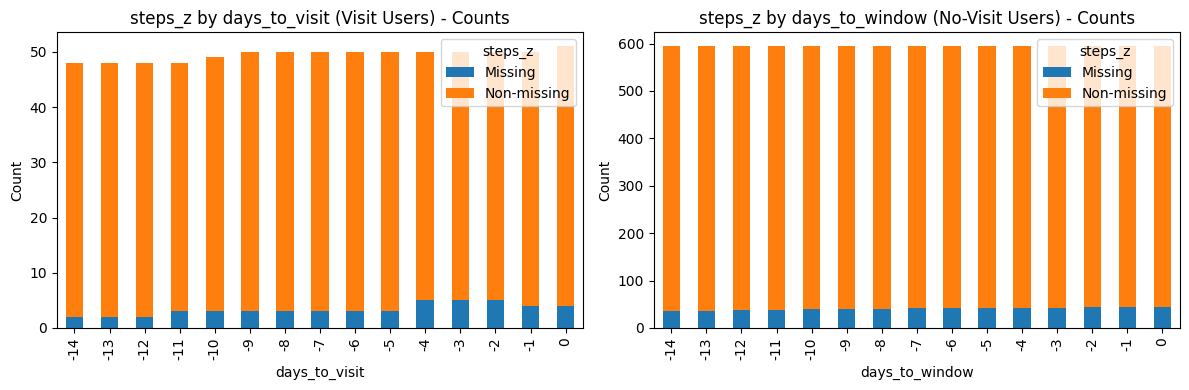

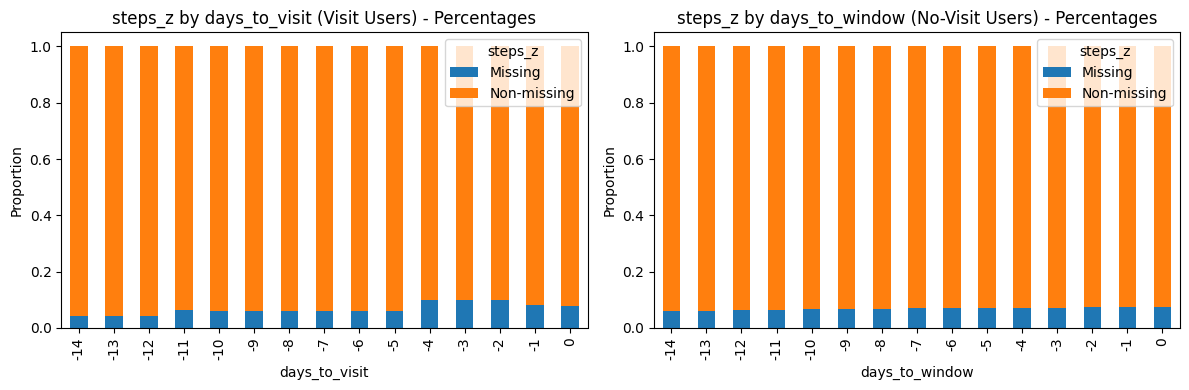

In [168]:
plot_feature_comparison(two_week_visit, two_week, 'steps_z', bin_continuous=True, n_bins=10)

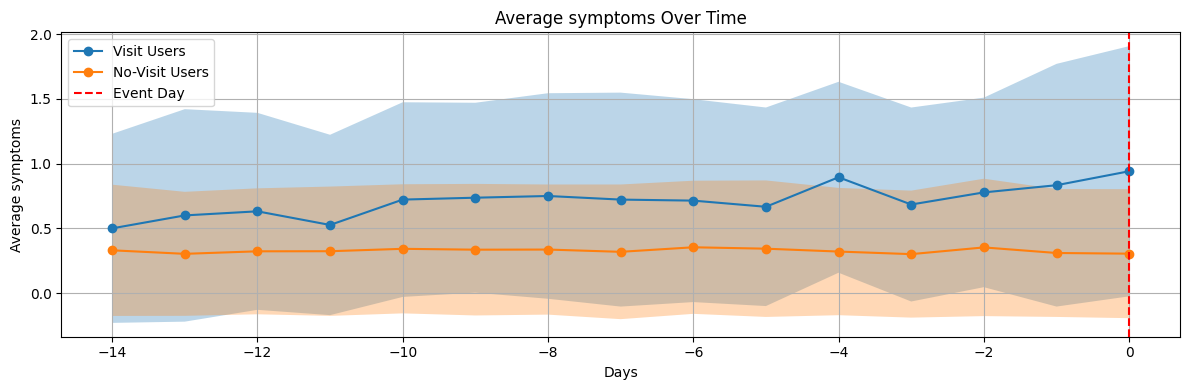

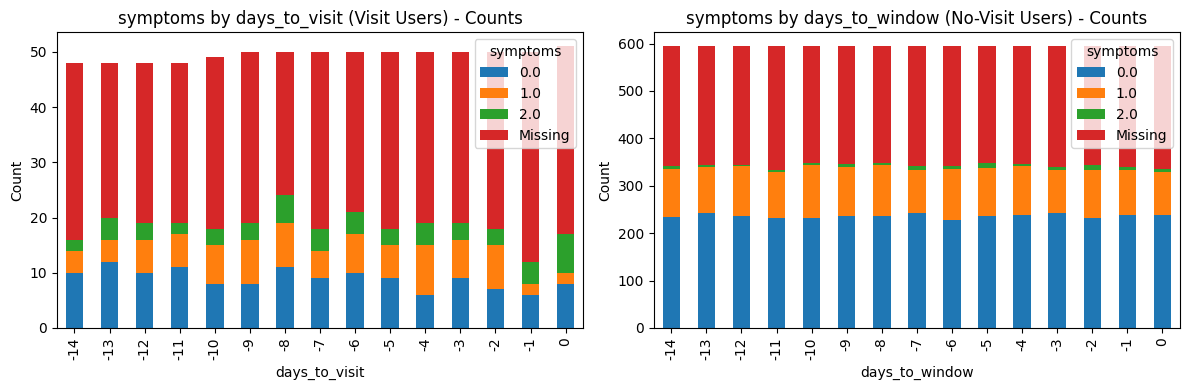

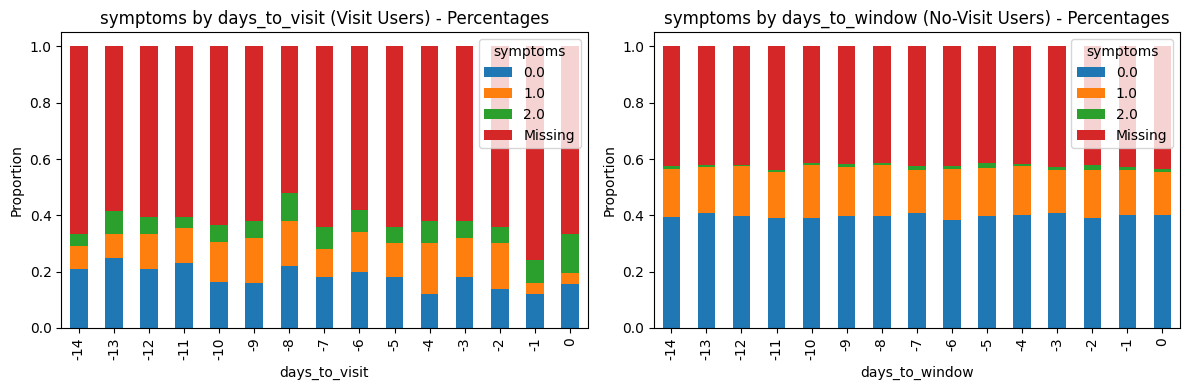

In [169]:
plot_feature_comparison(two_week_visit, two_week, 'symptoms', bin_continuous=False)

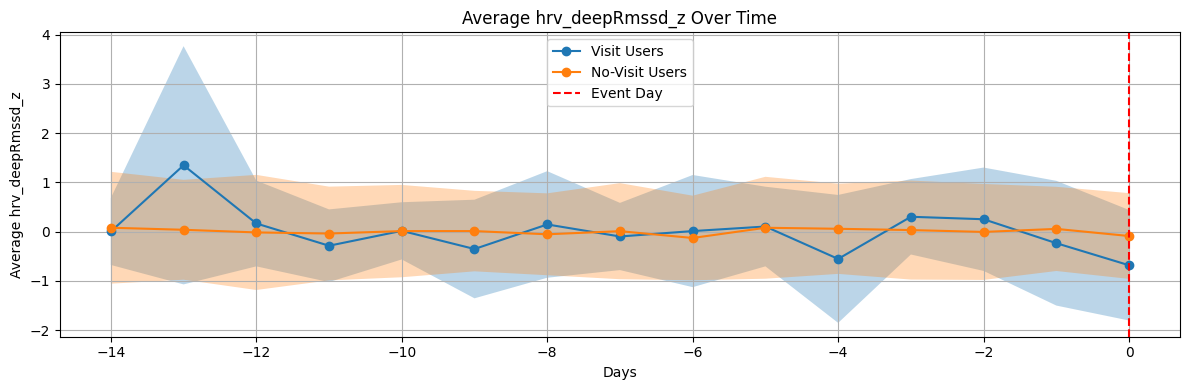

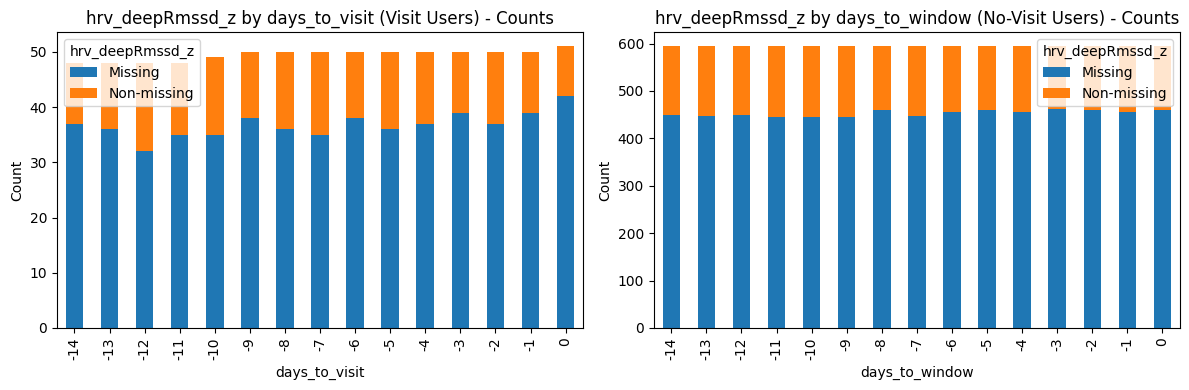

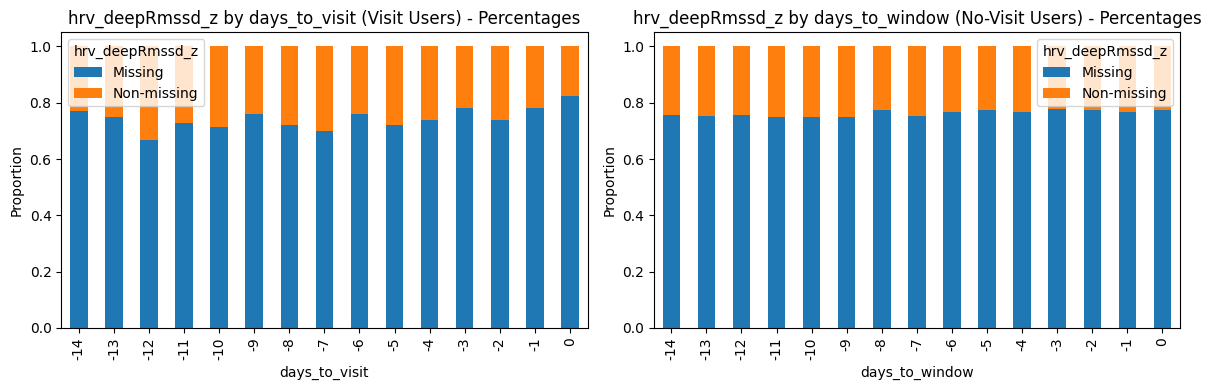

In [170]:
plot_feature_comparison(two_week_visit, two_week, 'hrv_deepRmssd_z', bin_continuous=True)

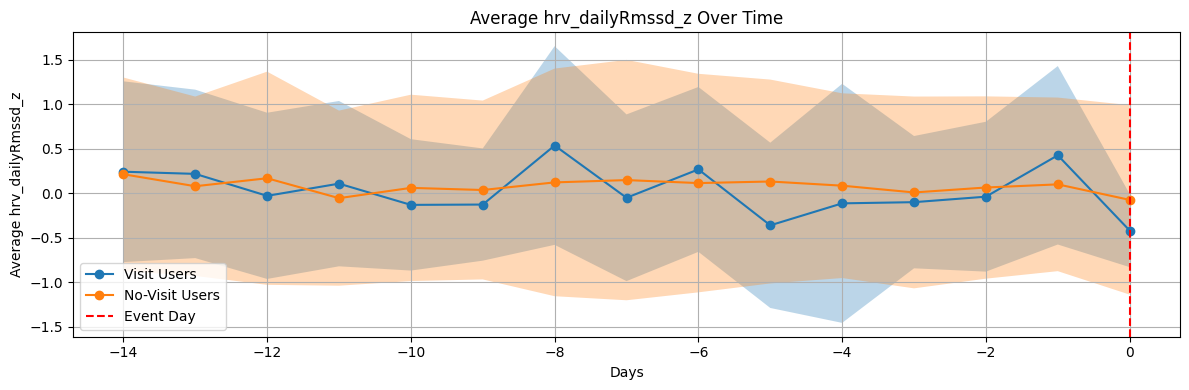

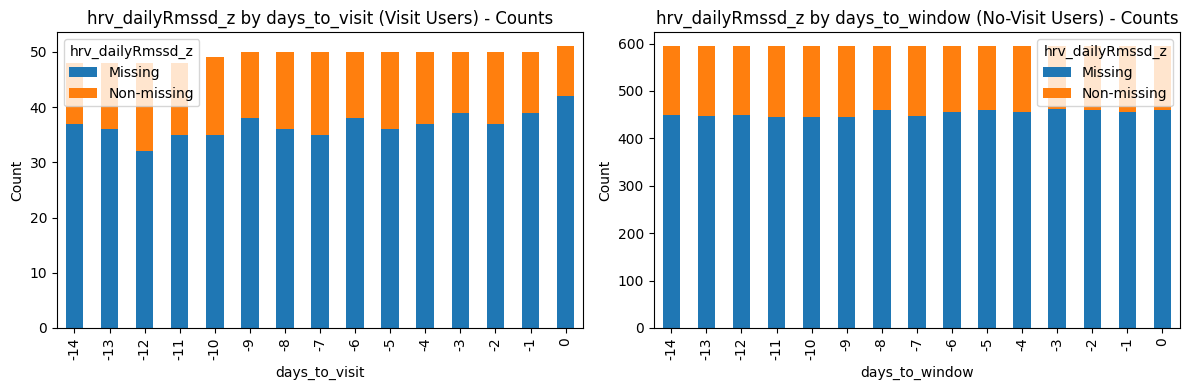

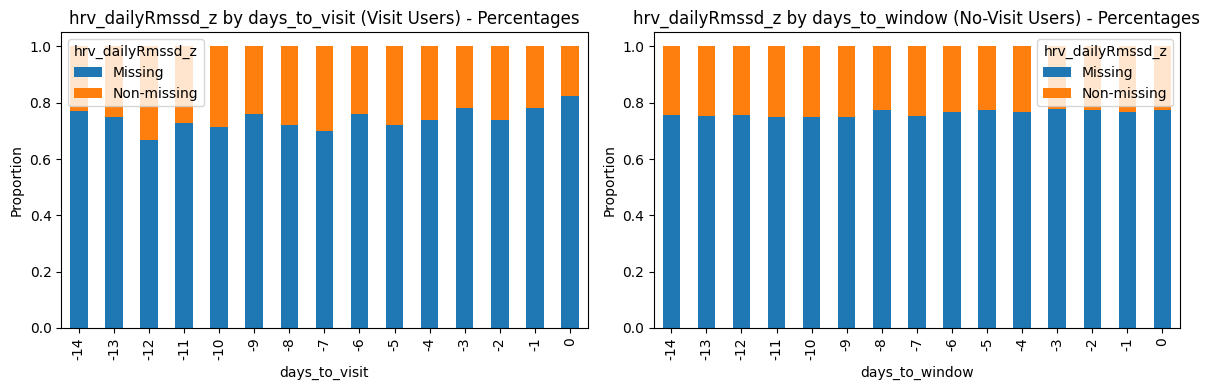

In [171]:
plot_feature_comparison(two_week_visit, two_week, 'hrv_dailyRmssd_z', bin_continuous=True)

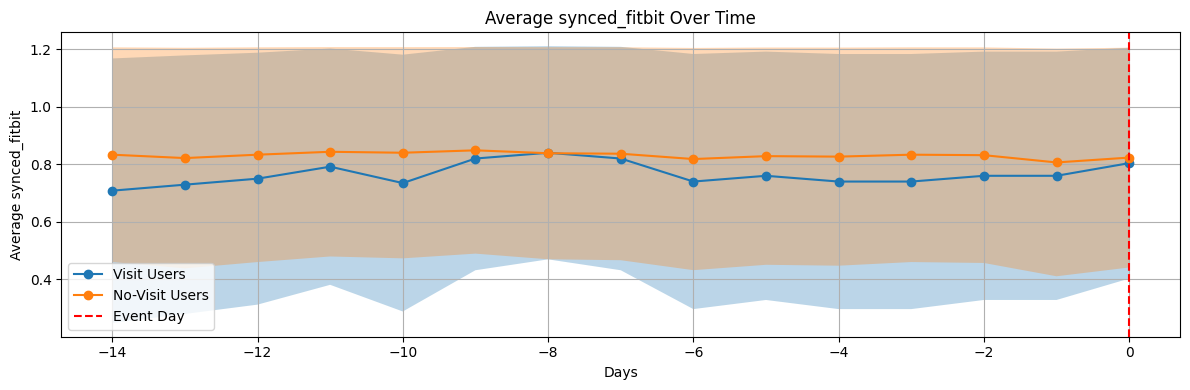

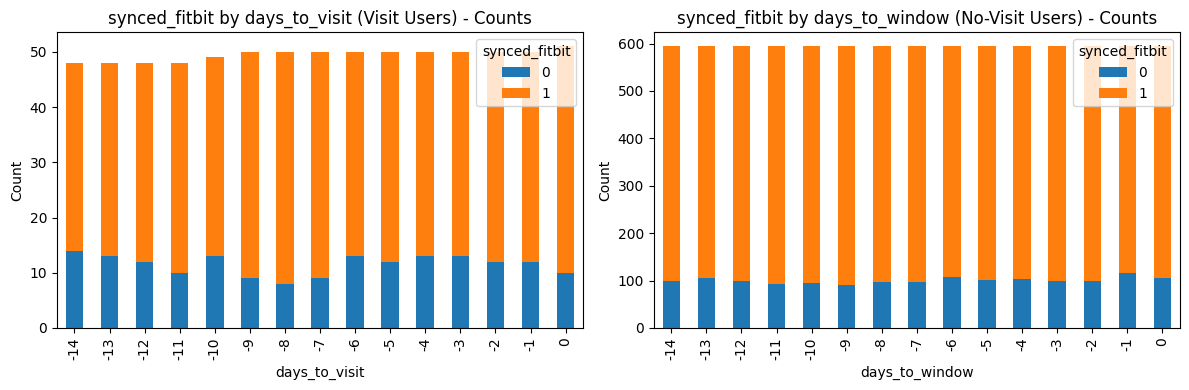

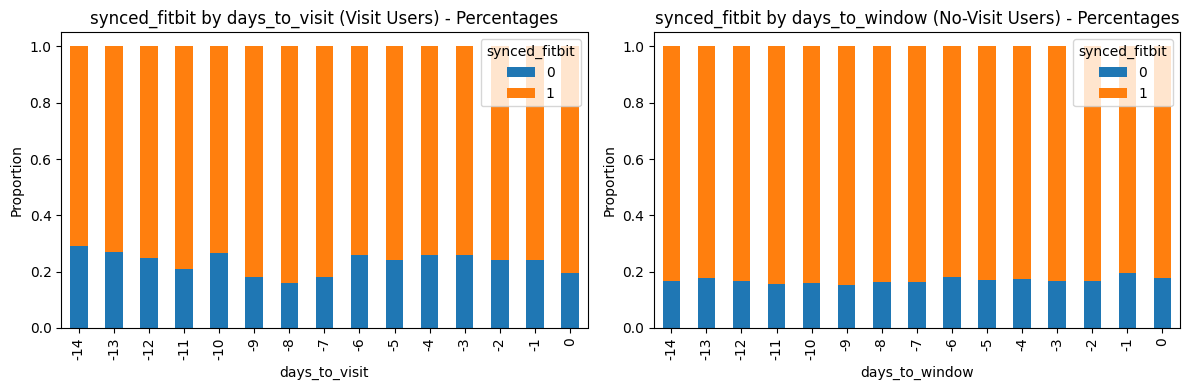

In [172]:
plot_feature_comparison(two_week_visit, two_week, 'synced_fitbit', bin_continuous=False)

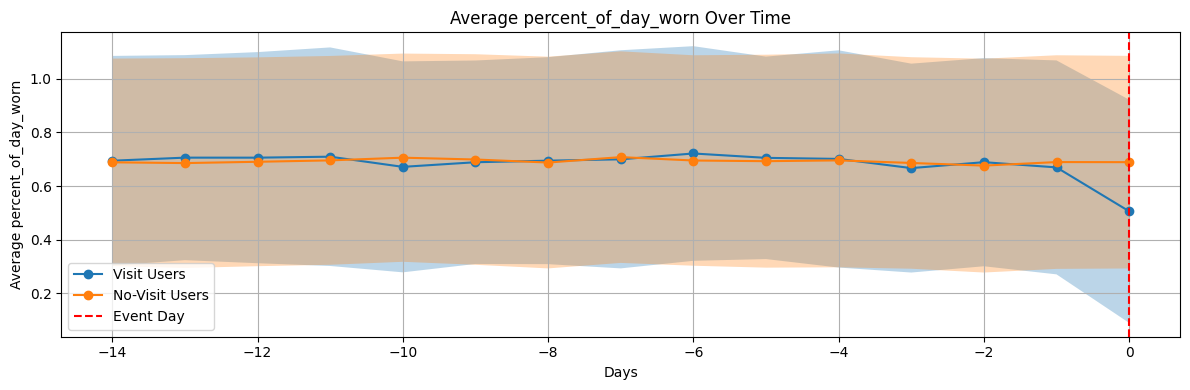

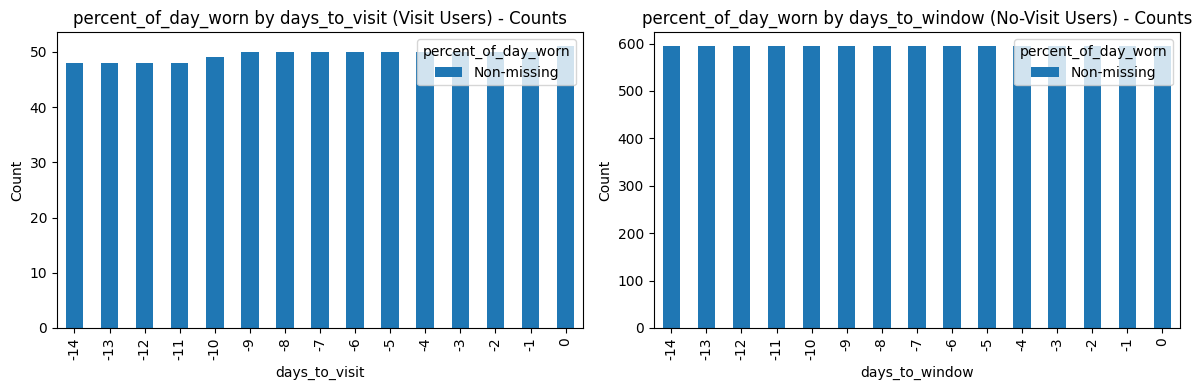

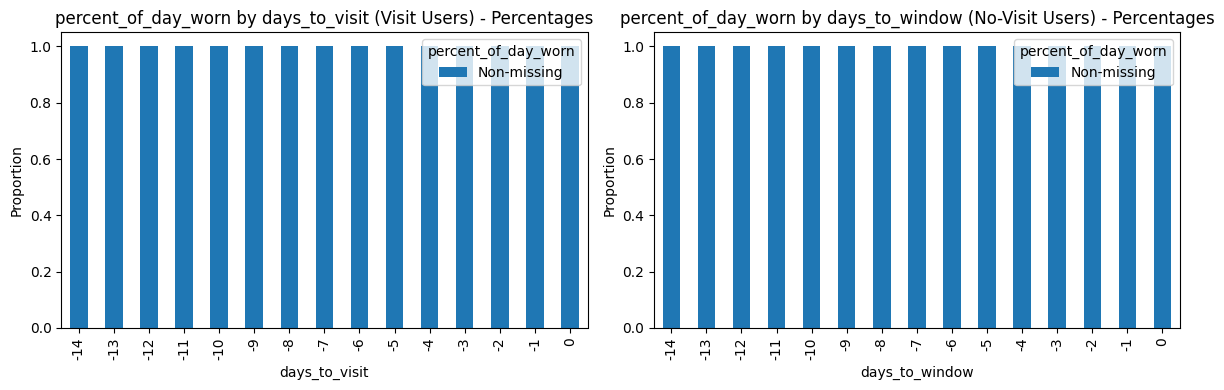

In [173]:
plot_feature_comparison(two_week_visit, two_week, 'percent_of_day_worn', bin_continuous=True)

In [174]:
two_week_visit_app = two_week_visit[two_week_visit['study_group'] != 'No App']
two_week_app = two_week[two_week['study_group'] != 'No App']

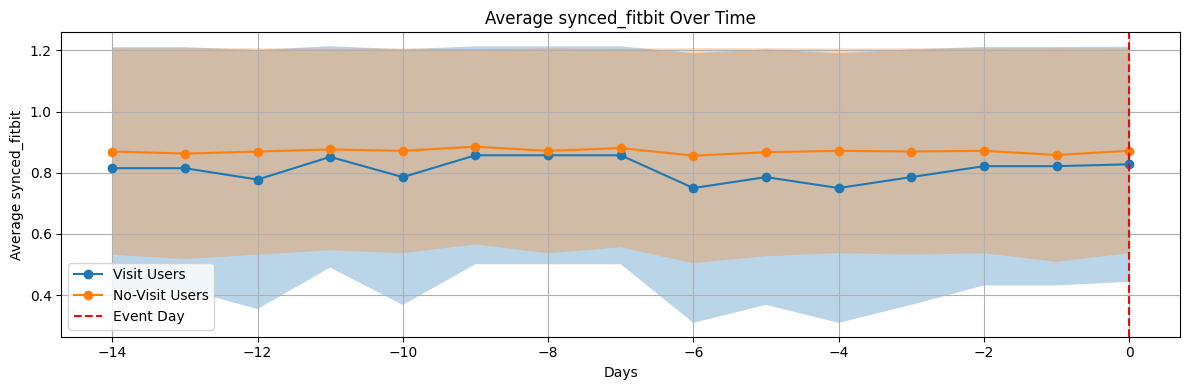

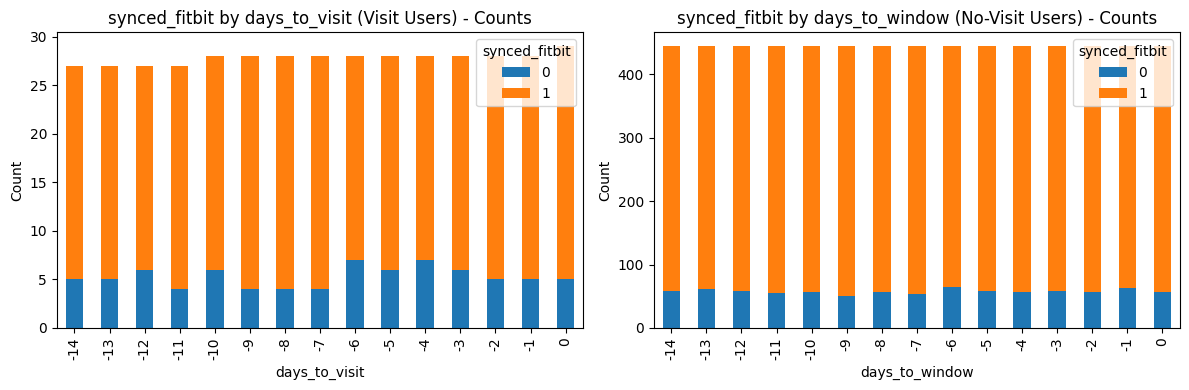

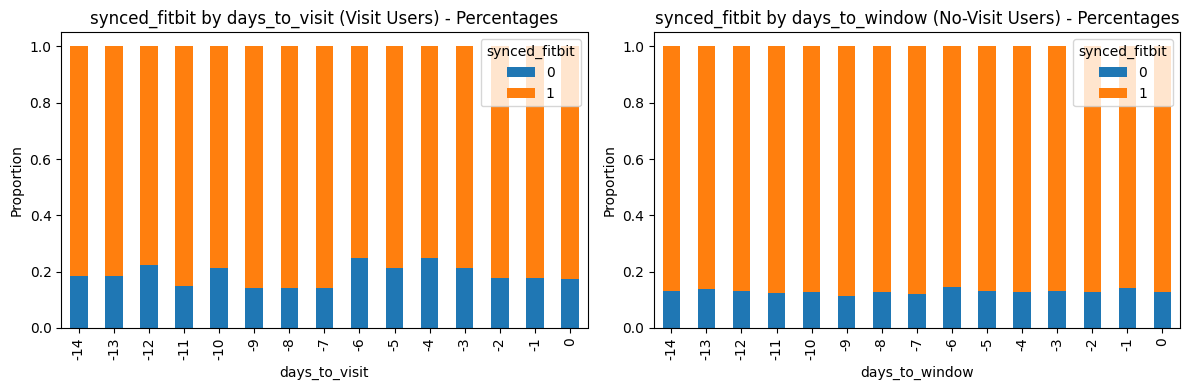

In [175]:
plot_feature_comparison(two_week_visit_app, two_week_app, 'synced_fitbit', bin_continuous=False)

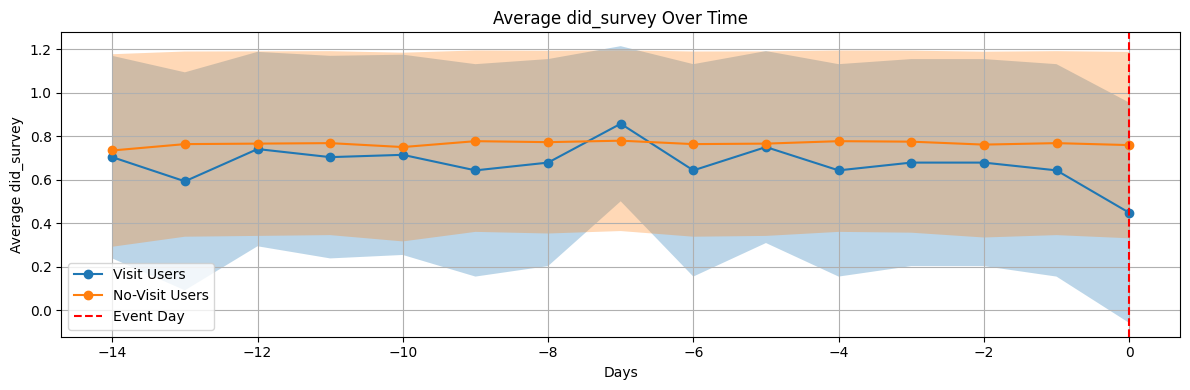

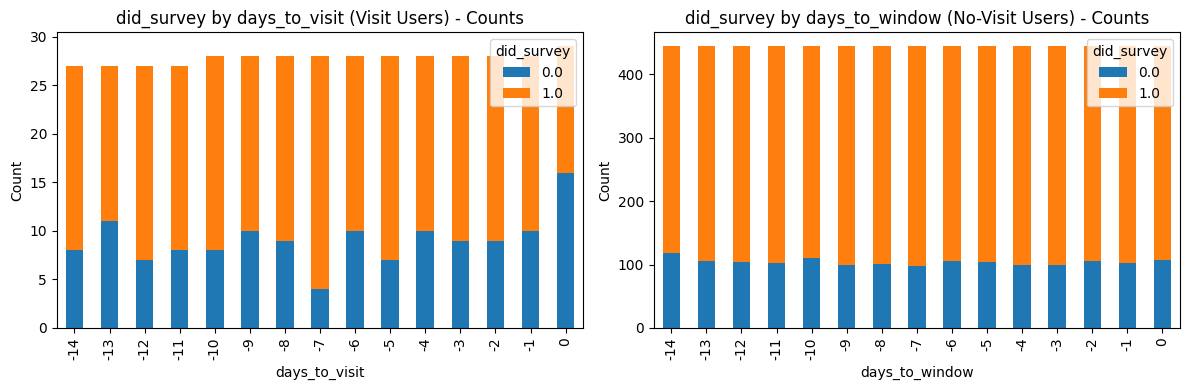

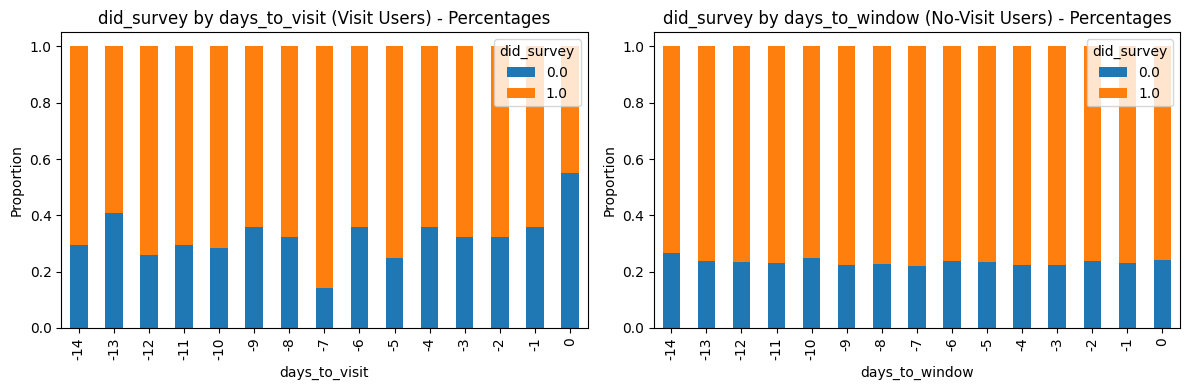

In [176]:
plot_feature_comparison(two_week_visit_app, two_week_app, 'did_survey', bin_continuous=False)

## 3) Additional Things to Try

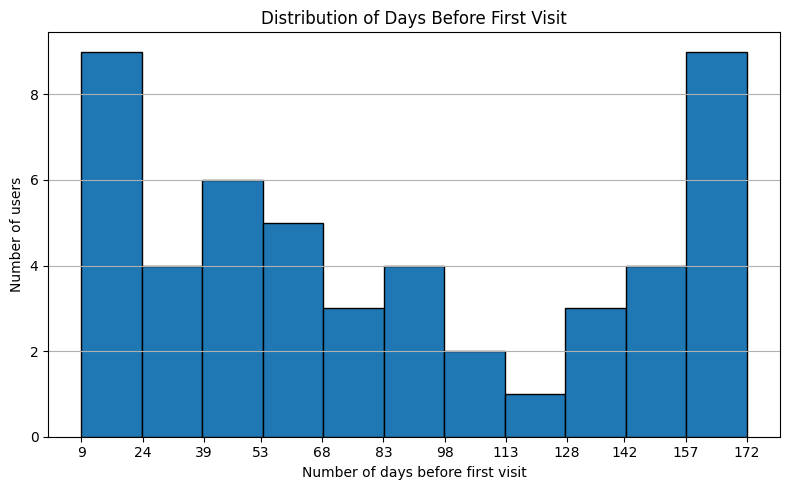

In [52]:
users_with_visit = full_fb_data[full_fb_data['has_visit'] == 1]
first_visit_days = users_with_visit[users_with_visit['visit_day'] == 1].groupby('fitbit_user_id')['days'].min()
merged = users_with_visit.merge(first_visit_days.rename('first_visit_day'), on='fitbit_user_id')
pre_visit = merged[merged['days'] < merged['first_visit_day']]
days_before_counts = pre_visit.groupby('fitbit_user_id').size()
n_bins = 11
min_val, max_val = days_before_counts.min(), days_before_counts.max()
bins = np.linspace(min_val, max_val, n_bins + 1)
plt.figure(figsize=(8, 5))
plt.hist(days_before_counts, bins=bins, edgecolor='black')
plt.xlabel("Number of days before first visit")
plt.ylabel("Number of users")
plt.title("Distribution of Days Before First Visit")
plt.xticks(np.round(bins))  # Rounded ticks for clarity
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [53]:
# checking hr
def check_hr(df, thresh):
  count = 0
  users = []
  user_count = 0

  for user_id, group in df.groupby('fitbit_user_id'):

    for r in group['heart']:

      if r > thresh:
        # print(str(user_id) + ' hr: ' + str(r))
        count += 1

        if user_id not in users:
          users.append(user_id)
          user_count += 1

  return count, user_count, users

In [54]:
check_hr(three_week_visit, 80)

(95, 7, [7, 28, 67, 126, 181, 215, 272])

In [55]:
check_hr(three_week, 80)

(441,
 20,
 [12,
  48,
  74,
  89,
  95,
  99,
  110,
  112,
  115,
  133,
  137,
  162,
  186,
  189,
  210,
  222,
  274,
  287,
  293,
  305])

In [56]:
check_hr(three_week_visit, 70)

(279,
 22,
 [7,
  28,
  32,
  49,
  67,
  103,
  105,
  126,
  156,
  158,
  180,
  181,
  192,
  196,
  198,
  215,
  218,
  227,
  257,
  267,
  272,
  284])

In [57]:
check_hr(three_week, 70)

(2998,
 79,
 [9,
  12,
  14,
  20,
  26,
  31,
  33,
  35,
  36,
  39,
  47,
  48,
  50,
  55,
  56,
  62,
  63,
  74,
  77,
  87,
  89,
  90,
  95,
  99,
  101,
  106,
  110,
  112,
  115,
  123,
  125,
  132,
  133,
  136,
  137,
  142,
  143,
  144,
  145,
  146,
  148,
  157,
  162,
  165,
  167,
  170,
  171,
  173,
  175,
  184,
  186,
  188,
  189,
  191,
  195,
  197,
  199,
  203,
  210,
  219,
  222,
  224,
  229,
  233,
  236,
  239,
  252,
  265,
  266,
  268,
  274,
  278,
  287,
  291,
  293,
  301,
  302,
  303,
  305])

## 4) Looking at Random Visit Windows

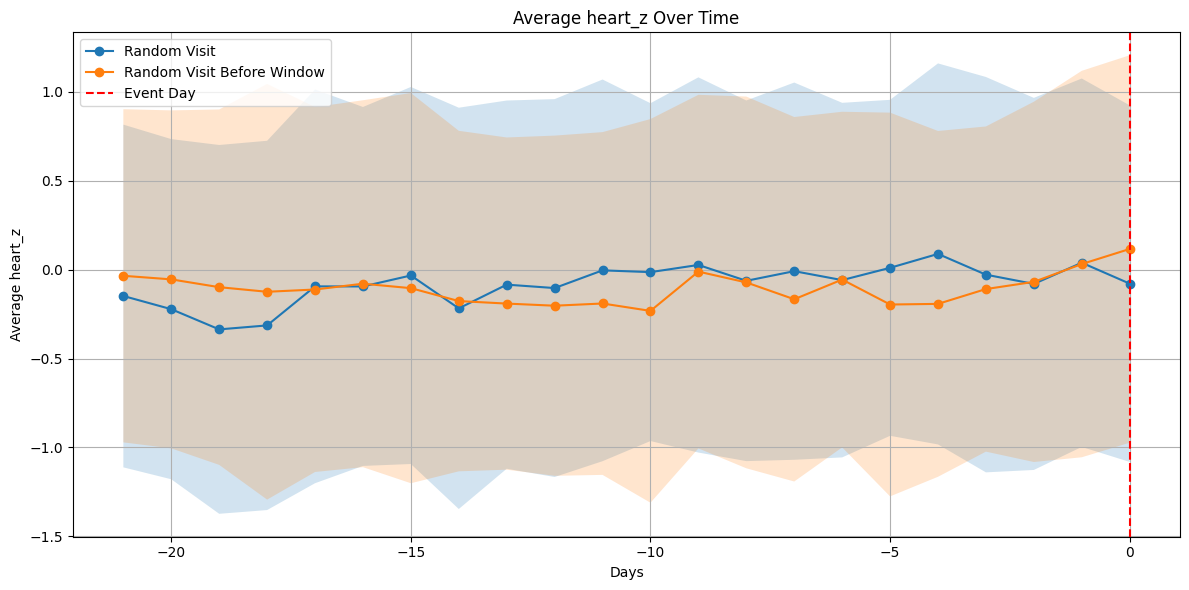

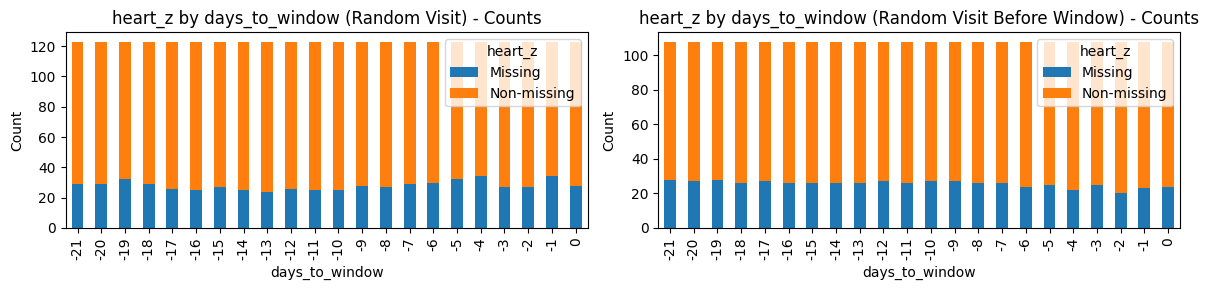

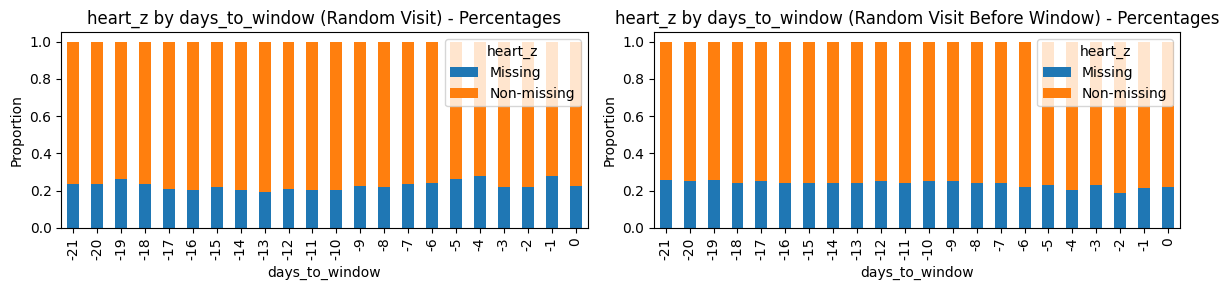

In [63]:
plot_feature_comparison(three_week_visit_random, three_week_visit_random_window, 'heart_z', time_col1='days_to_window', time_col2='days_to_window', label1='Random Visit', label2='Random Visit Before Window', bin_continuous = True)

In [45]:
three_week_visit_heart = drop_nan_user(three_week_visit, 'heart_z')
three_week_heart = drop_nan_user(three_week, 'heart_z')
three_week_visit_random_heart = drop_nan_user(three_week_visit_random, 'heart_z')
three_week_visit_random_window_heart = drop_nan_user(three_week_visit_random_window, 'heart_z')

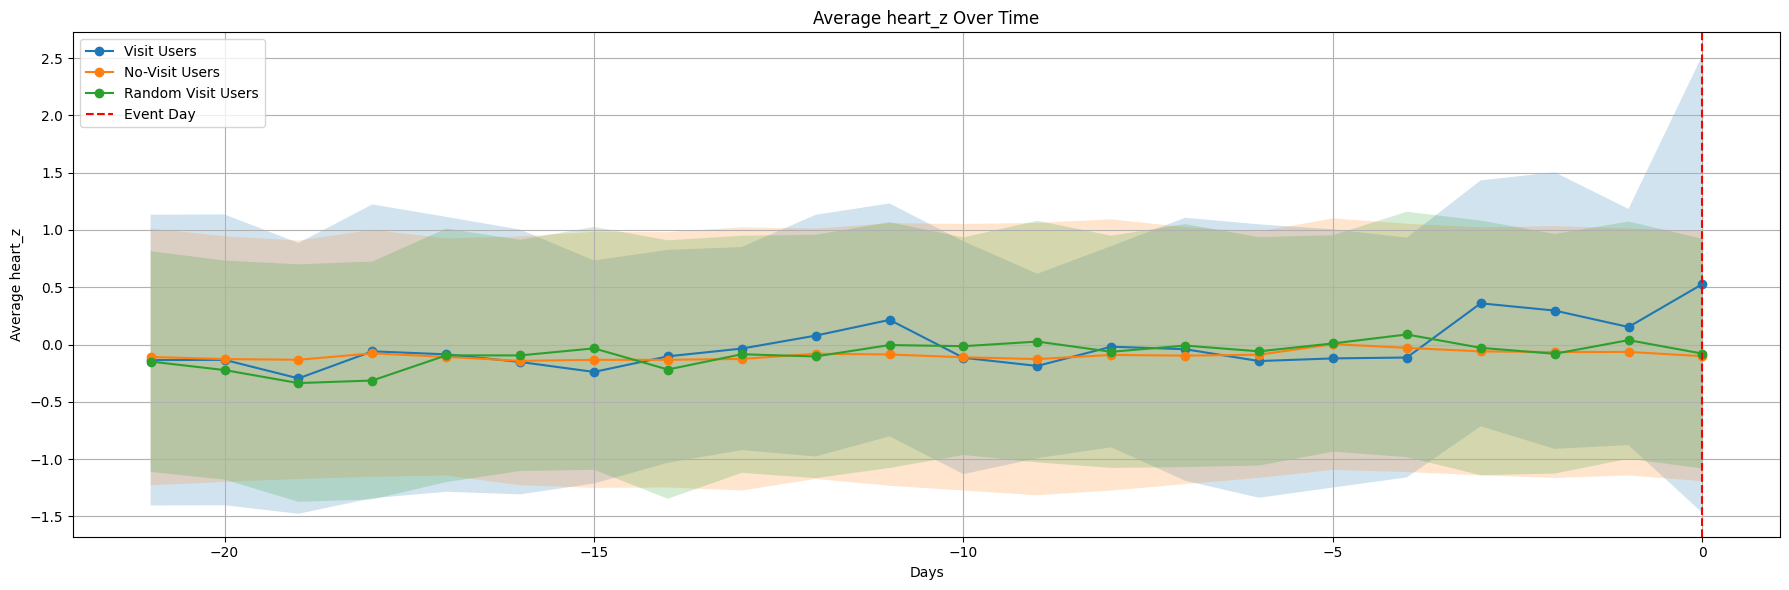

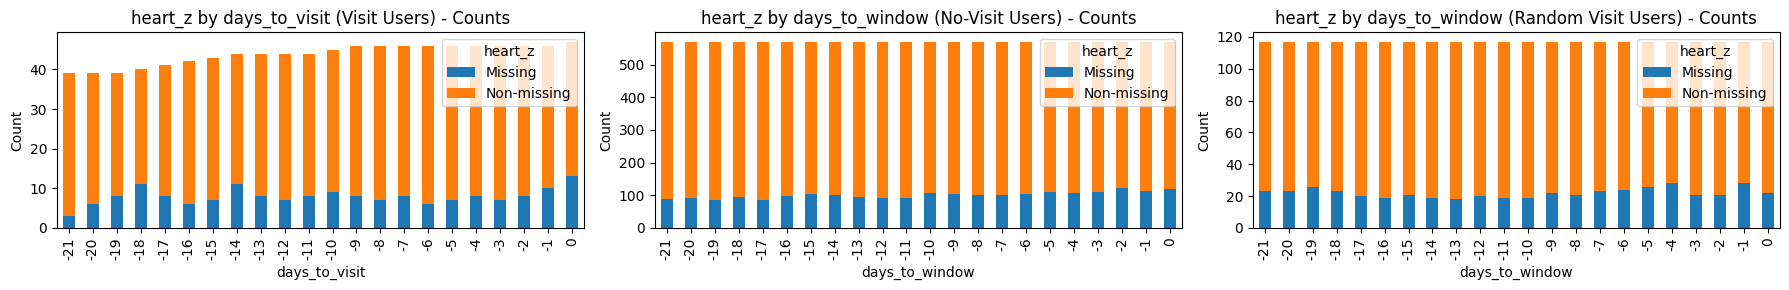

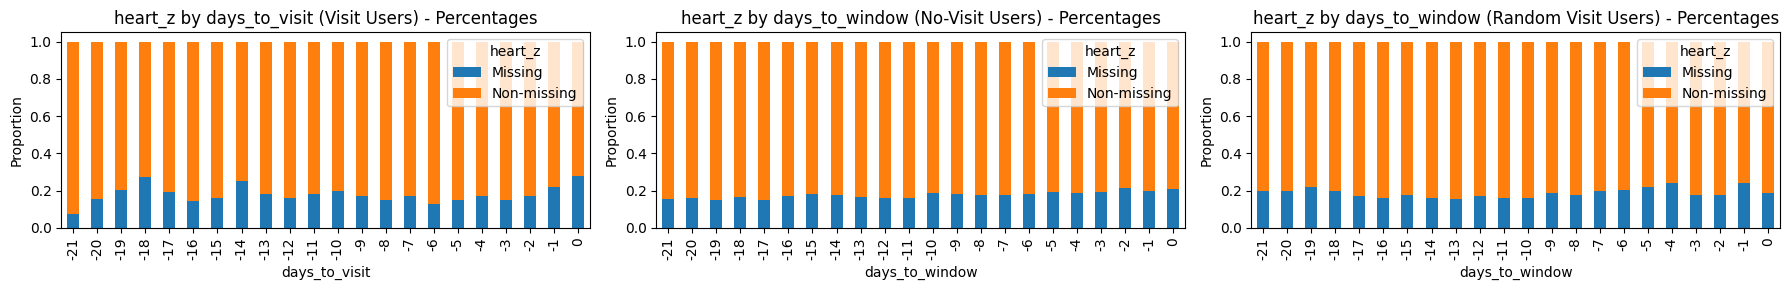

In [46]:
plot_feature_comparison_3(three_week_visit_heart, three_week_heart, three_week_visit_random_heart, 'heart_z', bin_continuous = True)

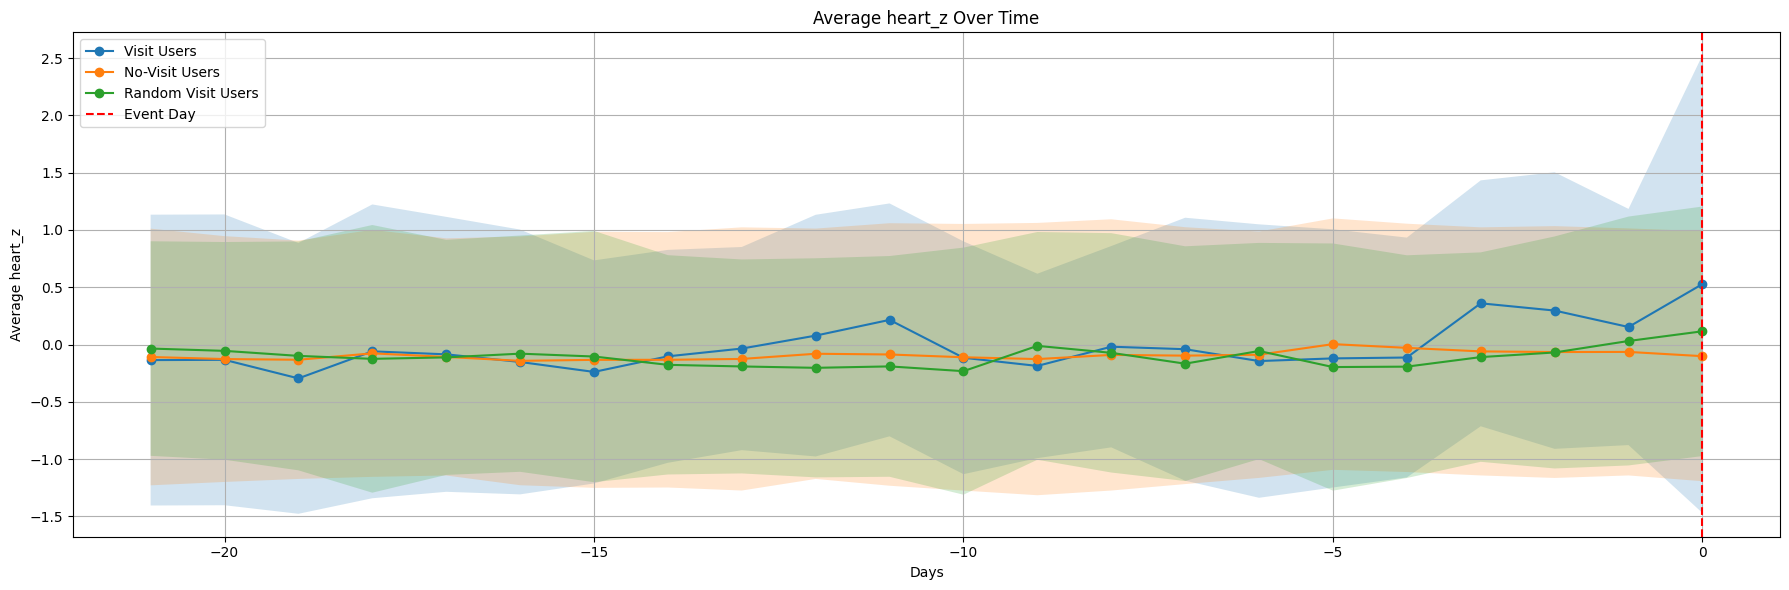

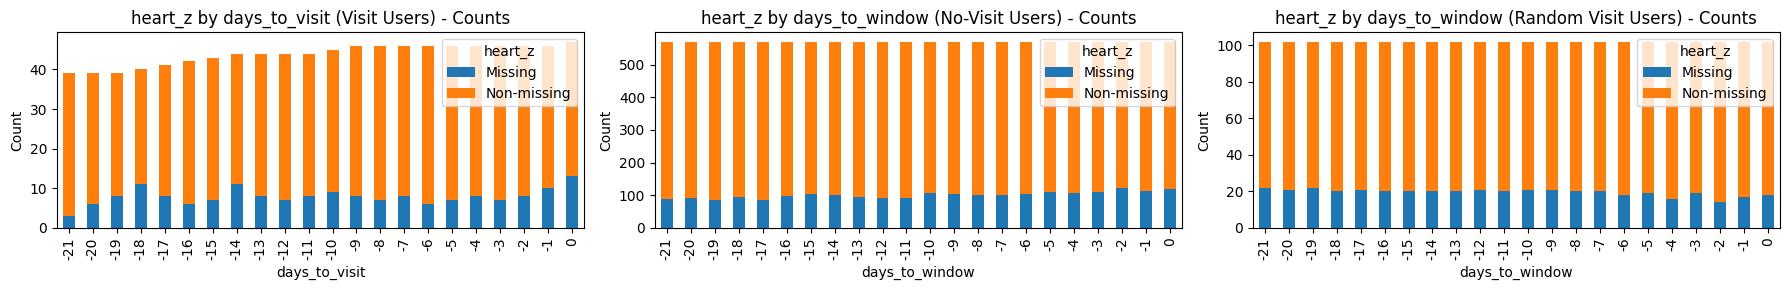

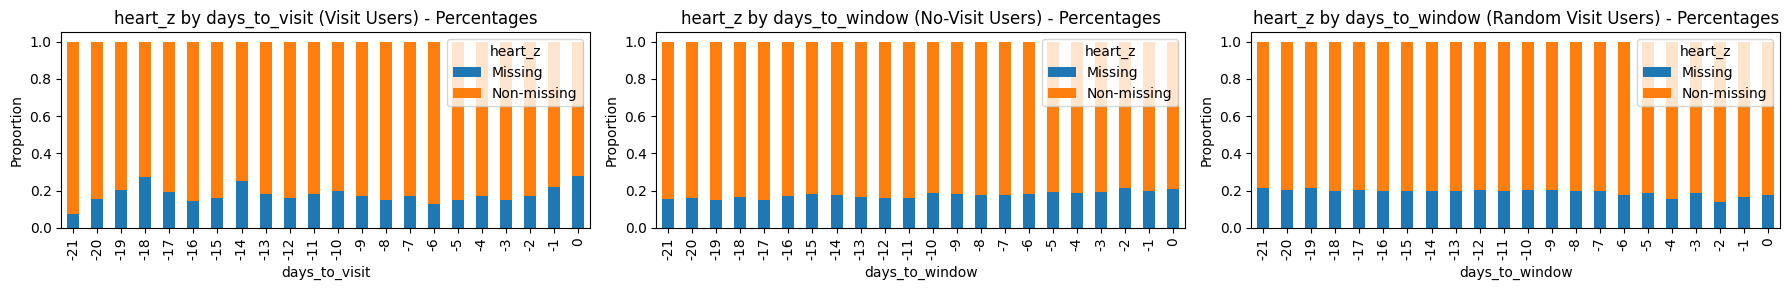

In [47]:
plot_feature_comparison_3(three_week_visit_heart, three_week_heart, three_week_visit_random_window_heart, 'heart_z', bin_continuous = True)

In [214]:
three_week_visit_symptoms = drop_nan_user(three_week_visit, 'symptoms')
three_week_symptoms = drop_nan_user(three_week, 'symptoms')
three_week_visit_random_symptoms = drop_nan_user(three_week_visit_random, 'symptoms')
three_week_visit_random_window_symptoms = drop_nan_user(three_week_visit_random_window, 'symptoms')

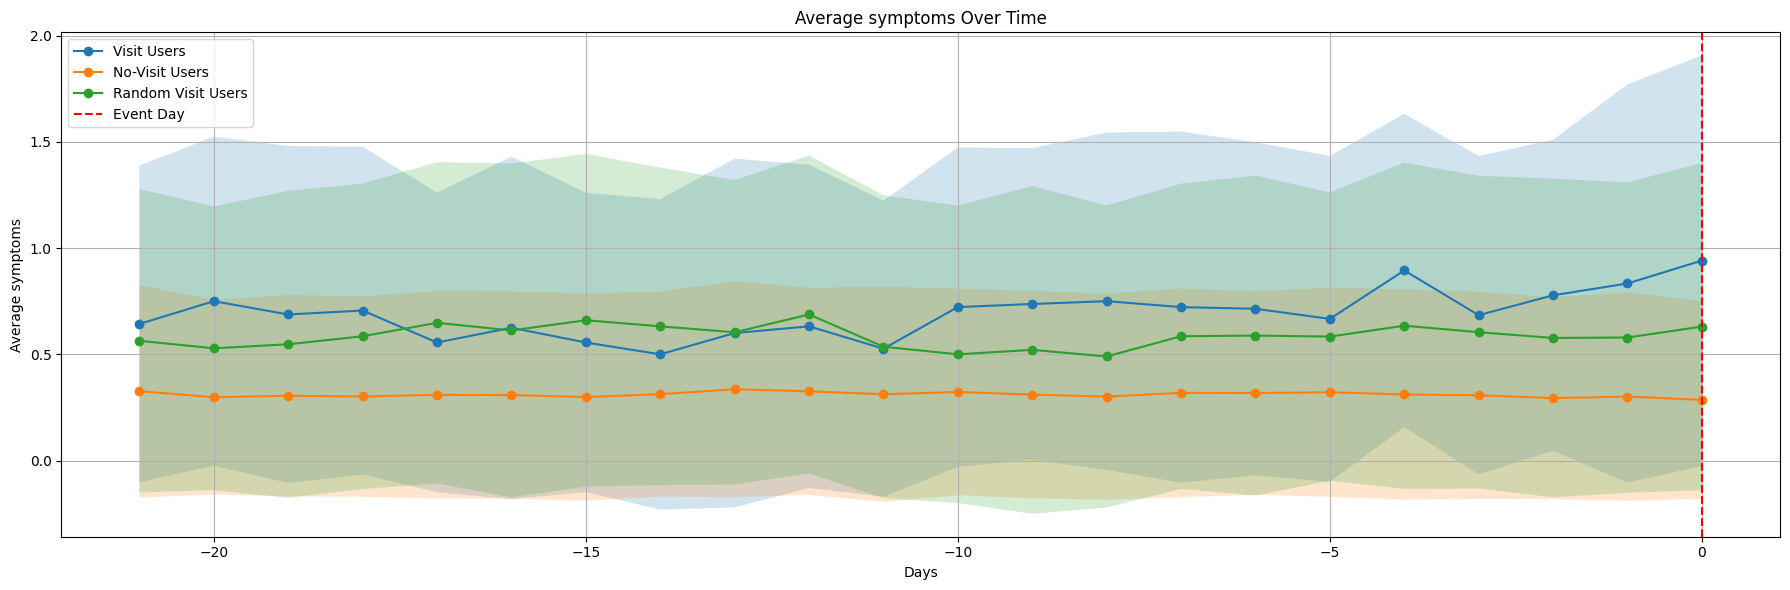

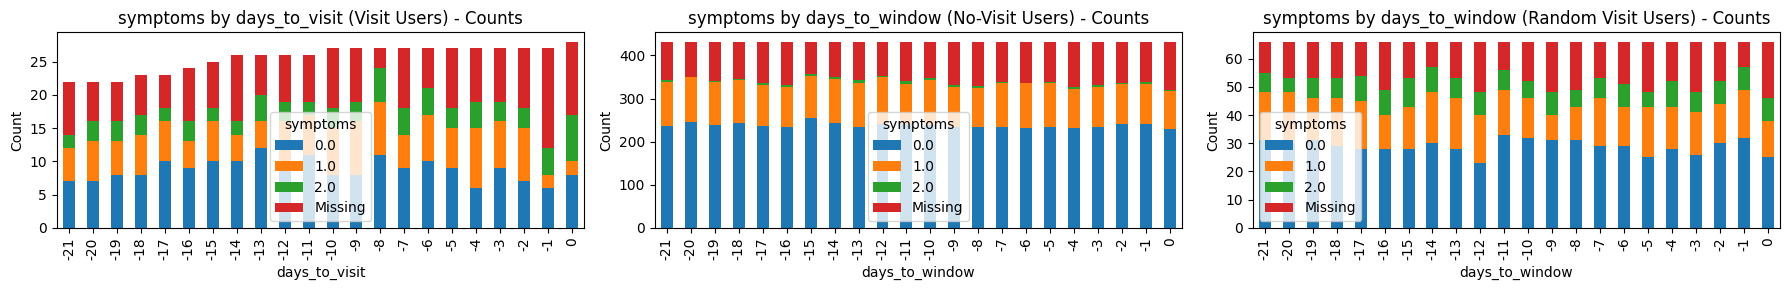

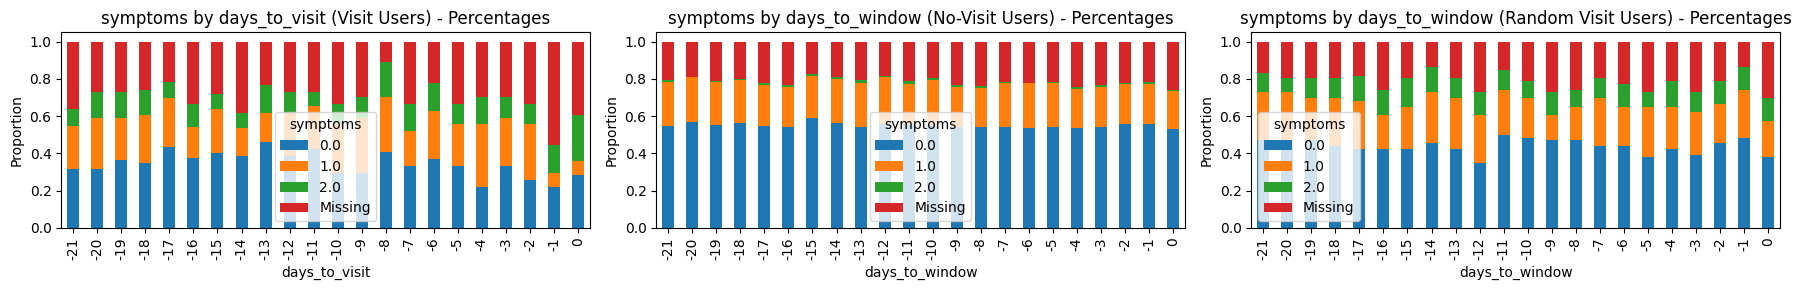

In [215]:
plot_feature_comparison_3(three_week_visit_symptoms, three_week_symptoms, three_week_visit_random_symptoms, 'symptoms', bin_continuous = False)

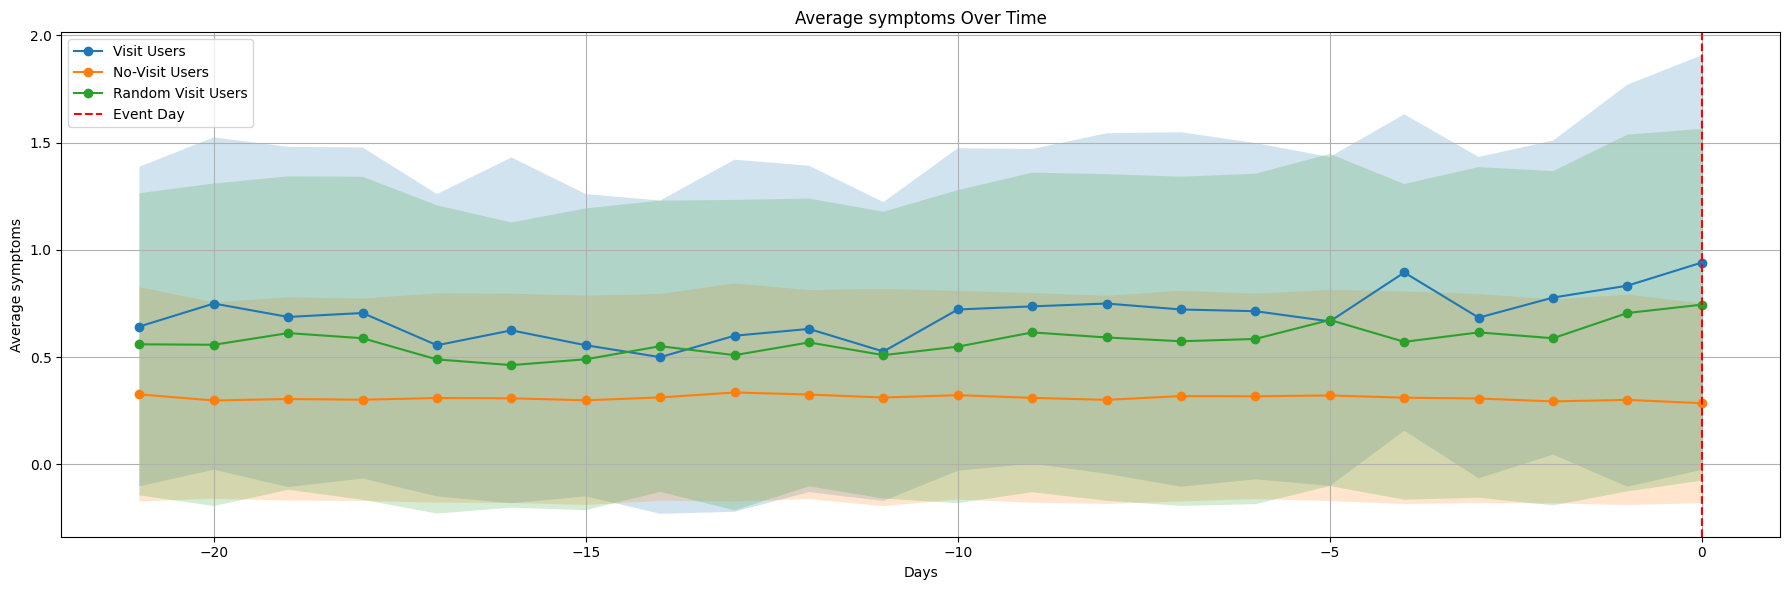

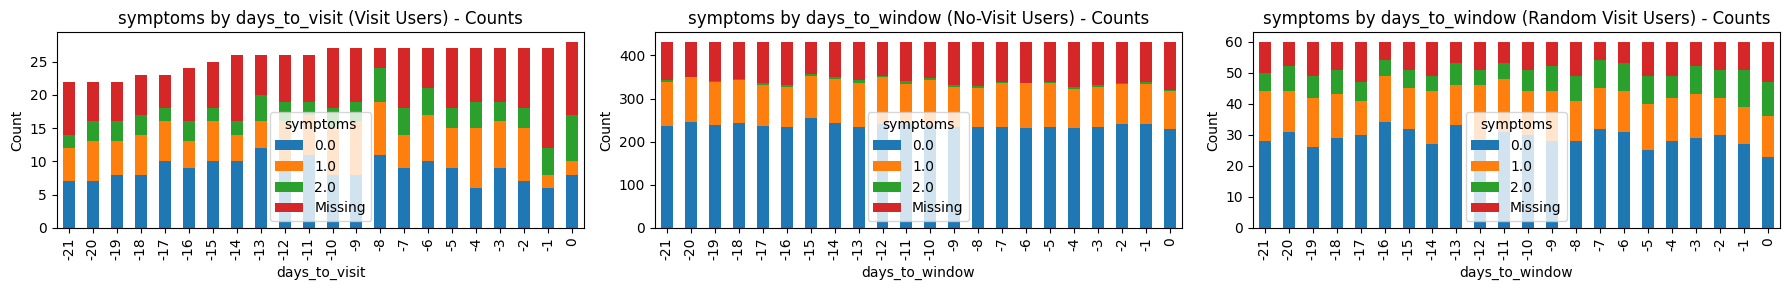

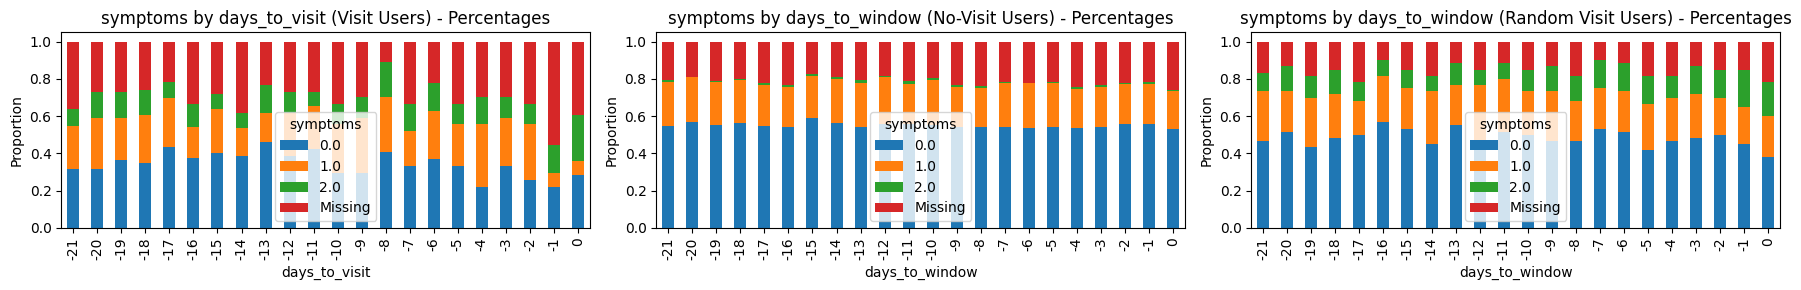

In [216]:
plot_feature_comparison_3(three_week_visit_symptoms, three_week_symptoms, three_week_visit_random_window_symptoms, 'symptoms', bin_continuous = False)

## 5) Focusing in on last 5 days

In [239]:
visit_3wk_subset = three_week_visit[three_week_visit['days_to_visit'].between(-5, 0)]
random_visit_3wk_subset = three_week_visit_random[three_week_visit_random['days_to_window'].between(-5, 0)]
random_window_visit_3wk_subset = three_week_visit_random_window[three_week_visit_random_window['days_to_window'].between(-5, 0)]

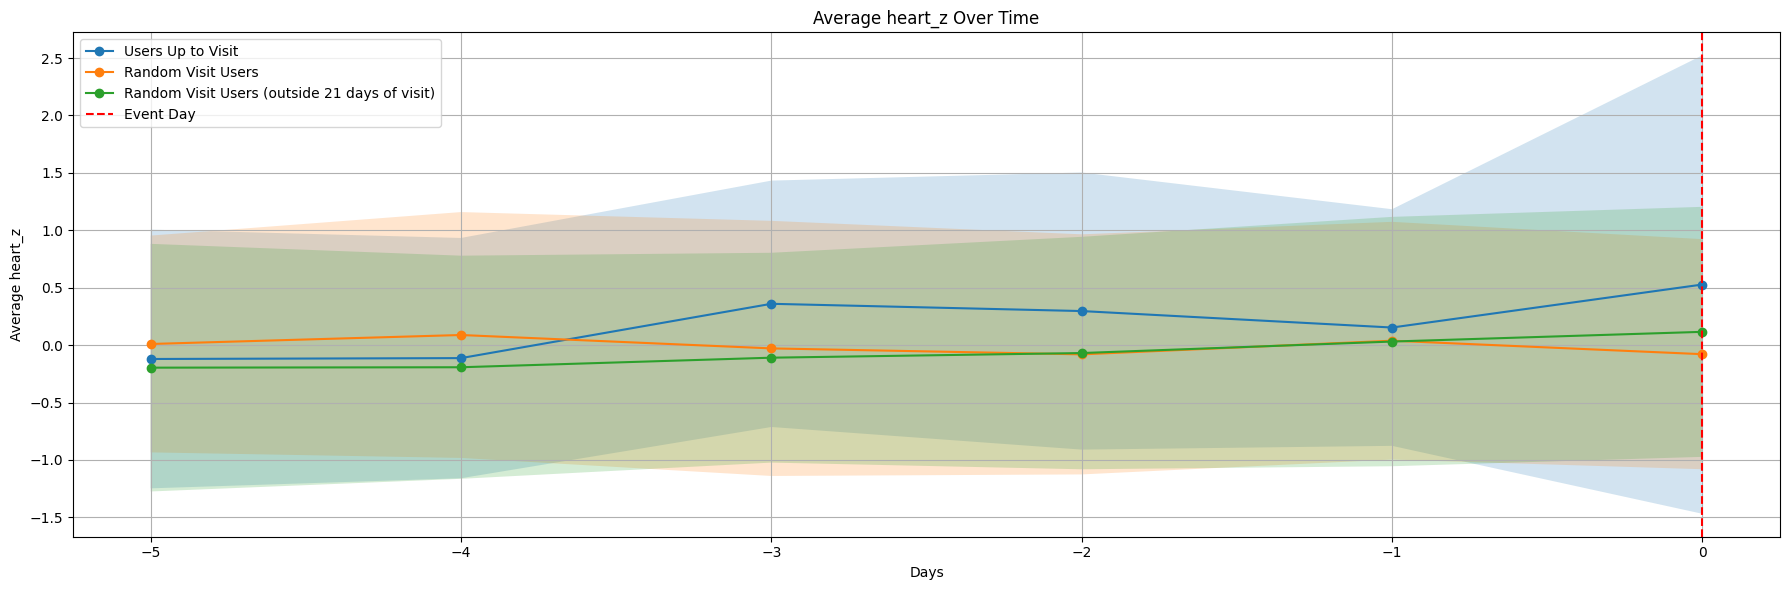

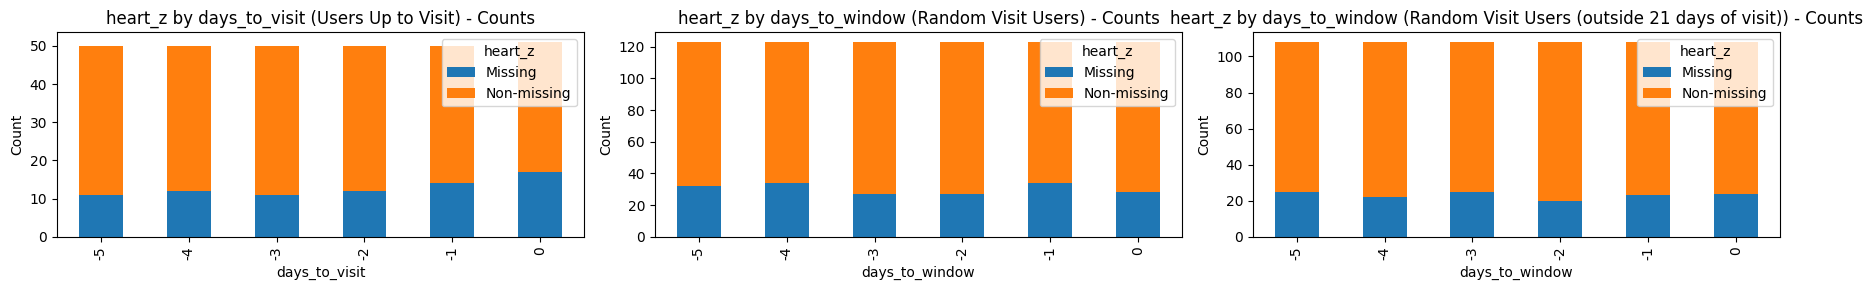

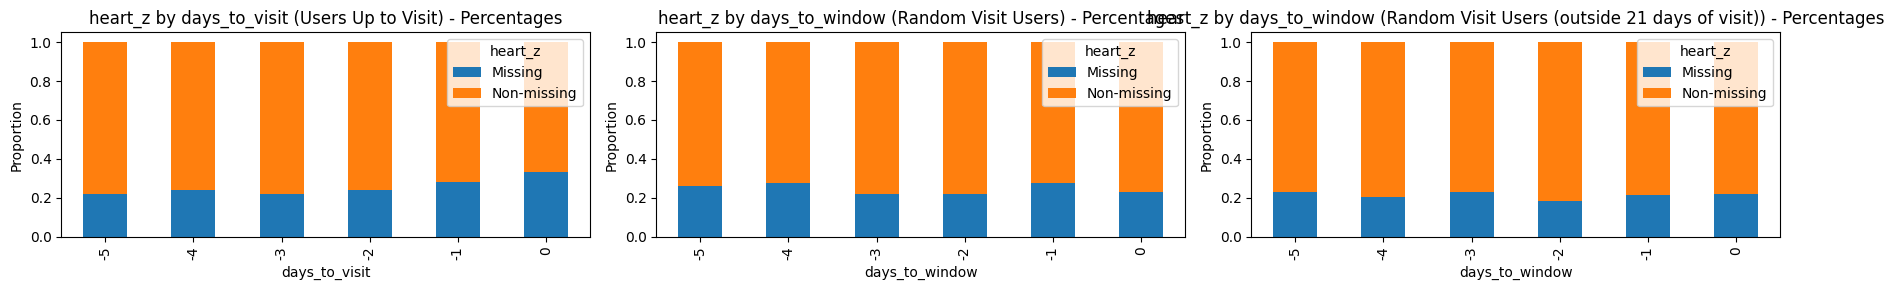

In [241]:
plot_feature_comparison_3(visit_3wk_subset, random_visit_3wk_subset, random_window_visit_3wk_subset, 'heart_z', label1='Users Up to Visit', label2='Random Visit Users', label3='Random Visit Users (outside 21 days of visit)', bin_continuous=True)

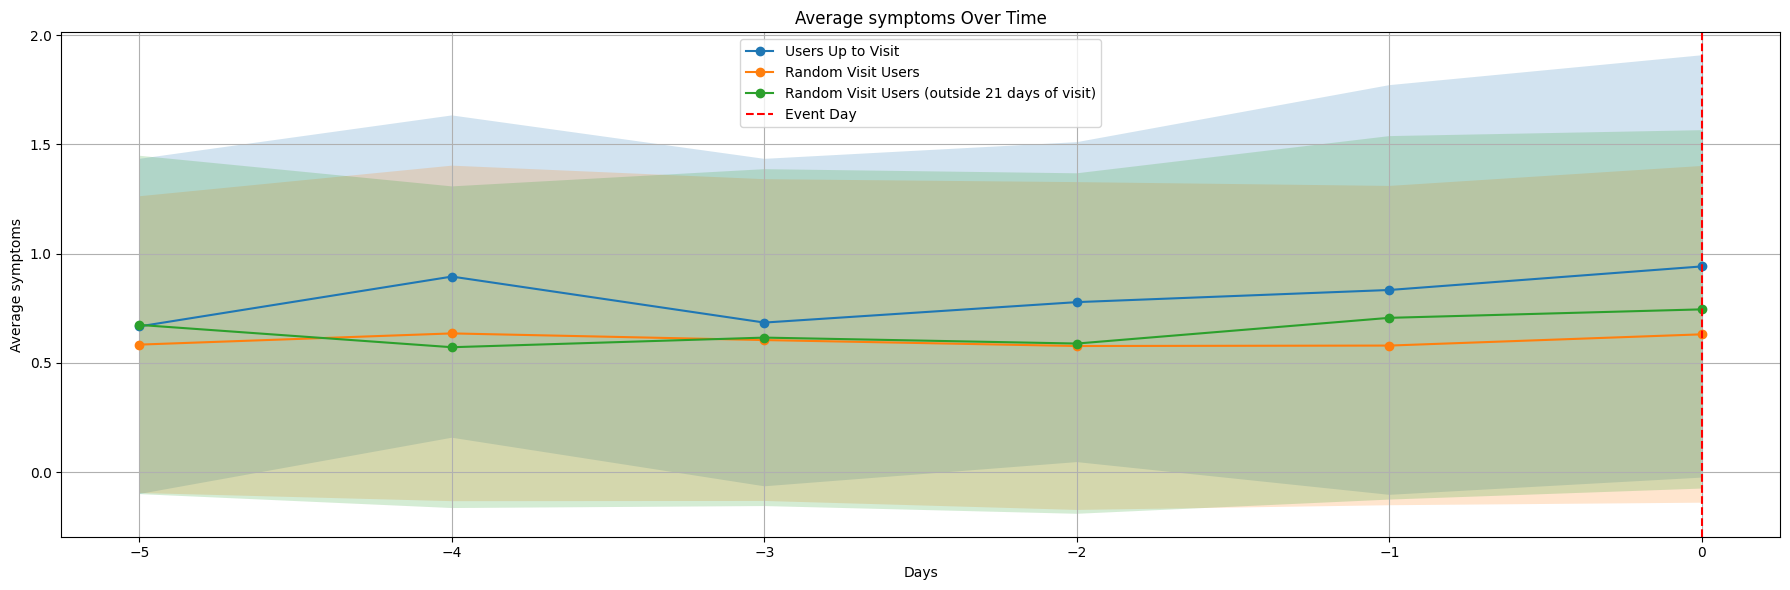

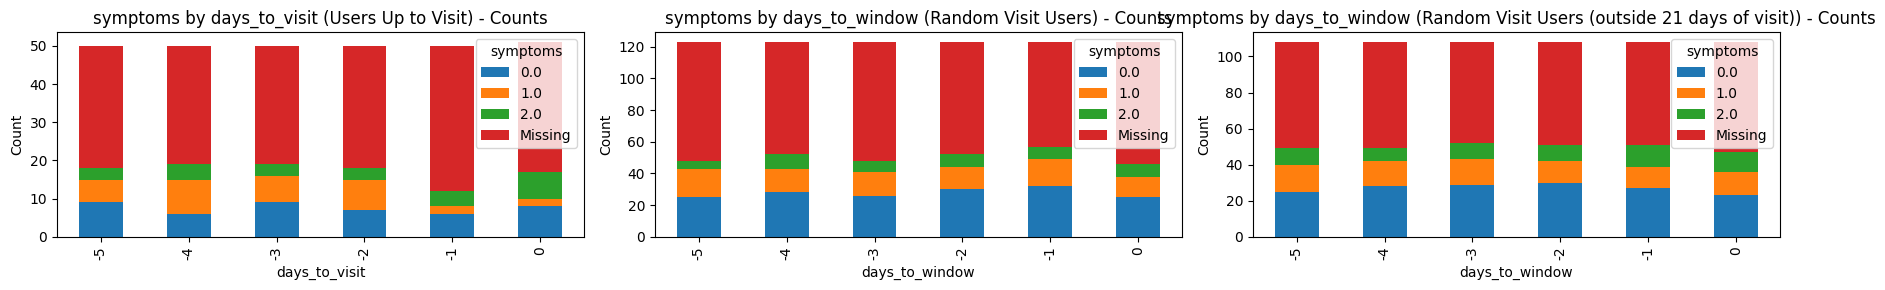

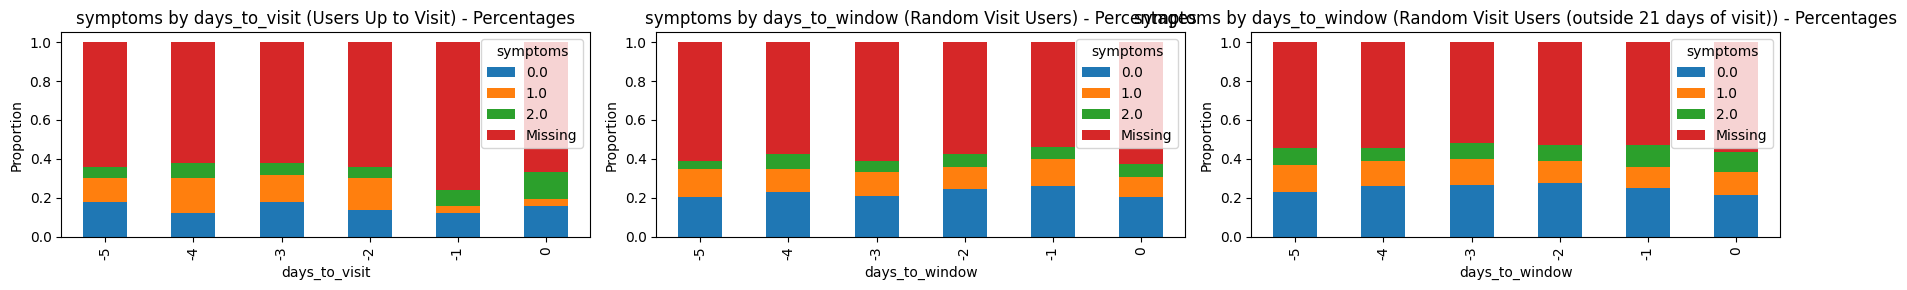

In [242]:
plot_feature_comparison_3(visit_3wk_subset, random_visit_3wk_subset, random_window_visit_3wk_subset, 'symptoms', label1='Users Up to Visit', label2='Random Visit Users', label3='Random Visit Users (outside 21 days of visit)', bin_continuous=False)

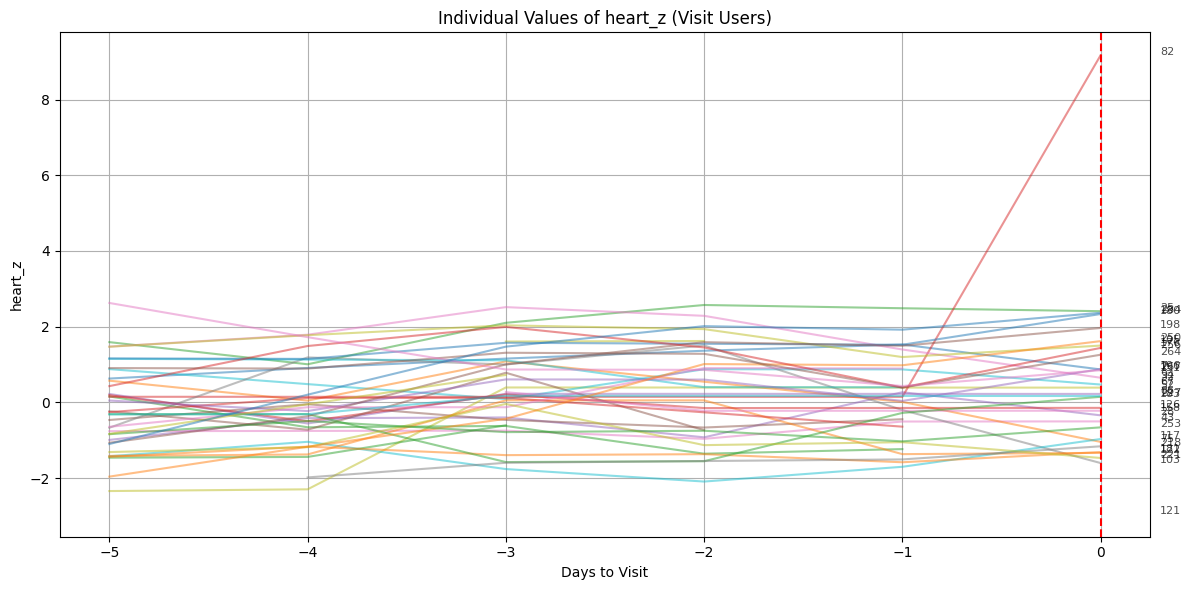

In [249]:
plot_individual_trajectories(visit_3wk_subset, 'heart_z')

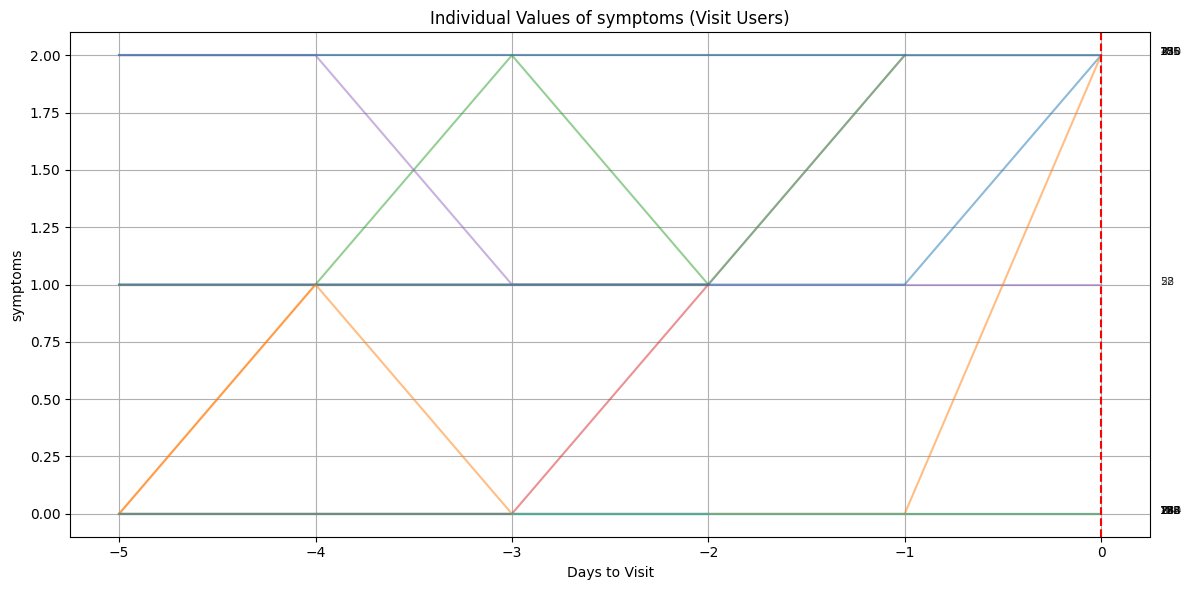

In [252]:
plot_individual_trajectories(visit_3wk_subset, 'symptoms')

In [256]:
visit_3wk_subset = visit_3wk_subset[visit_3wk_subset['fitbit_user_id'] != 82]
random_visit_3wk_subset = random_visit_3wk_subset[random_visit_3wk_subset['fitbit_user_id'] != 82]
random_window_visit_3wk_subset = random_window_visit_3wk_subset[random_window_visit_3wk_subset['fitbit_user_id'] != 82]

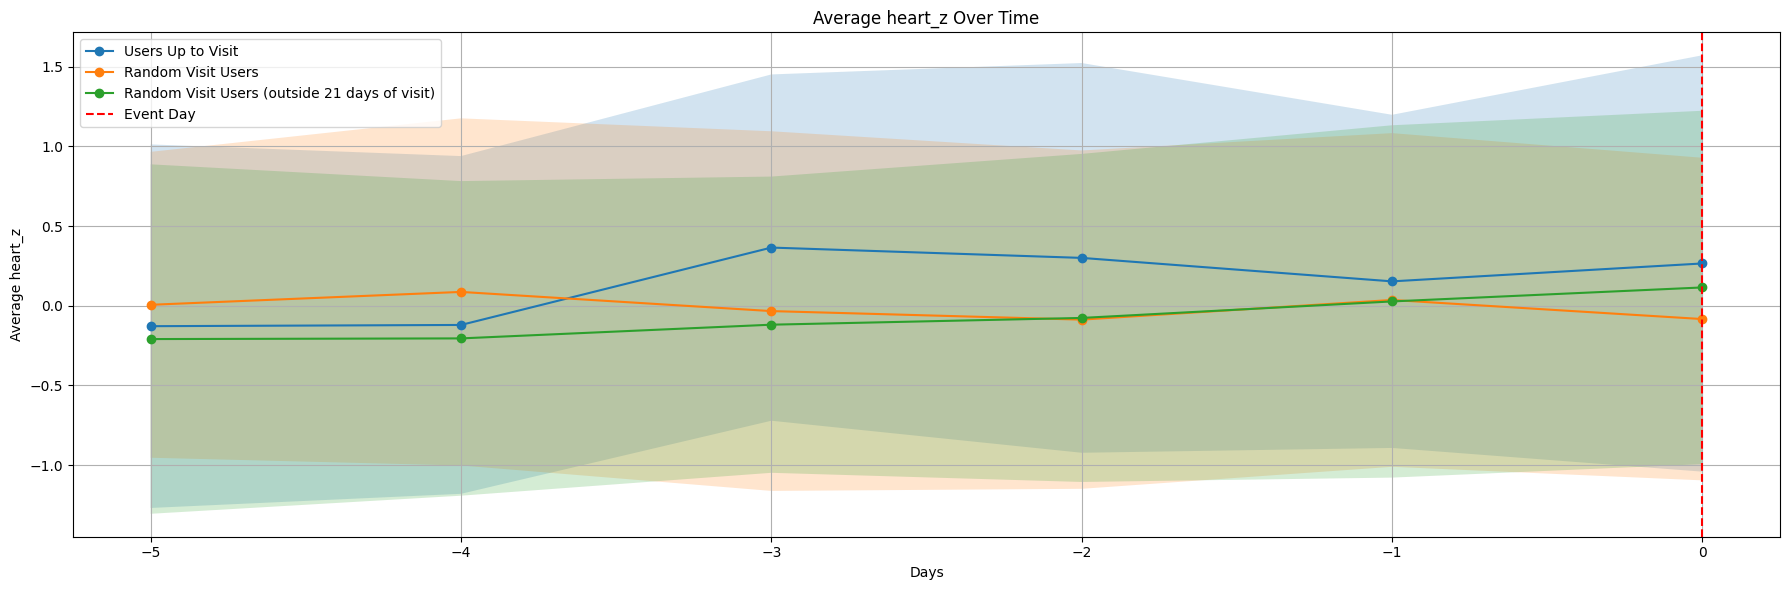

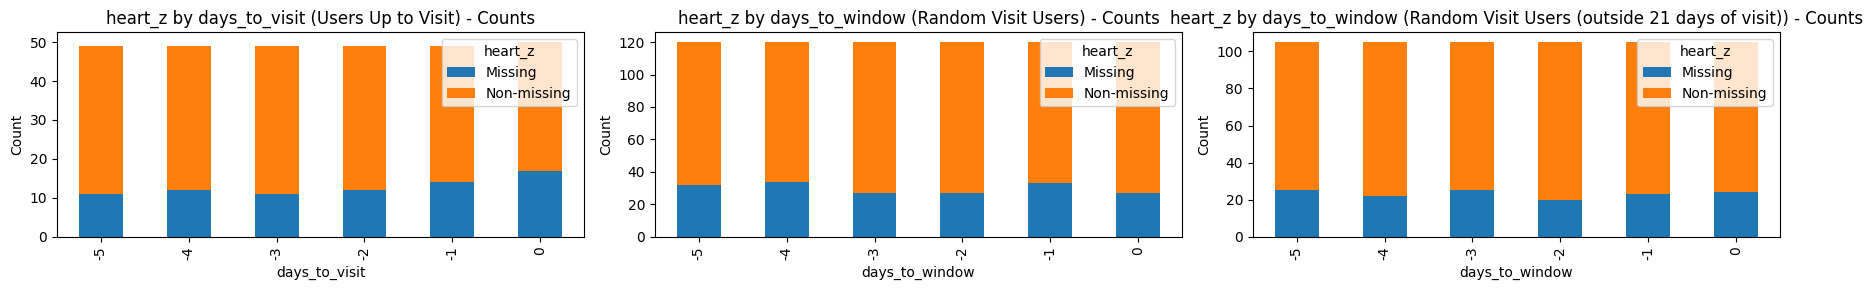

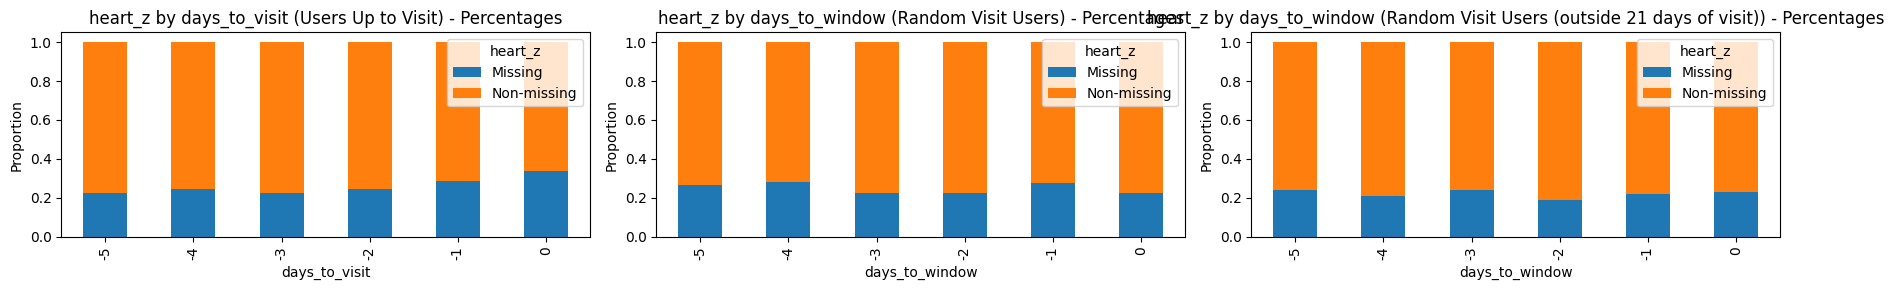

In [257]:
plot_feature_comparison_3(visit_3wk_subset, random_visit_3wk_subset, random_window_visit_3wk_subset, 'heart_z', label1='Users Up to Visit', label2='Random Visit Users', label3='Random Visit Users (outside 21 days of visit)', bin_continuous=True)

## 6) Fixing Things

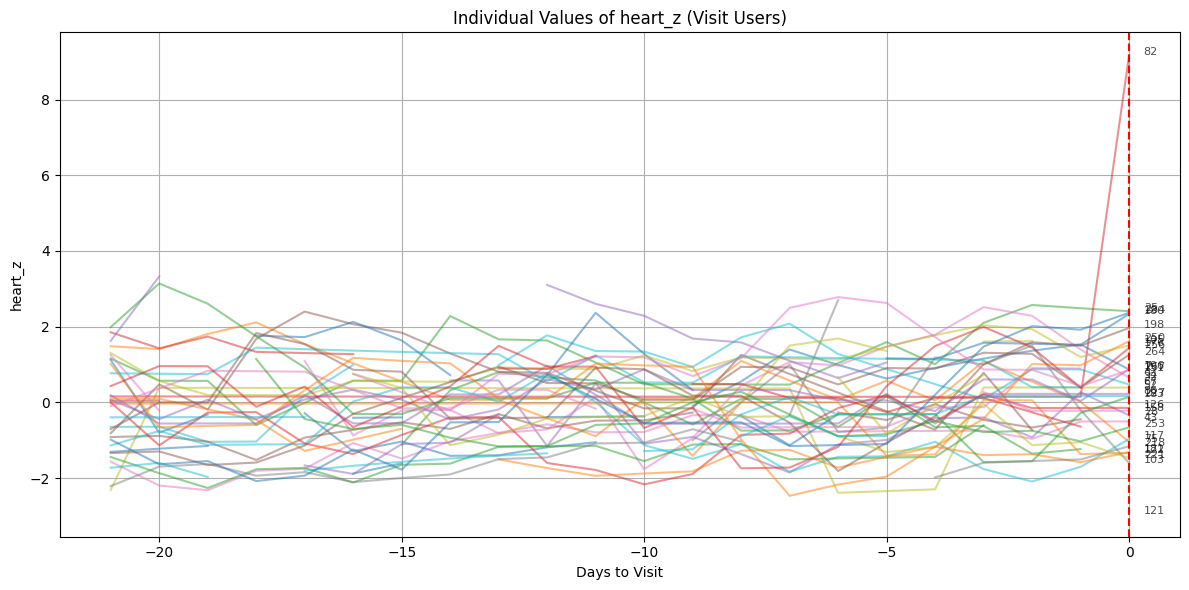

In [41]:
plot_individual_trajectories(three_week_visit, 'heart_z')

In [116]:
z_fb_data.to_csv('z_fb_data.csv', index=False)
files.download('z_fb_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [113]:
three_week_visit.to_csv('three_week_visit.csv', index=False)
files.download('three_week_visit.csv')

three_week_visit_random.to_csv('three_week_visit_r.csv', index=False)
files.download('three_week_visit_r.csv')

three_week_visit_random_window.to_csv('three_week_visit_rw.csv', index=False)
files.download('three_week_visit_rw.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
def get_top_3_per_day(df, feature, time_col='days_to_visit'):
    top_rows = (
        df.dropna(subset=[feature])  # ensure valid feature values
          .sort_values(by=[time_col, feature], ascending=[True, False])  # sort by day then feature
          .groupby(time_col)
          .head(3)  # take top 3 for each day
          .loc[:, ['fitbit_user_id', time_col, feature]]
          .reset_index(drop=True)
    )
    return top_rows

In [94]:
three_week_visit = extract_days_before_visit(z_fb_data, days_before=21)
three_week = extract_days_no_visits(z_fb_data, window_days=22)
three_week_visit_random = extract_random_days_before_visit(z_fb_data, days_before=22, seed=23)
three_week_visit_random_window = extract_random_days_before_visit(z_fb_data, days_before=22, exclude_window_before_visit=True, seed=23)

In [64]:
def set_value_to_nan(df, user_id, day_val, feature, time_col='days_to_visit'):

    df_modified = df.copy()

    mask = (
        (df_modified['fitbit_user_id'] == user_id) &
        (df_modified[time_col] == day_val)
    )

    df_modified.loc[mask, feature] = np.nan

    return df_modified

In [67]:
get_top_3_per_day(three_week_visit, 'heart_z')

fitbit_user_id  days_to_visit   heart_z
0              183            -21  1.986715
1              192            -21  1.850677
2              180            -21  1.801177
3              257            -20  3.326087
4              183            -20  3.140244
..             ...            ...       ...
61             284             -1  1.919145
62               7             -1  1.527004
63              25              0  2.407903
64             284              0  2.366245
65             180              0  2.333452

[66 rows x 3 columns]

In [74]:
three_week_visit = set_value_to_nan(three_week_visit, 82, 0, 'heart_z')
three_week_visit = set_value_to_nan(three_week_visit, 257, -11, 'heart_z')
three_week_visit = set_value_to_nan(three_week_visit, 257, -12, 'heart_z')

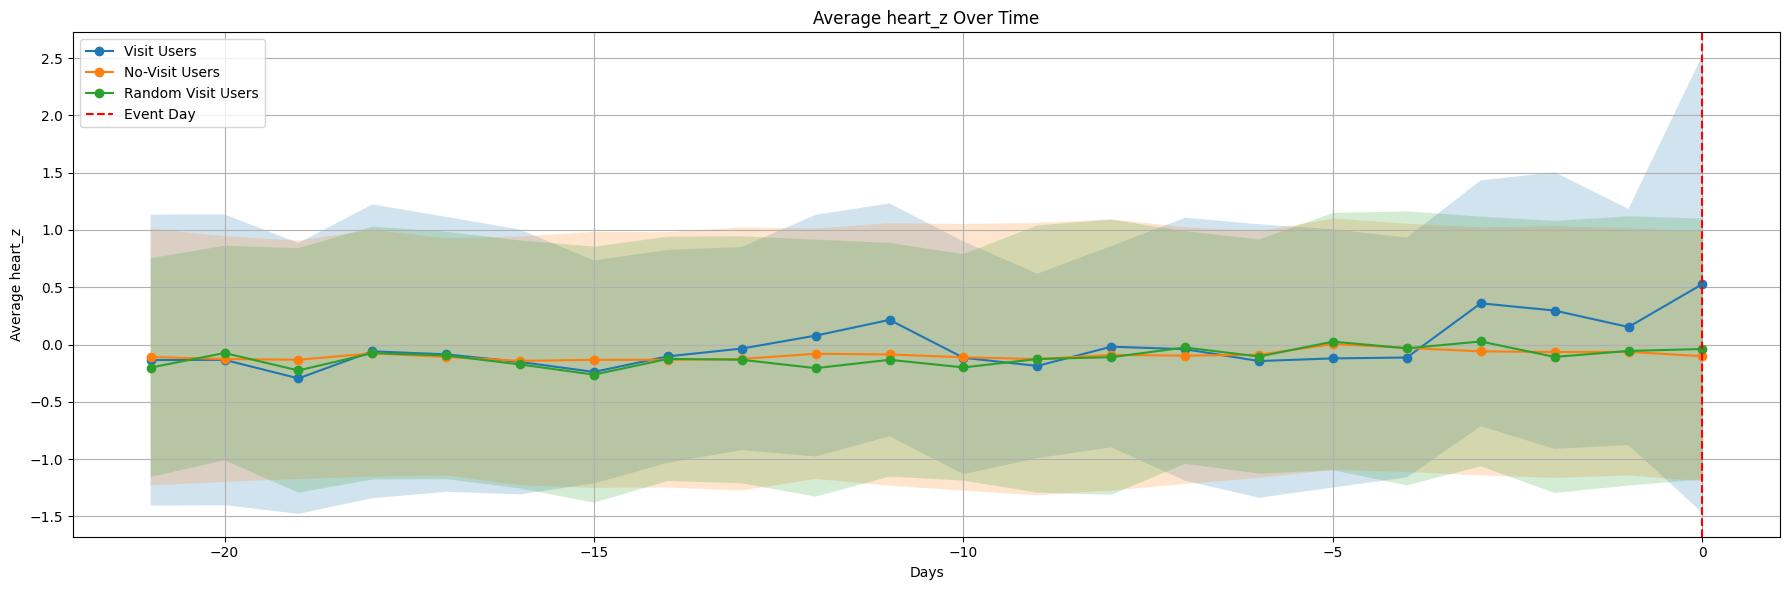

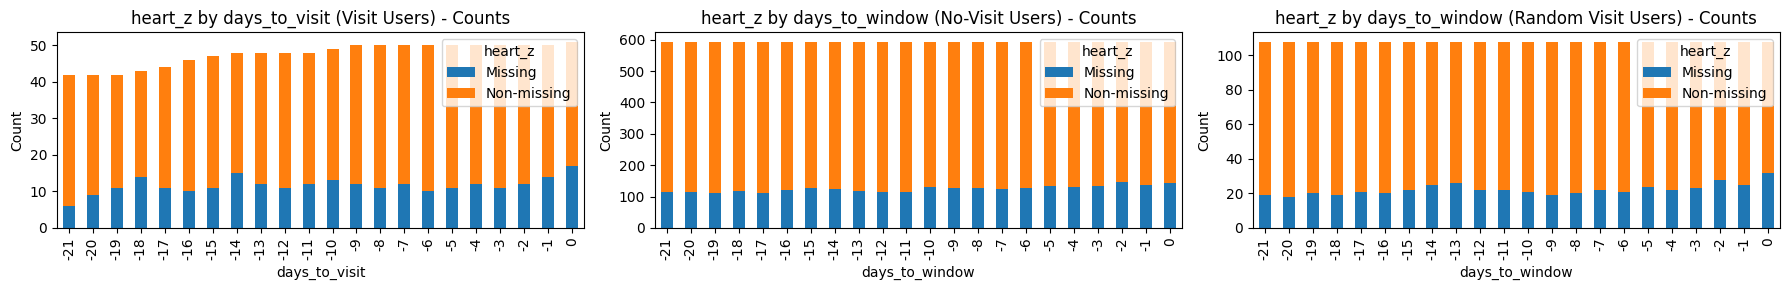

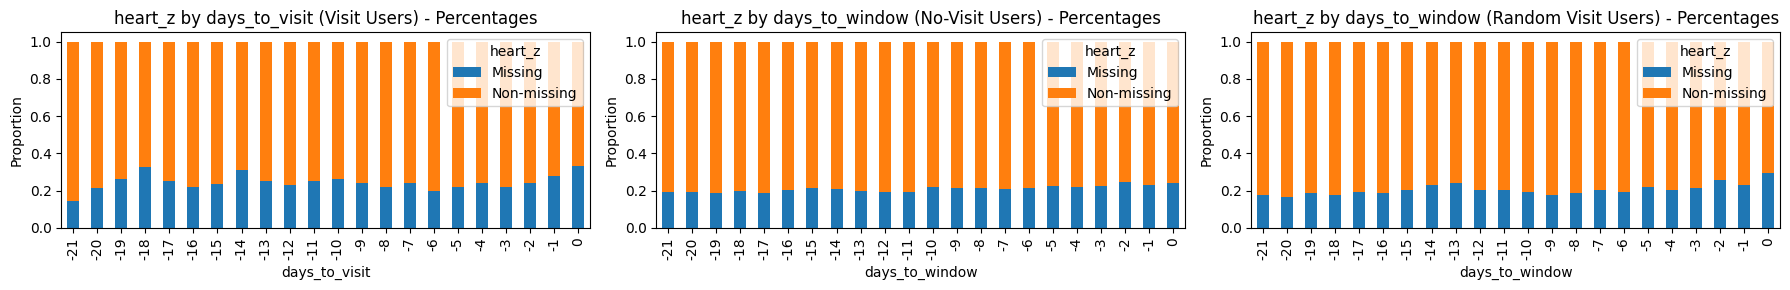

In [92]:
plot_feature_comparison_3(three_week_visit, three_week, three_week_visit_random_window, 'heart_z', bin_continuous = True)

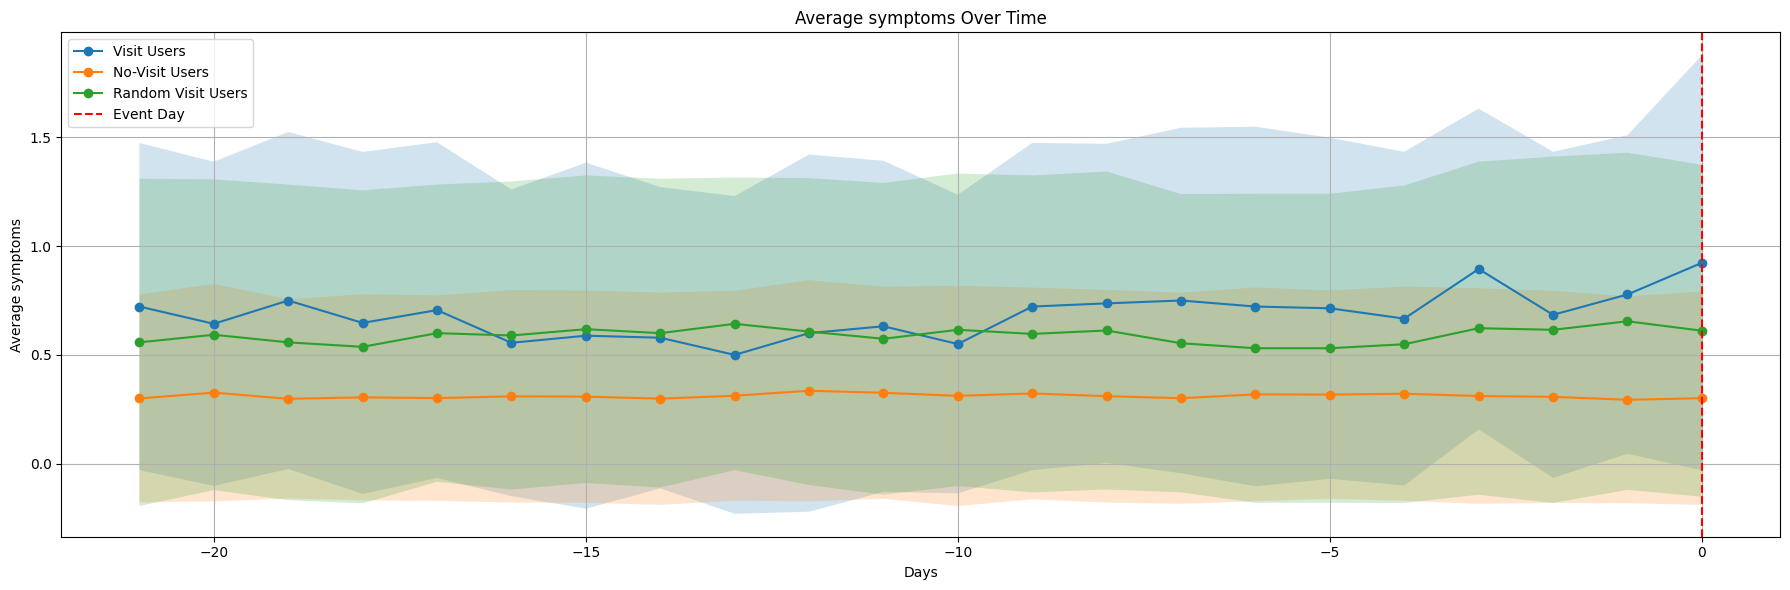

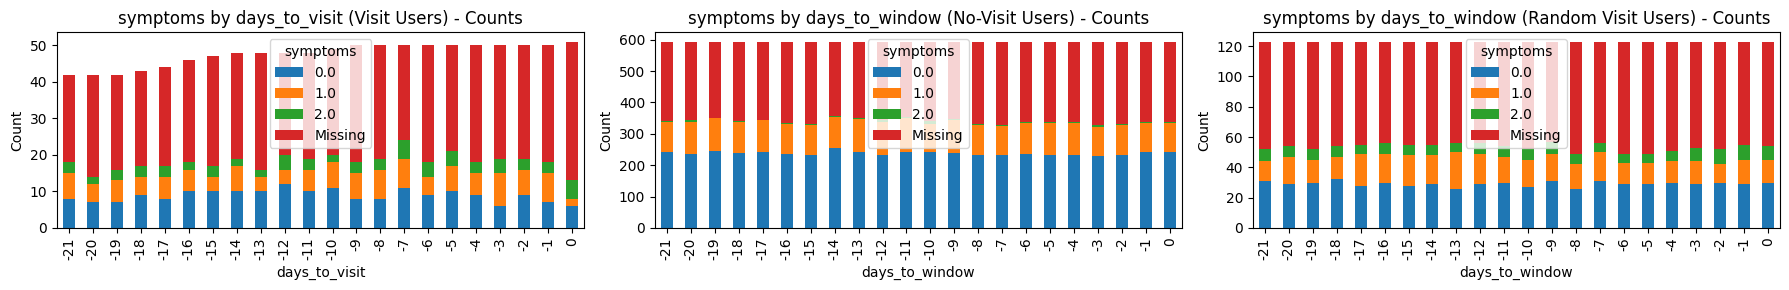

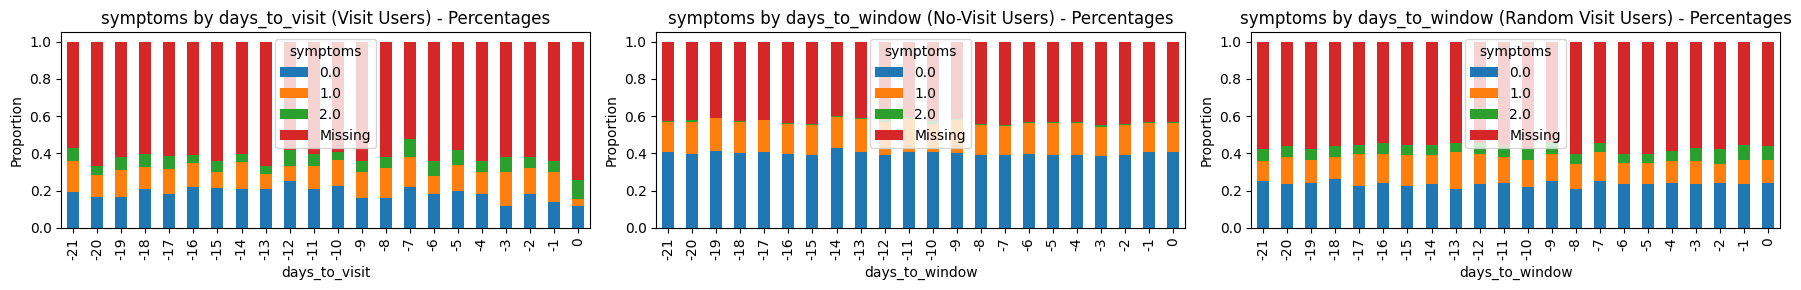

In [82]:
plot_feature_comparison_3(three_week_visit, three_week, three_week_visit_random, 'symptoms', bin_continuous = False)

In [83]:
get_top_3_per_day(three_week_visit_random_window, 'heart_z', 'days_to_window')

fitbit_user_id  days_to_window   heart_z
0               27             -21  2.727619
1              192             -21  2.684007
2               43             -21  2.042727
3              192             -20  2.353249
4               43             -20   2.34031
..             ...             ...       ...
61              67              -1  2.405351
62             215              -1  2.311794
63              67               0  2.438064
64             183               0  2.394326
65             176               0  2.345146

[66 rows x 3 columns]

## 7) Looking at other features

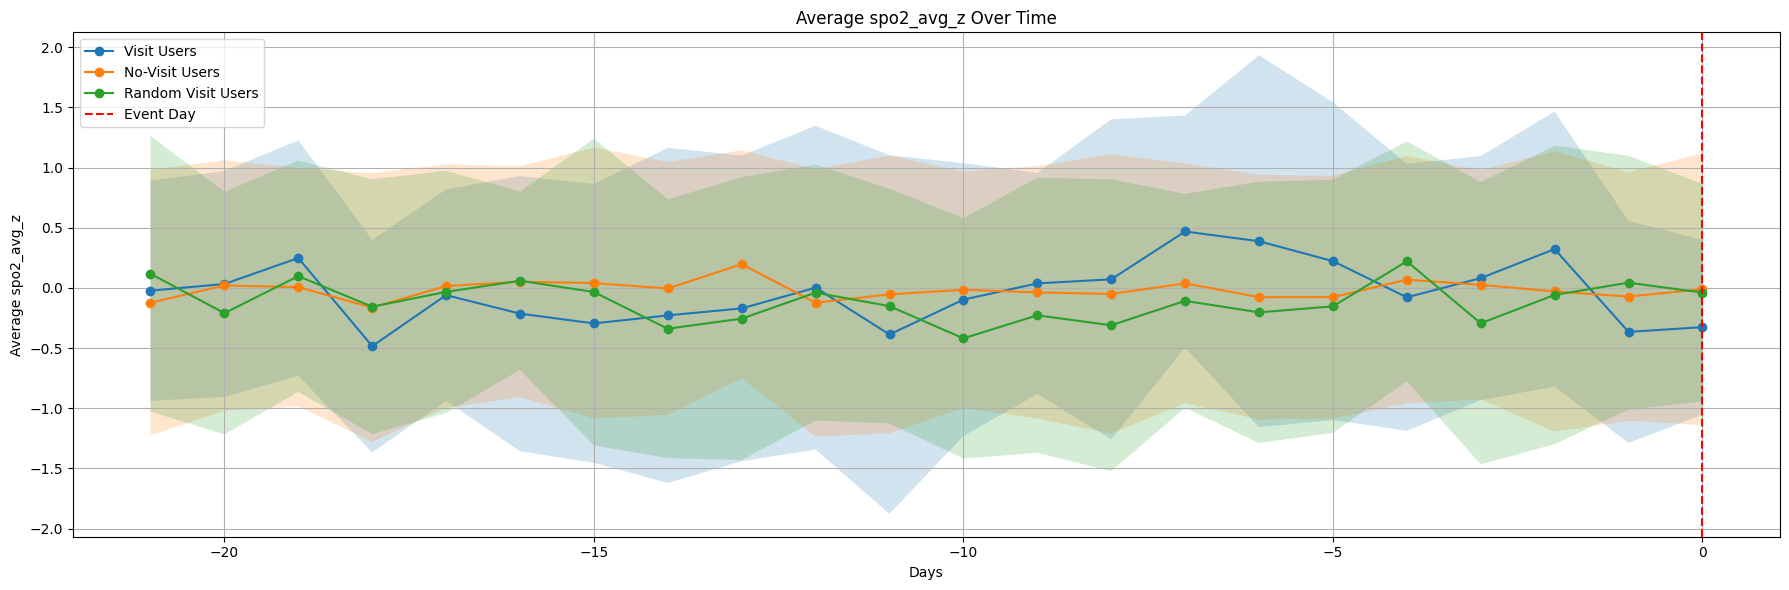

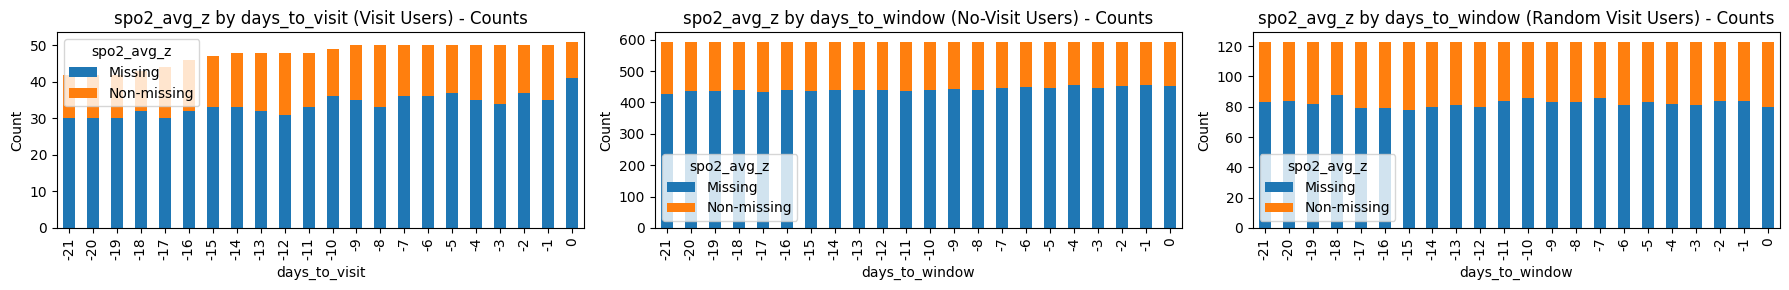

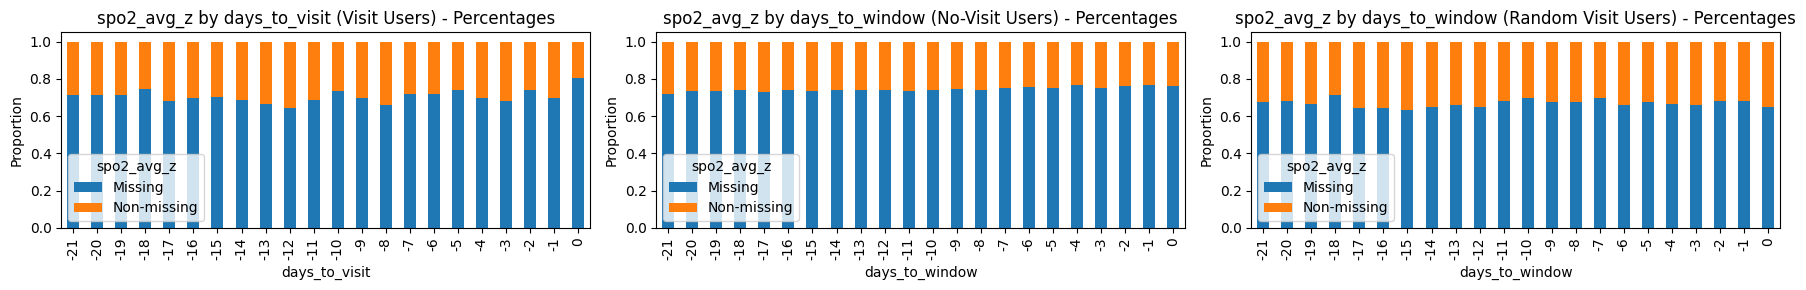

In [54]:
plot_feature_comparison_3(three_week_visit, three_week, three_week_visit_random, 'spo2_avg_z', bin_continuous = True)

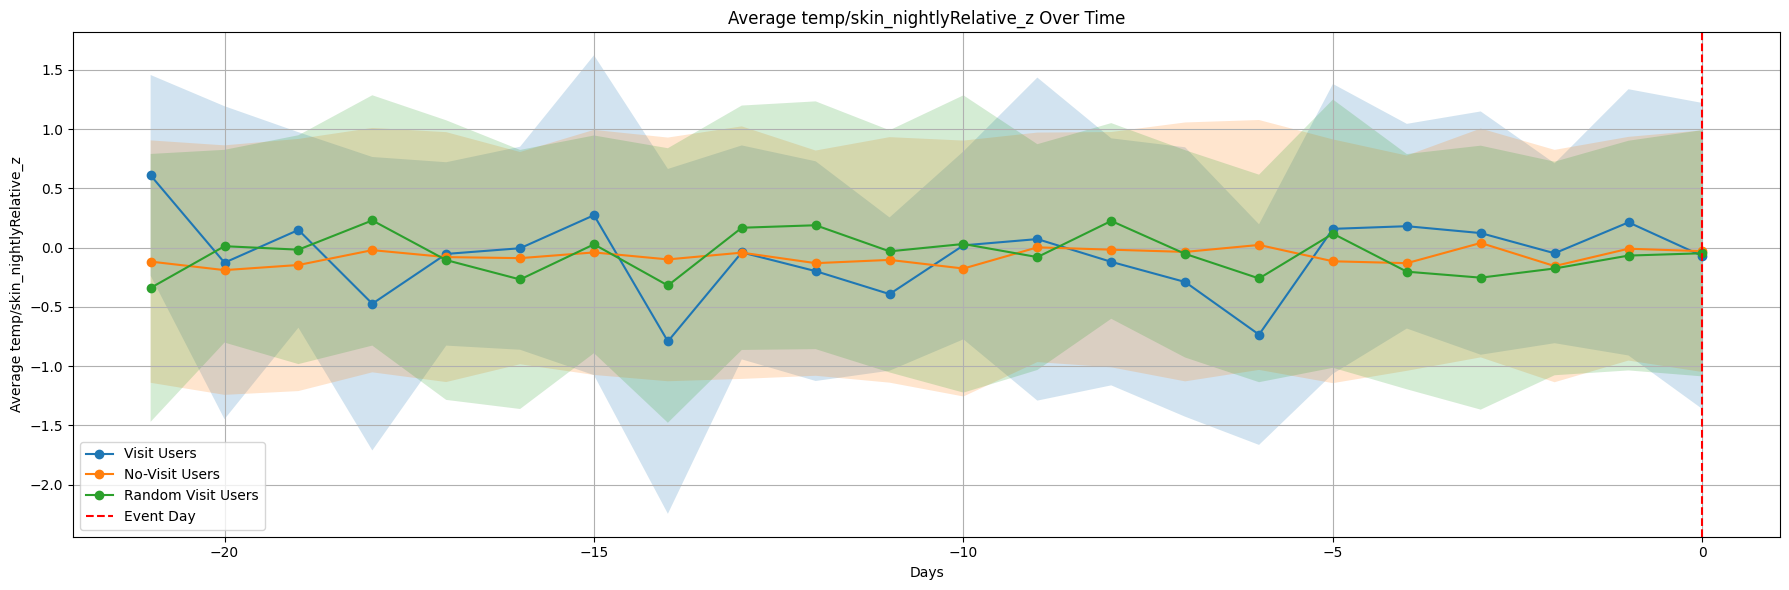

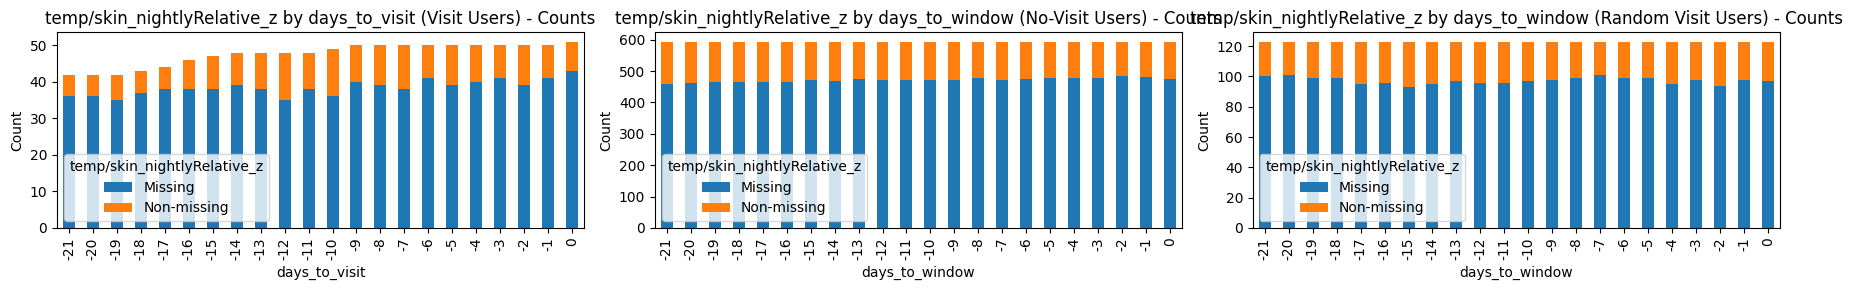

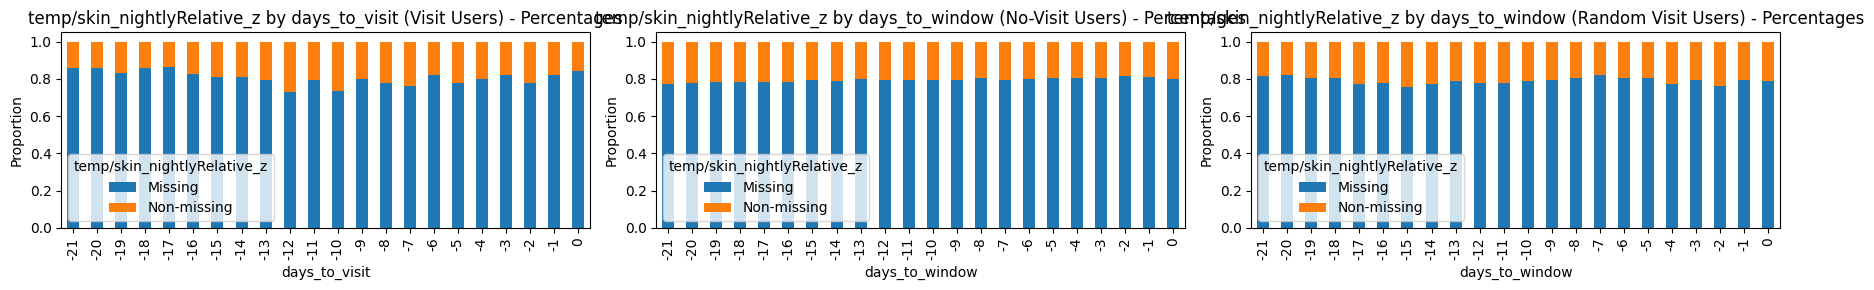

In [55]:
plot_feature_comparison_3(three_week_visit, three_week, three_week_visit_random, 'temp/skin_nightlyRelative_z', bin_continuous = True)

## 8) Moving Average

In [104]:
three_week_visit = extract_days_before_visit(z_fb_data, days_before=23)
three_week = extract_days_no_visits(z_fb_data, window_days=22)
three_week_visit_random = extract_random_days_before_visit(z_fb_data, days_before=22, seed=123)
three_week_visit_random_window = extract_random_days_before_visit(z_fb_data, days_before=22, exclude_window_before_visit=True, seed=123)

three_week_visit = set_value_to_nan(three_week_visit, 82, 0, 'heart_z')

In [111]:
def compute_rolling_means(df, time_col, feature):
        df[feature + '_roll3'] = (
            df.groupby('fitbit_user_id')[feature]
              .rolling(window=3, min_periods=3)
              .mean()
              .reset_index(level=0, drop=True)
        )
        return df

In [112]:
three_week_visit = compute_rolling_means(three_week_visit, 'days_to_visit', 'heart_z')
three_week = compute_rolling_means(three_week, 'days_to_visit', 'heart_z')
three_week_visit_random = compute_rolling_means(three_week_visit_random, 'days_to_window', 'heart_z')

In [115]:
three_week_visit.to_csv('three_week_visit.csv', index=False)
files.download('three_week_visit.csv')

three_week_visit_random.to_csv('three_week_visit_r.csv', index=False)
files.download('three_week_visit_r.csv')

three_week_visit_random_window.to_csv('three_week_visit_rw.csv', index=False)
files.download('three_week_visit_rw.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>